In [1]:
from analysis.moment_analysis import ModelsContainer
from numpy import average
from energyflow.datasets import qg_jets
from energyflow.utils import data_split
from sklearn.metrics import roc_auc_score
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')



/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/rikab/Documents/Physics/Grad/Research/moment/energyflow/archs/__init__.py:30: UserWarning: could not import some architectures - cannot import name 'cnn' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Physics/Grad/Research/moment/energyflow/archs/__init__.py)
  warnings.warn('could not import some architectures - ' + str(e))
/home/rikab/Documents/Physics/Grad/Research/moment/energyflow/archs/__init__.py:40: UserWarning: could not import some architectures - cannot import name 'linear' from partially initialized module 'energyflow.archs' (most likely due to a circular import) (/home/rikab/Documents/Physics/Grad/Research/moment/energyflow/archs/__init__.py)
  warnings.war

In [7]:
train = 15000
val = 2000
test = 1000
X, Y = qg_jets.load(train+val+test)
X = X[:,:,:3]
for x in X:
    mask = x[:,0] > 0
    yphi_avg = average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

(z_train, z_val, z_test,
 p_train, p_val, p_test,
 Y_train, Y_val, Y_test) = data_split(X[:,:,0], X[:,:,1:], Y, val=val, test=test)

    

In [8]:
X_train = [z_train, p_train]
X_val = [z_val, p_val]
X_test = [z_test, p_test]

[0.00325021 0.01950124 0.05037819 0.13975886 0.32502061 0.64679102
 1.20745158 2.25564305] [1.2787536 1.4939094 1.7090652 1.924221  2.1393768 2.3545326 2.5696884
 2.7848442 3.       ] 178.75


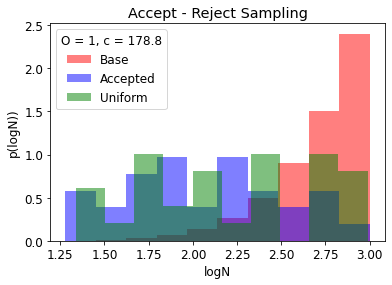

[0.00668465 0.01782575 0.06461833 0.14483419 0.29858125 0.67737837
 1.28568197 2.33071635] [1.34242268 1.54961985 1.75681701 1.96401418 2.17121134 2.37840851
 2.58560567 2.79280284 3.        ] 90.24999999999999


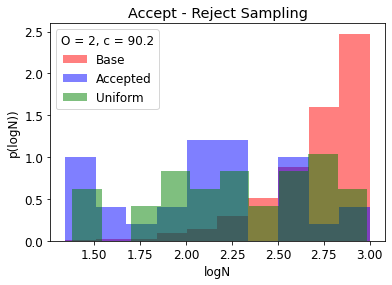

[0.01567489 0.02687123 0.06046027 0.1388347  0.3515653  0.71208768
 1.32340823 2.36466851] [1.39794001 1.59819751 1.79845501 1.99871251 2.19897    2.3992275
 2.599485   2.7997425  3.        ] 39.82142857142858


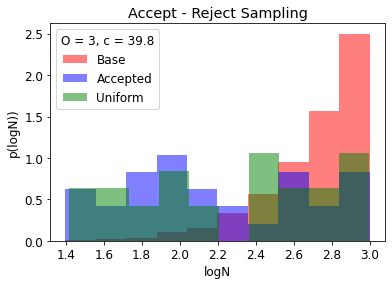

[0.01229068 0.04096894 0.09832546 0.18640868 0.38305959 0.79684589
 1.32944212 2.3045029 ] [1.44715803 1.64126328 1.83536852 2.02947377 2.22357902 2.41768426
 2.61178951 2.80589475 3.        ] 52.39583333333333


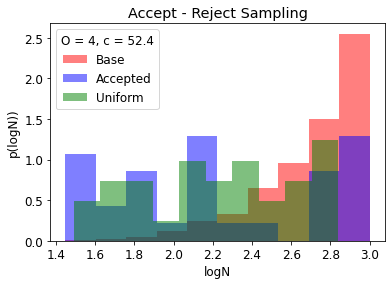

In [9]:
num_models_to_train = 3 ##number of models to use to make error bars
order_list = [1,2,3,4] #
input_dim = 2
output_dim = 1



### specify the thing to vary ####
num_samples = 50
max_L_per_order = [25,10,5,3]
F_min, F_max = 1, 50
Phi_min, Phi_max = 1, 50
logN_max = 3



# Function to calculate effective latent dimension
def effective_latent_dim(O, L):

    binom = scipy.special.binom(L+O, O+1)
    return int( (O+1) * binom / L)
    

# Function to calculate total parameters
def num_params(input_dim, layers, output_dim):

    params = input_dim * (layers[0] + 1)
    for i in range(len(layers)-1):
        params = params + (layers[i])*(layers[i+1] +1)
    return params + (output_dim)*(layers[-1] + 1)


order_configs = {}
for p, order in enumerate(order_list):

    logNs = []
    accepted = []
    configs = []

    logN_min = np.log10(num_params(input_dim, [1, 1, effective_latent_dim(order, 1), 1, 1, 1], output_dim))


    # Generate histograms
    for i in range(25000):


        l = np.random.randint(1, max_L_per_order[p] + 1)
        f = np.random.randint(F_min, F_max + 1)
        phi = np.random.randint(Phi_min, Phi_max + 1)

        # Get number of parameters
        layers = [phi, phi, effective_latent_dim(order, l), f, f, f]
        logN = np.log10(num_params(input_dim, layers, output_dim))
        rand = np.random.rand() * logN_max
        logNs.append(logN)

        if logN < rand:
            configs.append([l, f, phi])
            accepted.append(logN)

    # order_configs['Order %d' % order] = np.asarray(configs)
    counts, bins,  = np.histogram(logNs,  density = True, range = [logN_min,logN_max], bins = 8)
    uniform_density = 1 / (logN_max - logN_min)
    c = uniform_density / min(counts)
    c = np.amin([c, 5000])

    print(counts, bins, c)


    logNs = []
    accepted = []
    configs = []

    # Accept/reject sampler
    while len(configs) < num_samples:

        l = np.random.randint(1, max_L_per_order[p] + 1)
        f = np.random.randint(F_min, F_max + 1)
        phi = np.random.randint(Phi_min, Phi_max + 1)

        # Get number of parameters
        layers = [phi, phi, effective_latent_dim(order, l), f, f, f]
        logN = np.log10(num_params(input_dim, layers, output_dim))
        rand = np.random.rand() * logN_max
        logNs.append(logN)

        if logN < logN_max and rand < uniform_density / (c * counts[np.digitize(logN, bins)-1]):
            configs.append([l, f, phi])
            accepted.append(logN)

    order_configs['Order %d' % order] = np.asarray(configs)
    counts, bins, _ = plt.hist(logNs, color = "red", density = True, range = [logN_min,logN_max], alpha = 0.5, label = "Base")
    plt.hist(accepted, color = "blue", density = True, range = [logN_min,logN_max], alpha = 0.5, label = "Accepted")
    plt.hist(np.random.rand(num_samples) * (logN_max - logN_min) + logN_min, density = True, color = "green", alpha = 0.5, label = "Uniform")
    plt.legend(title = "O = %d, c = %.1f" % (order, c))
    plt.title("Accept - Reject Sampling")
    plt.xlabel("logN")
    plt.ylabel("p(logN))")
    plt.show()






In [10]:
import matplotlib.pyplot as plt



def plot(performance_dict):
    

    colors = ["red", "orange", "green", "blue"]

    fig, axes = plt.subplots(1, 1, figsize=(6,6))
    plt.rcParams['font.size'] = '12'


    for p, order in enumerate(order_list):
        x = []
        y = []
        yerr= []

        for info in performance_dict['Order '+str(order)]:
            x.append(info[0])
            y.append(info[1])
            yerr.append(info[2])
            
        # axes.scatter(x, y,  marker = "o", c=colors[p], label = r'$O = %d$ ' % order if order > 1 else "EFN", alpha = 0.5)
        x = np.asarray(x)
        y = np.asarray(y)
        yerr = np.asarray(yerr)
        axes.errorbar(x[yerr < 0.9],1 -y[yerr < 0.9], yerr[yerr < 0.9], marker = "o", c=colors[p], label = r'$O = %d$ ' % order if order > 1 else "EFN", alpha = 0.5, linestyle='None')


    # Special Points
    # axes.scatter([82358,], [.8824], marker = "*", color = colors[0])


    legend = axes.legend(frameon = False)
    plt.xlabel("Model Parameters")
    plt.ylabel("1 - AUC")
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Model Performance vs. Complexity")


    plt.show()

0 1 [2 4 9] 198
Epoch 1/50
150/150 - 2s - loss: 0.6827 - acc: 0.6322 - val_loss: 0.6553 - val_acc: 0.6910
Epoch 2/50
150/150 - 2s - loss: 0.6477 - acc: 0.6802 - val_loss: 0.6278 - val_acc: 0.6755
Epoch 3/50
150/150 - 2s - loss: 0.6289 - acc: 0.6671 - val_loss: 0.6140 - val_acc: 0.6740
Epoch 4/50
150/150 - 2s - loss: 0.6191 - acc: 0.6648 - val_loss: 0.6083 - val_acc: 0.6725
Epoch 5/50
150/150 - 2s - loss: 0.6134 - acc: 0.6672 - val_loss: 0.6048 - val_acc: 0.6815
Epoch 6/50
150/150 - 2s - loss: 0.6100 - acc: 0.6686 - val_loss: 0.6009 - val_acc: 0.6780
Epoch 7/50
150/150 - 2s - loss: 0.6071 - acc: 0.6690 - val_loss: 0.6011 - val_acc: 0.6700
Epoch 8/50
150/150 - 2s - loss: 0.6049 - acc: 0.6685 - val_loss: 0.5956 - val_acc: 0.6845
Epoch 9/50
150/150 - 2s - loss: 0.6026 - acc: 0.6704 - val_loss: 0.5941 - val_acc: 0.6825
Epoch 10/50
150/150 - 2s - loss: 0.6003 - acc: 0.6712 - val_loss: 0.5931 - val_acc: 0.6945
Epoch 11/50
150/150 - 2s - loss: 0.5990 - acc: 0.6732 - val_loss: 0.5885 - val_acc:

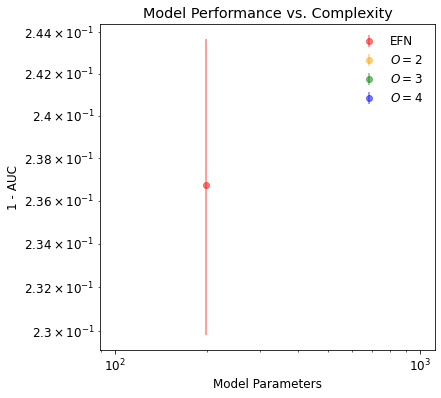

1 1 [11 10  7] 526
Epoch 1/50
150/150 - 3s - loss: 0.6559 - acc: 0.6419 - val_loss: 0.6207 - val_acc: 0.6680
Epoch 2/50
150/150 - 3s - loss: 0.6139 - acc: 0.6648 - val_loss: 0.5916 - val_acc: 0.6900
Epoch 3/50
150/150 - 3s - loss: 0.5863 - acc: 0.6864 - val_loss: 0.5776 - val_acc: 0.6970
Epoch 4/50
150/150 - 3s - loss: 0.5775 - acc: 0.6902 - val_loss: 0.5695 - val_acc: 0.7085
Epoch 5/50
150/150 - 3s - loss: 0.5746 - acc: 0.6925 - val_loss: 0.5623 - val_acc: 0.7135
Epoch 6/50
150/150 - 3s - loss: 0.5719 - acc: 0.6944 - val_loss: 0.5674 - val_acc: 0.7035
Epoch 7/50
150/150 - 3s - loss: 0.5709 - acc: 0.6953 - val_loss: 0.5653 - val_acc: 0.7050
Epoch 8/50
150/150 - 3s - loss: 0.5702 - acc: 0.6959 - val_loss: 0.5633 - val_acc: 0.7060
Epoch 9/50
150/150 - 3s - loss: 0.5698 - acc: 0.6968 - val_loss: 0.5596 - val_acc: 0.7115
Epoch 10/50
150/150 - 3s - loss: 0.5703 - acc: 0.6969 - val_loss: 0.5602 - val_acc: 0.7190
Epoch 11/50
150/150 - 3s - loss: 0.5696 - acc: 0.6966 - val_loss: 0.5724 - val_a

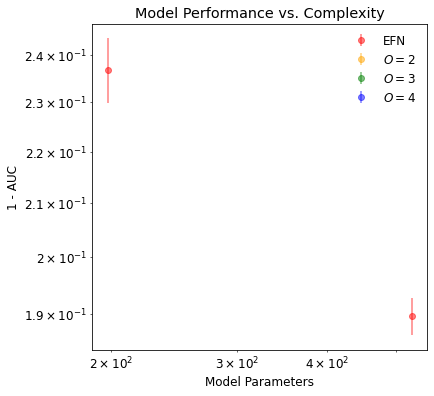

2 1 [25  1  2] 120
Epoch 1/50
150/150 - 6s - loss: 0.6893 - acc: 0.5438 - val_loss: 0.6782 - val_acc: 0.5615
Epoch 2/50
150/150 - 5s - loss: 0.6290 - acc: 0.6514 - val_loss: 0.5981 - val_acc: 0.6820
Epoch 3/50
150/150 - 5s - loss: 0.6045 - acc: 0.6753 - val_loss: 0.5961 - val_acc: 0.6860
Epoch 4/50
150/150 - 5s - loss: 0.6032 - acc: 0.6769 - val_loss: 0.5944 - val_acc: 0.6860
Epoch 5/50
150/150 - 6s - loss: 0.6028 - acc: 0.6770 - val_loss: 0.5943 - val_acc: 0.6860
Epoch 6/50
150/150 - 5s - loss: 0.6019 - acc: 0.6784 - val_loss: 0.5939 - val_acc: 0.6865
Epoch 7/50
150/150 - 5s - loss: 0.6017 - acc: 0.6779 - val_loss: 0.5967 - val_acc: 0.6850
Epoch 8/50
150/150 - 5s - loss: 0.6013 - acc: 0.6795 - val_loss: 0.5953 - val_acc: 0.6880
Epoch 9/50
150/150 - 5s - loss: 0.6008 - acc: 0.6798 - val_loss: 0.5945 - val_acc: 0.6885
Epoch 10/50
150/150 - 5s - loss: 0.6008 - acc: 0.6798 - val_loss: 0.5933 - val_acc: 0.6880
Epoch 11/50
150/150 - 5s - loss: 0.6006 - acc: 0.6800 - val_loss: 0.5936 - val_a

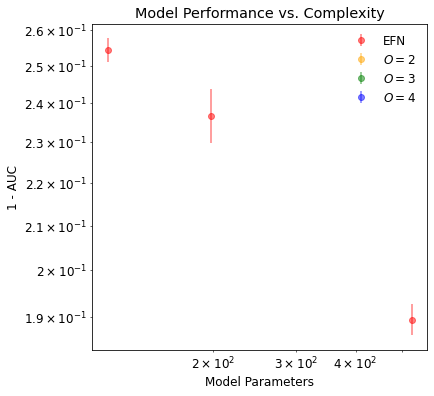

3 1 [3 5 7] 192
Epoch 1/50
150/150 - 2s - loss: 0.6743 - acc: 0.6248 - val_loss: 0.6347 - val_acc: 0.6815
Epoch 2/50
150/150 - 2s - loss: 0.6280 - acc: 0.6661 - val_loss: 0.6139 - val_acc: 0.6730
Epoch 3/50
150/150 - 2s - loss: 0.6140 - acc: 0.6668 - val_loss: 0.6029 - val_acc: 0.6760
Epoch 4/50
150/150 - 2s - loss: 0.6058 - acc: 0.6749 - val_loss: 0.5935 - val_acc: 0.6885
Epoch 5/50
150/150 - 2s - loss: 0.5965 - acc: 0.6789 - val_loss: 0.5836 - val_acc: 0.6975
Epoch 6/50
150/150 - 2s - loss: 0.5872 - acc: 0.6832 - val_loss: 0.5740 - val_acc: 0.6995
Epoch 7/50
150/150 - 2s - loss: 0.5808 - acc: 0.6892 - val_loss: 0.5685 - val_acc: 0.7070
Epoch 8/50
150/150 - 2s - loss: 0.5764 - acc: 0.6930 - val_loss: 0.5673 - val_acc: 0.7120
Epoch 9/50
150/150 - 2s - loss: 0.5750 - acc: 0.6955 - val_loss: 0.5643 - val_acc: 0.7130
Epoch 10/50
150/150 - 2s - loss: 0.5735 - acc: 0.6968 - val_loss: 0.5664 - val_acc: 0.7135
Epoch 11/50
150/150 - 2s - loss: 0.5720 - acc: 0.6975 - val_loss: 0.5627 - val_acc:

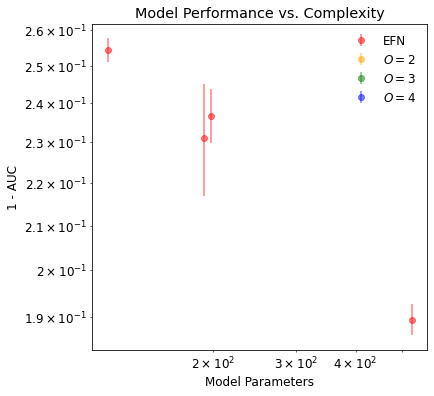

4 1 [15  1  1] 58
Epoch 1/50
150/150 - 3s - loss: 0.6919 - acc: 0.5524 - val_loss: 0.6851 - val_acc: 0.5335
Epoch 2/50
150/150 - 3s - loss: 0.6635 - acc: 0.6188 - val_loss: 0.6451 - val_acc: 0.6625
Epoch 3/50
150/150 - 3s - loss: 0.6143 - acc: 0.6735 - val_loss: 0.5912 - val_acc: 0.6990
Epoch 4/50
150/150 - 3s - loss: 0.5841 - acc: 0.6899 - val_loss: 0.5750 - val_acc: 0.7010
Epoch 5/50
150/150 - 3s - loss: 0.5799 - acc: 0.6917 - val_loss: 0.5758 - val_acc: 0.7035
Epoch 6/50
150/150 - 3s - loss: 0.5788 - acc: 0.6916 - val_loss: 0.5703 - val_acc: 0.7045
Epoch 7/50
150/150 - 3s - loss: 0.5781 - acc: 0.6922 - val_loss: 0.5738 - val_acc: 0.7030
Epoch 8/50
150/150 - 3s - loss: 0.5780 - acc: 0.6935 - val_loss: 0.5696 - val_acc: 0.7065
Epoch 9/50
150/150 - 3s - loss: 0.5773 - acc: 0.6937 - val_loss: 0.5729 - val_acc: 0.7080
Epoch 10/50
150/150 - 3s - loss: 0.5769 - acc: 0.6951 - val_loss: 0.5691 - val_acc: 0.7070
Epoch 11/50
150/150 - 3s - loss: 0.5767 - acc: 0.6949 - val_loss: 0.5691 - val_ac

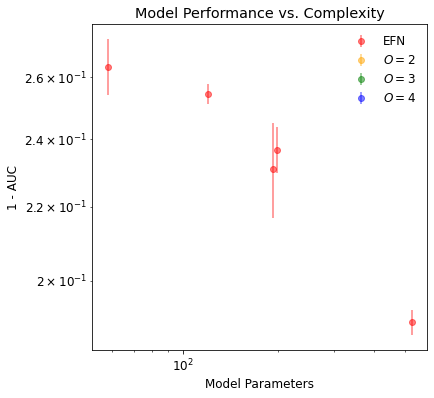

5 1 [1 2 1] 28
Epoch 1/50
150/150 - 1s - loss: 0.6933 - acc: 0.4975 - val_loss: 0.6941 - val_acc: 0.4625
Epoch 2/50
150/150 - 1s - loss: 0.6932 - acc: 0.5017 - val_loss: 0.6928 - val_acc: 0.5375
Epoch 3/50
150/150 - 1s - loss: 0.6932 - acc: 0.4977 - val_loss: 0.6940 - val_acc: 0.4625
Epoch 4/50
150/150 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6929 - val_acc: 0.5375
Epoch 5/50
150/150 - 1s - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 6/50
150/150 - 1s - loss: 0.6932 - acc: 0.4987 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 7/50
150/150 - 1s - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6929 - val_acc: 0.5375
Epoch 8/50
150/150 - 1s - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 9/50
150/150 - 1s - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6929 - val_acc: 0.5375
Epoch 10/50
150/150 - 1s - loss: 0.6932 - acc: 0.4989 - val_loss: 0.6942 - val_acc: 0.4625
Epoch 11/50
150/150 - 1s - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6947 - val_acc: 

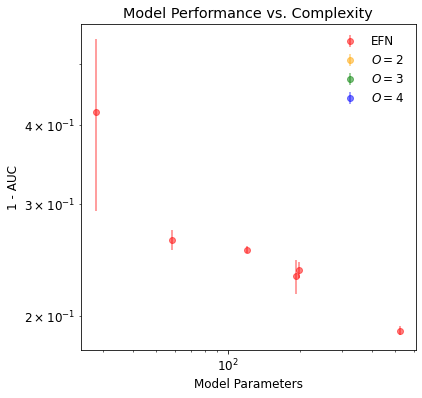

6 1 [24  4  1] 202
Epoch 1/50
150/150 - 5s - loss: 0.6652 - acc: 0.6105 - val_loss: 0.6118 - val_acc: 0.6880
Epoch 2/50
150/150 - 5s - loss: 0.6052 - acc: 0.6772 - val_loss: 0.5842 - val_acc: 0.7055
Epoch 3/50
150/150 - 5s - loss: 0.5949 - acc: 0.6862 - val_loss: 0.5780 - val_acc: 0.7135
Epoch 4/50
150/150 - 5s - loss: 0.5906 - acc: 0.6896 - val_loss: 0.5770 - val_acc: 0.7165
Epoch 5/50
150/150 - 5s - loss: 0.5869 - acc: 0.6911 - val_loss: 0.5726 - val_acc: 0.7140
Epoch 6/50
150/150 - 5s - loss: 0.5829 - acc: 0.6940 - val_loss: 0.5680 - val_acc: 0.7155
Epoch 7/50
150/150 - 5s - loss: 0.5795 - acc: 0.6953 - val_loss: 0.5654 - val_acc: 0.7180
Epoch 8/50
150/150 - 5s - loss: 0.5749 - acc: 0.6970 - val_loss: 0.5617 - val_acc: 0.7235
Epoch 9/50
150/150 - 5s - loss: 0.5734 - acc: 0.6991 - val_loss: 0.5620 - val_acc: 0.7215
Epoch 10/50
150/150 - 5s - loss: 0.5726 - acc: 0.6985 - val_loss: 0.5612 - val_acc: 0.7205
Epoch 11/50
150/150 - 5s - loss: 0.5729 - acc: 0.6985 - val_loss: 0.5627 - val_a

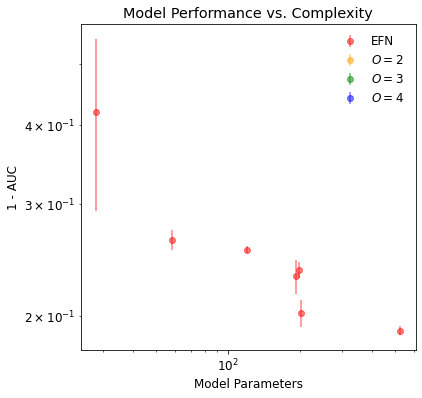

7 1 [8 1 3] 69
Epoch 1/50
150/150 - 2s - loss: 0.6927 - acc: 0.5314 - val_loss: 0.6911 - val_acc: 0.6015
Epoch 2/50
150/150 - 2s - loss: 0.6737 - acc: 0.6379 - val_loss: 0.6359 - val_acc: 0.7030
Epoch 3/50
150/150 - 2s - loss: 0.6348 - acc: 0.6688 - val_loss: 0.6244 - val_acc: 0.6665
Epoch 4/50
150/150 - 2s - loss: 0.6248 - acc: 0.6631 - val_loss: 0.6165 - val_acc: 0.6715
Epoch 5/50
150/150 - 2s - loss: 0.6187 - acc: 0.6622 - val_loss: 0.6121 - val_acc: 0.6755
Epoch 6/50
150/150 - 2s - loss: 0.6158 - acc: 0.6646 - val_loss: 0.6101 - val_acc: 0.6730
Epoch 7/50
150/150 - 2s - loss: 0.6132 - acc: 0.6689 - val_loss: 0.6067 - val_acc: 0.6785
Epoch 8/50
150/150 - 2s - loss: 0.6114 - acc: 0.6735 - val_loss: 0.6045 - val_acc: 0.6825
Epoch 9/50
150/150 - 2s - loss: 0.6103 - acc: 0.6764 - val_loss: 0.6080 - val_acc: 0.6785
Epoch 10/50
150/150 - 2s - loss: 0.6088 - acc: 0.6793 - val_loss: 0.6006 - val_acc: 0.6955
Epoch 11/50
150/150 - 2s - loss: 0.6076 - acc: 0.6793 - val_loss: 0.6021 - val_acc: 

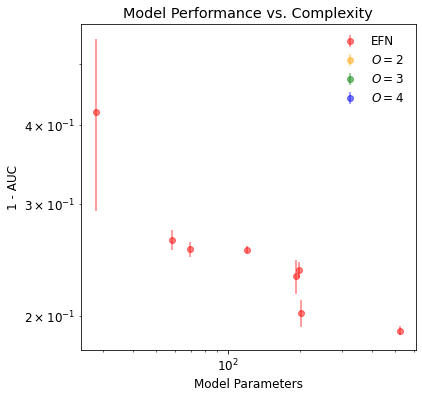

8 1 [1 1 1] 16
Epoch 1/50
150/150 - 1s - loss: 0.6929 - acc: 0.5126 - val_loss: 0.6908 - val_acc: 0.6965
Epoch 2/50
150/150 - 1s - loss: 0.6882 - acc: 0.6582 - val_loss: 0.6832 - val_acc: 0.6810
Epoch 3/50
150/150 - 1s - loss: 0.6670 - acc: 0.6372 - val_loss: 0.6454 - val_acc: 0.6615
Epoch 4/50
150/150 - 1s - loss: 0.6318 - acc: 0.6671 - val_loss: 0.6225 - val_acc: 0.6800
Epoch 5/50
150/150 - 1s - loss: 0.6204 - acc: 0.6702 - val_loss: 0.6170 - val_acc: 0.6935
Epoch 6/50
150/150 - 1s - loss: 0.6171 - acc: 0.6708 - val_loss: 0.6152 - val_acc: 0.6885
Epoch 7/50
150/150 - 1s - loss: 0.6158 - acc: 0.6718 - val_loss: 0.6158 - val_acc: 0.6795
Epoch 8/50
150/150 - 1s - loss: 0.6163 - acc: 0.6733 - val_loss: 0.6156 - val_acc: 0.6800
Epoch 9/50
150/150 - 1s - loss: 0.6149 - acc: 0.6750 - val_loss: 0.6128 - val_acc: 0.7045
Epoch 10/50
150/150 - 1s - loss: 0.6143 - acc: 0.6739 - val_loss: 0.6129 - val_acc: 0.6880
Epoch 11/50
150/150 - 1s - loss: 0.6146 - acc: 0.6746 - val_loss: 0.6122 - val_acc: 

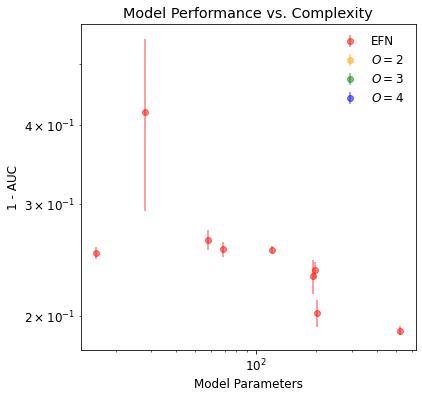

9 1 [7 2 2] 66
Epoch 1/50
150/150 - 2s - loss: 0.6942 - acc: 0.5240 - val_loss: 0.6928 - val_acc: 0.4840
Epoch 2/50
150/150 - 2s - loss: 0.6908 - acc: 0.5330 - val_loss: 0.6853 - val_acc: 0.5690
Epoch 3/50
150/150 - 2s - loss: 0.6317 - acc: 0.6578 - val_loss: 0.5765 - val_acc: 0.7035
Epoch 4/50
150/150 - 2s - loss: 0.5851 - acc: 0.6849 - val_loss: 0.5712 - val_acc: 0.7040
Epoch 5/50
150/150 - 2s - loss: 0.5814 - acc: 0.6869 - val_loss: 0.5683 - val_acc: 0.7060
Epoch 6/50
150/150 - 2s - loss: 0.5796 - acc: 0.6889 - val_loss: 0.5712 - val_acc: 0.7040
Epoch 7/50
150/150 - 2s - loss: 0.5784 - acc: 0.6904 - val_loss: 0.5675 - val_acc: 0.7080
Epoch 8/50
150/150 - 2s - loss: 0.5778 - acc: 0.6916 - val_loss: 0.5664 - val_acc: 0.7060
Epoch 9/50
150/150 - 2s - loss: 0.5771 - acc: 0.6911 - val_loss: 0.5673 - val_acc: 0.7080
Epoch 10/50
150/150 - 2s - loss: 0.5766 - acc: 0.6917 - val_loss: 0.5664 - val_acc: 0.7085
Epoch 11/50
150/150 - 2s - loss: 0.5764 - acc: 0.6920 - val_loss: 0.5650 - val_acc: 

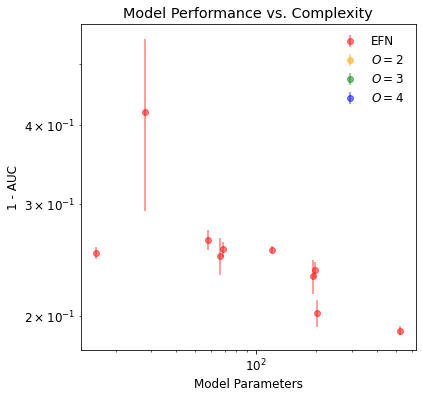

10 1 [11  6  5] 280
Epoch 1/50
150/150 - 3s - loss: 0.6883 - acc: 0.5846 - val_loss: 0.6756 - val_acc: 0.5940
Epoch 2/50
150/150 - 3s - loss: 0.6276 - acc: 0.6553 - val_loss: 0.5837 - val_acc: 0.6960
Epoch 3/50
150/150 - 3s - loss: 0.5843 - acc: 0.6865 - val_loss: 0.5704 - val_acc: 0.7055
Epoch 4/50
150/150 - 3s - loss: 0.5784 - acc: 0.6923 - val_loss: 0.5669 - val_acc: 0.7095
Epoch 5/50
150/150 - 3s - loss: 0.5762 - acc: 0.6935 - val_loss: 0.5646 - val_acc: 0.7090
Epoch 6/50
150/150 - 3s - loss: 0.5750 - acc: 0.6942 - val_loss: 0.5639 - val_acc: 0.7105
Epoch 7/50
150/150 - 3s - loss: 0.5729 - acc: 0.6959 - val_loss: 0.5613 - val_acc: 0.7125
Epoch 8/50
150/150 - 3s - loss: 0.5722 - acc: 0.6959 - val_loss: 0.5608 - val_acc: 0.7140
Epoch 9/50
150/150 - 3s - loss: 0.5720 - acc: 0.6959 - val_loss: 0.5667 - val_acc: 0.7120
Epoch 10/50
150/150 - 3s - loss: 0.5727 - acc: 0.6967 - val_loss: 0.5660 - val_acc: 0.7125
Epoch 11/50
150/150 - 3s - loss: 0.5712 - acc: 0.6965 - val_loss: 0.5592 - val_

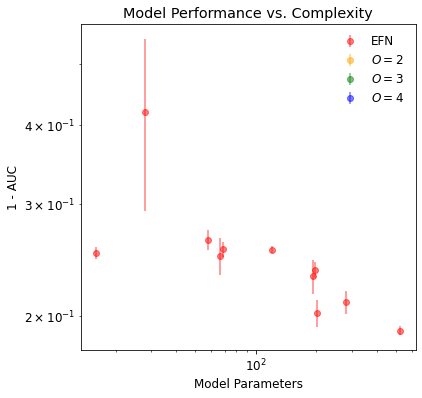

11 1 [20  4 11] 538
Epoch 1/50
150/150 - 5s - loss: 0.6433 - acc: 0.6479 - val_loss: 0.6011 - val_acc: 0.6820
Epoch 2/50
150/150 - 5s - loss: 0.5955 - acc: 0.6836 - val_loss: 0.5842 - val_acc: 0.6980
Epoch 3/50
150/150 - 5s - loss: 0.5870 - acc: 0.6880 - val_loss: 0.5767 - val_acc: 0.7010
Epoch 4/50
150/150 - 5s - loss: 0.5819 - acc: 0.6906 - val_loss: 0.5725 - val_acc: 0.7010
Epoch 5/50
150/150 - 5s - loss: 0.5767 - acc: 0.6917 - val_loss: 0.5710 - val_acc: 0.7040
Epoch 6/50
150/150 - 5s - loss: 0.5740 - acc: 0.6928 - val_loss: 0.5659 - val_acc: 0.7075
Epoch 7/50
150/150 - 5s - loss: 0.5735 - acc: 0.6930 - val_loss: 0.5689 - val_acc: 0.7030
Epoch 8/50
150/150 - 5s - loss: 0.5727 - acc: 0.6937 - val_loss: 0.5671 - val_acc: 0.7040
Epoch 9/50
150/150 - 5s - loss: 0.5724 - acc: 0.6937 - val_loss: 0.5664 - val_acc: 0.7065
Epoch 10/50
150/150 - 5s - loss: 0.5718 - acc: 0.6954 - val_loss: 0.5641 - val_acc: 0.7095
Epoch 11/50
150/150 - 5s - loss: 0.5714 - acc: 0.6947 - val_loss: 0.5647 - val_

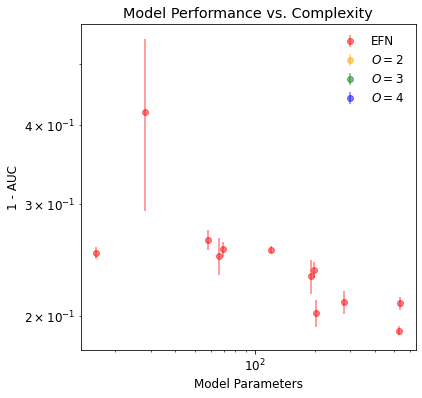

12 1 [13  1  1] 52
Epoch 1/50
150/150 - 3s - loss: 0.6931 - acc: 0.5148 - val_loss: 0.6933 - val_acc: 0.4625
Epoch 2/50
150/150 - 3s - loss: 0.6861 - acc: 0.5673 - val_loss: 0.6710 - val_acc: 0.5915
Epoch 3/50
150/150 - 3s - loss: 0.6373 - acc: 0.6592 - val_loss: 0.6066 - val_acc: 0.6940
Epoch 4/50
150/150 - 3s - loss: 0.5986 - acc: 0.6841 - val_loss: 0.5897 - val_acc: 0.6945
Epoch 5/50
150/150 - 3s - loss: 0.5916 - acc: 0.6861 - val_loss: 0.5835 - val_acc: 0.6995
Epoch 6/50
150/150 - 3s - loss: 0.5896 - acc: 0.6867 - val_loss: 0.5823 - val_acc: 0.7050
Epoch 7/50
150/150 - 3s - loss: 0.5889 - acc: 0.6885 - val_loss: 0.5820 - val_acc: 0.7045
Epoch 8/50
150/150 - 3s - loss: 0.5878 - acc: 0.6906 - val_loss: 0.5797 - val_acc: 0.7040
Epoch 9/50
150/150 - 3s - loss: 0.5875 - acc: 0.6913 - val_loss: 0.5793 - val_acc: 0.7030
Epoch 10/50
150/150 - 3s - loss: 0.5875 - acc: 0.6912 - val_loss: 0.5789 - val_acc: 0.7060
Epoch 11/50
150/150 - 3s - loss: 0.5871 - acc: 0.6921 - val_loss: 0.5811 - val_a

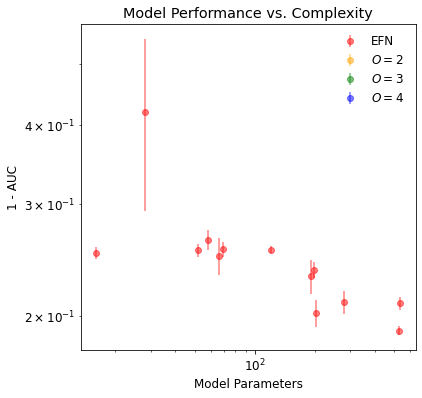

13 1 [6 2 1] 48
Epoch 1/50
150/150 - 2s - loss: 0.7536 - acc: 0.4981 - val_loss: 0.6913 - val_acc: 0.5375
Epoch 2/50
150/150 - 2s - loss: 0.6920 - acc: 0.5949 - val_loss: 0.6917 - val_acc: 0.5685
Epoch 3/50
150/150 - 2s - loss: 0.6909 - acc: 0.6106 - val_loss: 0.6899 - val_acc: 0.5870
Epoch 4/50
150/150 - 2s - loss: 0.6868 - acc: 0.6091 - val_loss: 0.6800 - val_acc: 0.6495
Epoch 5/50
150/150 - 2s - loss: 0.6693 - acc: 0.6773 - val_loss: 0.6518 - val_acc: 0.6920
Epoch 6/50
150/150 - 2s - loss: 0.6557 - acc: 0.6747 - val_loss: 0.6436 - val_acc: 0.6755
Epoch 7/50
150/150 - 2s - loss: 0.6499 - acc: 0.6625 - val_loss: 0.6402 - val_acc: 0.6735
Epoch 8/50
150/150 - 2s - loss: 0.6474 - acc: 0.6553 - val_loss: 0.6391 - val_acc: 0.6595
Epoch 9/50
150/150 - 2s - loss: 0.6455 - acc: 0.6500 - val_loss: 0.6376 - val_acc: 0.6585
Epoch 10/50
150/150 - 2s - loss: 0.6439 - acc: 0.6479 - val_loss: 0.6360 - val_acc: 0.6590
Epoch 11/50
150/150 - 2s - loss: 0.6426 - acc: 0.6466 - val_loss: 0.6344 - val_acc:

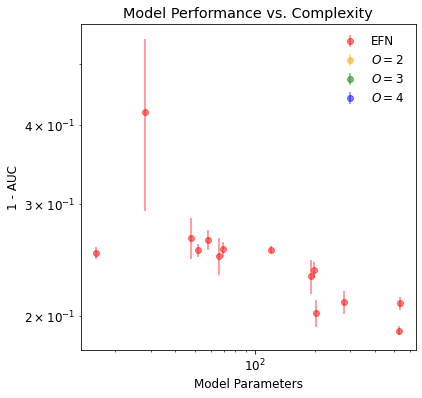

14 1 [2 1 1] 19
Epoch 1/50
150/150 - 2s - loss: 0.6927 - acc: 0.5306 - val_loss: 0.6921 - val_acc: 0.5445
Epoch 2/50
150/150 - 1s - loss: 0.6902 - acc: 0.5622 - val_loss: 0.6884 - val_acc: 0.5585
Epoch 3/50
150/150 - 1s - loss: 0.6799 - acc: 0.5886 - val_loss: 0.6699 - val_acc: 0.6015
Epoch 4/50
150/150 - 1s - loss: 0.6461 - acc: 0.6378 - val_loss: 0.6133 - val_acc: 0.6985
Epoch 5/50
150/150 - 1s - loss: 0.6023 - acc: 0.6848 - val_loss: 0.5824 - val_acc: 0.7165
Epoch 6/50
150/150 - 1s - loss: 0.5900 - acc: 0.6898 - val_loss: 0.5803 - val_acc: 0.7125
Epoch 7/50
150/150 - 1s - loss: 0.5883 - acc: 0.6902 - val_loss: 0.5776 - val_acc: 0.7150
Epoch 8/50
150/150 - 1s - loss: 0.5879 - acc: 0.6913 - val_loss: 0.5776 - val_acc: 0.7135
Epoch 9/50
150/150 - 1s - loss: 0.5880 - acc: 0.6905 - val_loss: 0.5767 - val_acc: 0.7150
Epoch 10/50
150/150 - 1s - loss: 0.5876 - acc: 0.6900 - val_loss: 0.5769 - val_acc: 0.7160
Epoch 11/50
150/150 - 1s - loss: 0.5877 - acc: 0.6909 - val_loss: 0.5778 - val_acc:

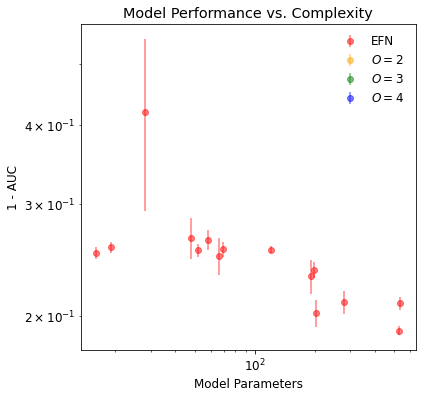

15 1 [ 2  7 13] 397
Epoch 1/50
150/150 - 2s - loss: 0.6914 - acc: 0.5385 - val_loss: 0.6747 - val_acc: 0.6945
Epoch 2/50
150/150 - 2s - loss: 0.6331 - acc: 0.6645 - val_loss: 0.6092 - val_acc: 0.6665
Epoch 3/50
150/150 - 2s - loss: 0.6046 - acc: 0.6769 - val_loss: 0.5873 - val_acc: 0.6950
Epoch 4/50
150/150 - 2s - loss: 0.5869 - acc: 0.6868 - val_loss: 0.5724 - val_acc: 0.7000
Epoch 5/50
150/150 - 2s - loss: 0.5789 - acc: 0.6906 - val_loss: 0.5684 - val_acc: 0.7045
Epoch 6/50
150/150 - 2s - loss: 0.5761 - acc: 0.6917 - val_loss: 0.5659 - val_acc: 0.7025
Epoch 7/50
150/150 - 2s - loss: 0.5755 - acc: 0.6920 - val_loss: 0.5655 - val_acc: 0.7090
Epoch 8/50
150/150 - 2s - loss: 0.5734 - acc: 0.6916 - val_loss: 0.5628 - val_acc: 0.7080
Epoch 9/50
150/150 - 2s - loss: 0.5730 - acc: 0.6925 - val_loss: 0.5627 - val_acc: 0.7070
Epoch 10/50
150/150 - 2s - loss: 0.5729 - acc: 0.6930 - val_loss: 0.5641 - val_acc: 0.7035
Epoch 11/50
150/150 - 2s - loss: 0.5721 - acc: 0.6934 - val_loss: 0.5626 - val_

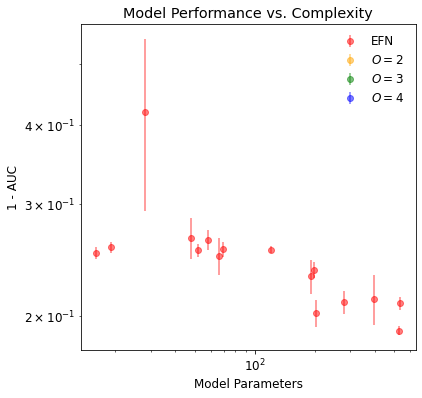

16 1 [22  4  3] 250
Epoch 1/50
150/150 - 5s - loss: 0.6507 - acc: 0.6319 - val_loss: 0.6179 - val_acc: 0.6570
Epoch 2/50
150/150 - 5s - loss: 0.6133 - acc: 0.6710 - val_loss: 0.6034 - val_acc: 0.6775
Epoch 3/50
150/150 - 5s - loss: 0.6025 - acc: 0.6784 - val_loss: 0.5923 - val_acc: 0.6995
Epoch 4/50
150/150 - 5s - loss: 0.5936 - acc: 0.6832 - val_loss: 0.5837 - val_acc: 0.7030
Epoch 5/50
150/150 - 5s - loss: 0.5870 - acc: 0.6854 - val_loss: 0.5798 - val_acc: 0.7000
Epoch 6/50
150/150 - 5s - loss: 0.5806 - acc: 0.6889 - val_loss: 0.5684 - val_acc: 0.7075
Epoch 7/50
150/150 - 5s - loss: 0.5745 - acc: 0.6927 - val_loss: 0.5648 - val_acc: 0.7105
Epoch 8/50
150/150 - 5s - loss: 0.5720 - acc: 0.6955 - val_loss: 0.5613 - val_acc: 0.7120
Epoch 9/50
150/150 - 5s - loss: 0.5705 - acc: 0.6964 - val_loss: 0.5599 - val_acc: 0.7120
Epoch 10/50
150/150 - 5s - loss: 0.5696 - acc: 0.6971 - val_loss: 0.5636 - val_acc: 0.7085
Epoch 11/50
150/150 - 5s - loss: 0.5691 - acc: 0.6968 - val_loss: 0.5610 - val_

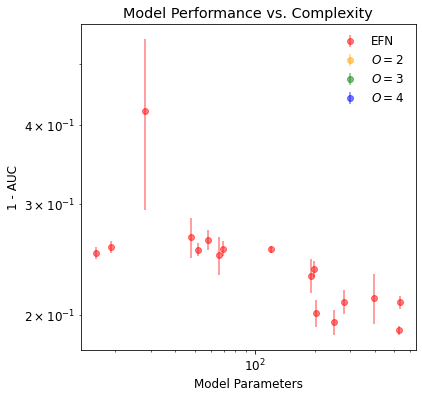

17 1 [1 6 4] 146
Epoch 1/50
150/150 - 1s - loss: 0.6934 - acc: 0.4980 - val_loss: 0.6930 - val_acc: 0.5375
Epoch 2/50
150/150 - 1s - loss: 0.6928 - acc: 0.5102 - val_loss: 0.6927 - val_acc: 0.4815
Epoch 3/50
150/150 - 1s - loss: 0.6887 - acc: 0.5670 - val_loss: 0.6800 - val_acc: 0.6525
Epoch 4/50
150/150 - 1s - loss: 0.6550 - acc: 0.6432 - val_loss: 0.6223 - val_acc: 0.6680
Epoch 5/50
150/150 - 1s - loss: 0.6248 - acc: 0.6582 - val_loss: 0.6098 - val_acc: 0.6790
Epoch 6/50
150/150 - 1s - loss: 0.6183 - acc: 0.6640 - val_loss: 0.6040 - val_acc: 0.6740
Epoch 7/50
150/150 - 1s - loss: 0.6101 - acc: 0.6724 - val_loss: 0.5965 - val_acc: 0.6860
Epoch 8/50
150/150 - 1s - loss: 0.6051 - acc: 0.6772 - val_loss: 0.5911 - val_acc: 0.7035
Epoch 9/50
150/150 - 1s - loss: 0.6001 - acc: 0.6803 - val_loss: 0.5861 - val_acc: 0.6960
Epoch 10/50
150/150 - 1s - loss: 0.5945 - acc: 0.6836 - val_loss: 0.5814 - val_acc: 0.6955
Epoch 11/50
150/150 - 1s - loss: 0.5891 - acc: 0.6857 - val_loss: 0.5748 - val_acc

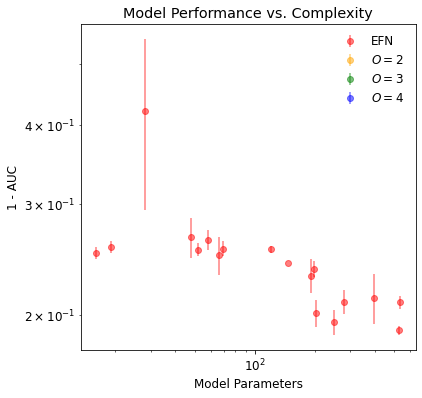

18 1 [5 1 1] 28
Epoch 1/50
150/150 - 2s - loss: 0.6930 - acc: 0.5265 - val_loss: 0.6927 - val_acc: 0.6940
Epoch 2/50
150/150 - 2s - loss: 0.6922 - acc: 0.6105 - val_loss: 0.6909 - val_acc: 0.6850
Epoch 3/50
150/150 - 2s - loss: 0.6828 - acc: 0.6294 - val_loss: 0.6502 - val_acc: 0.5910
Epoch 4/50
150/150 - 2s - loss: 0.5924 - acc: 0.6830 - val_loss: 0.5726 - val_acc: 0.7125
Epoch 5/50
150/150 - 2s - loss: 0.5774 - acc: 0.6959 - val_loss: 0.5681 - val_acc: 0.7115
Epoch 6/50
150/150 - 2s - loss: 0.5763 - acc: 0.6963 - val_loss: 0.5678 - val_acc: 0.7095
Epoch 7/50
150/150 - 2s - loss: 0.5759 - acc: 0.6978 - val_loss: 0.5681 - val_acc: 0.7090
Epoch 8/50
150/150 - 2s - loss: 0.5760 - acc: 0.6978 - val_loss: 0.5673 - val_acc: 0.7130
Epoch 9/50
150/150 - 2s - loss: 0.5756 - acc: 0.6983 - val_loss: 0.5693 - val_acc: 0.7110
Epoch 10/50
150/150 - 2s - loss: 0.5757 - acc: 0.6977 - val_loss: 0.5675 - val_acc: 0.7085
Epoch 11/50
150/150 - 2s - loss: 0.5757 - acc: 0.6980 - val_loss: 0.5680 - val_acc:

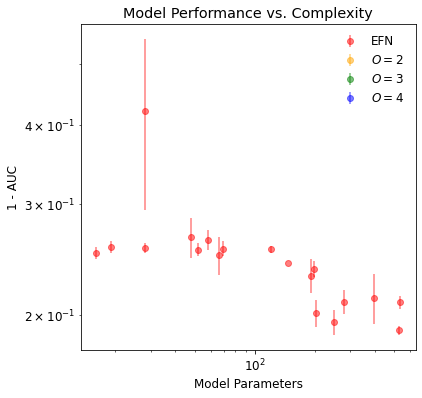

19 1 [16  1  2] 84
Epoch 1/50
150/150 - 4s - loss: 0.6839 - acc: 0.6200 - val_loss: 0.6599 - val_acc: 0.7085
Epoch 2/50
150/150 - 4s - loss: 0.6529 - acc: 0.6845 - val_loss: 0.6359 - val_acc: 0.6870
Epoch 3/50
150/150 - 4s - loss: 0.6426 - acc: 0.6718 - val_loss: 0.6311 - val_acc: 0.6800
Epoch 4/50
150/150 - 4s - loss: 0.6368 - acc: 0.6662 - val_loss: 0.6255 - val_acc: 0.6780
Epoch 5/50
150/150 - 4s - loss: 0.6308 - acc: 0.6683 - val_loss: 0.6200 - val_acc: 0.6825
Epoch 6/50
150/150 - 4s - loss: 0.6251 - acc: 0.6726 - val_loss: 0.6139 - val_acc: 0.6850
Epoch 7/50
150/150 - 4s - loss: 0.6199 - acc: 0.6757 - val_loss: 0.6095 - val_acc: 0.6885
Epoch 8/50
150/150 - 4s - loss: 0.6158 - acc: 0.6800 - val_loss: 0.6057 - val_acc: 0.6940
Epoch 9/50
150/150 - 4s - loss: 0.6123 - acc: 0.6820 - val_loss: 0.6020 - val_acc: 0.6980
Epoch 10/50
150/150 - 4s - loss: 0.6097 - acc: 0.6829 - val_loss: 0.5992 - val_acc: 0.6995
Epoch 11/50
150/150 - 4s - loss: 0.6073 - acc: 0.6833 - val_loss: 0.5973 - val_a

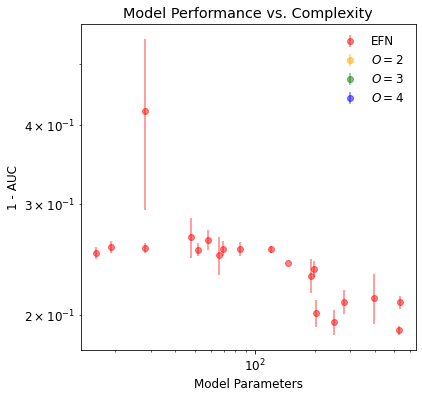

20 1 [20  1  2] 100
Epoch 1/50
150/150 - 5s - loss: 0.6887 - acc: 0.5866 - val_loss: 0.6709 - val_acc: 0.6760
Epoch 2/50
150/150 - 4s - loss: 0.6381 - acc: 0.6821 - val_loss: 0.6140 - val_acc: 0.6820
Epoch 3/50
150/150 - 5s - loss: 0.6140 - acc: 0.6750 - val_loss: 0.6042 - val_acc: 0.6910
Epoch 4/50
150/150 - 4s - loss: 0.6087 - acc: 0.6718 - val_loss: 0.6012 - val_acc: 0.6800
Epoch 5/50
150/150 - 4s - loss: 0.6062 - acc: 0.6727 - val_loss: 0.5990 - val_acc: 0.6830
Epoch 6/50
150/150 - 4s - loss: 0.6047 - acc: 0.6751 - val_loss: 0.5985 - val_acc: 0.6825
Epoch 7/50
150/150 - 4s - loss: 0.6038 - acc: 0.6762 - val_loss: 0.5985 - val_acc: 0.6835
Epoch 8/50
150/150 - 4s - loss: 0.6034 - acc: 0.6779 - val_loss: 0.5989 - val_acc: 0.6845
Epoch 9/50
150/150 - 4s - loss: 0.6032 - acc: 0.6797 - val_loss: 0.5972 - val_acc: 0.6880
Epoch 10/50
150/150 - 4s - loss: 0.6027 - acc: 0.6801 - val_loss: 0.5974 - val_acc: 0.6880
Epoch 11/50
150/150 - 4s - loss: 0.6029 - acc: 0.6799 - val_loss: 0.5962 - val_

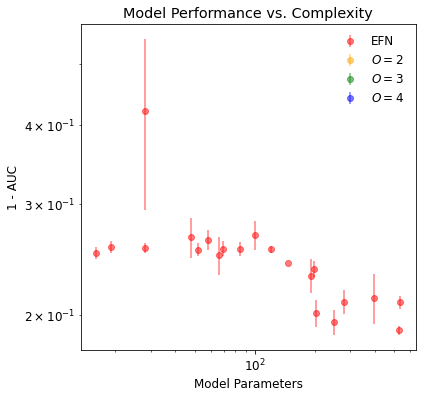

21 1 [10  2  1] 64
Epoch 1/50
150/150 - 3s - loss: 0.6865 - acc: 0.6004 - val_loss: 0.6705 - val_acc: 0.6560
Epoch 2/50
150/150 - 2s - loss: 0.6313 - acc: 0.6670 - val_loss: 0.6019 - val_acc: 0.6820
Epoch 3/50
150/150 - 2s - loss: 0.5968 - acc: 0.6840 - val_loss: 0.5847 - val_acc: 0.7005
Epoch 4/50
150/150 - 2s - loss: 0.5855 - acc: 0.6878 - val_loss: 0.5771 - val_acc: 0.7050
Epoch 5/50
150/150 - 2s - loss: 0.5812 - acc: 0.6901 - val_loss: 0.5772 - val_acc: 0.7060
Epoch 6/50
150/150 - 2s - loss: 0.5800 - acc: 0.6899 - val_loss: 0.5751 - val_acc: 0.7015
Epoch 7/50
150/150 - 2s - loss: 0.5803 - acc: 0.6897 - val_loss: 0.5759 - val_acc: 0.7080
Epoch 8/50
150/150 - 2s - loss: 0.5786 - acc: 0.6909 - val_loss: 0.5776 - val_acc: 0.6955
Epoch 9/50
150/150 - 2s - loss: 0.5783 - acc: 0.6913 - val_loss: 0.5761 - val_acc: 0.7095
Epoch 10/50
150/150 - 3s - loss: 0.5774 - acc: 0.6923 - val_loss: 0.5767 - val_acc: 0.7090
Epoch 11/50
150/150 - 2s - loss: 0.5775 - acc: 0.6918 - val_loss: 0.5732 - val_a

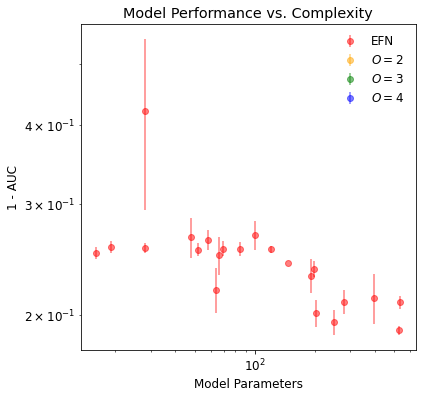

22 1 [13  1  1] 52
Epoch 1/50
150/150 - 3s - loss: 0.6931 - acc: 0.5217 - val_loss: 0.6926 - val_acc: 0.6995
Epoch 2/50
150/150 - 3s - loss: 0.6855 - acc: 0.6674 - val_loss: 0.6583 - val_acc: 0.7180
Epoch 3/50
150/150 - 3s - loss: 0.6562 - acc: 0.6786 - val_loss: 0.6389 - val_acc: 0.6915
Epoch 4/50
150/150 - 3s - loss: 0.6478 - acc: 0.6646 - val_loss: 0.6358 - val_acc: 0.6755
Epoch 5/50
150/150 - 3s - loss: 0.6440 - acc: 0.6569 - val_loss: 0.6330 - val_acc: 0.6720
Epoch 6/50
150/150 - 3s - loss: 0.6420 - acc: 0.6536 - val_loss: 0.6357 - val_acc: 0.6465
Epoch 7/50
150/150 - 3s - loss: 0.6405 - acc: 0.6497 - val_loss: 0.6312 - val_acc: 0.6620
Epoch 8/50
150/150 - 3s - loss: 0.6394 - acc: 0.6483 - val_loss: 0.6314 - val_acc: 0.6565
Epoch 9/50
150/150 - 3s - loss: 0.6384 - acc: 0.6468 - val_loss: 0.6310 - val_acc: 0.6550
Epoch 10/50
150/150 - 3s - loss: 0.6375 - acc: 0.6462 - val_loss: 0.6279 - val_acc: 0.6685
Epoch 11/50
150/150 - 3s - loss: 0.6366 - acc: 0.6461 - val_loss: 0.6264 - val_a

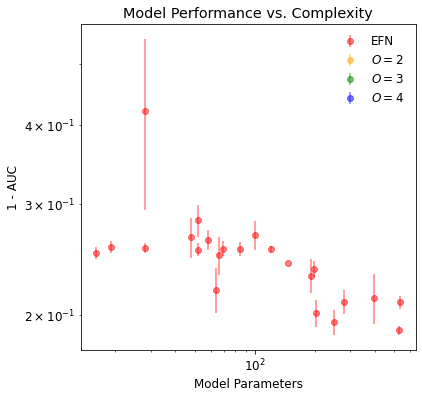

23 1 [9 7 8] 374
Epoch 1/50
150/150 - 3s - loss: 0.6795 - acc: 0.5821 - val_loss: 0.6102 - val_acc: 0.6620
Epoch 2/50
150/150 - 3s - loss: 0.5860 - acc: 0.6853 - val_loss: 0.5681 - val_acc: 0.7055
Epoch 3/50
150/150 - 3s - loss: 0.5778 - acc: 0.6907 - val_loss: 0.5661 - val_acc: 0.7100
Epoch 4/50
150/150 - 3s - loss: 0.5746 - acc: 0.6930 - val_loss: 0.5620 - val_acc: 0.7170
Epoch 5/50
150/150 - 3s - loss: 0.5721 - acc: 0.6941 - val_loss: 0.5632 - val_acc: 0.7165
Epoch 6/50
150/150 - 3s - loss: 0.5716 - acc: 0.6951 - val_loss: 0.5607 - val_acc: 0.7205
Epoch 7/50
150/150 - 3s - loss: 0.5705 - acc: 0.6964 - val_loss: 0.5606 - val_acc: 0.7195
Epoch 8/50
150/150 - 3s - loss: 0.5704 - acc: 0.6966 - val_loss: 0.5627 - val_acc: 0.7175
Epoch 9/50
150/150 - 3s - loss: 0.5697 - acc: 0.6971 - val_loss: 0.5598 - val_acc: 0.7165
Epoch 10/50
150/150 - 3s - loss: 0.5698 - acc: 0.6969 - val_loss: 0.5619 - val_acc: 0.7110
Epoch 11/50
150/150 - 3s - loss: 0.5694 - acc: 0.6968 - val_loss: 0.5617 - val_acc

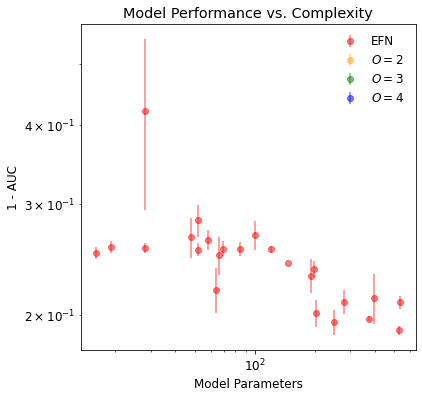

24 1 [4 3 2] 70
Epoch 1/50
150/150 - 2s - loss: 0.6955 - acc: 0.5261 - val_loss: 0.6885 - val_acc: 0.6290
Epoch 2/50
150/150 - 2s - loss: 0.6727 - acc: 0.6782 - val_loss: 0.6501 - val_acc: 0.6885
Epoch 3/50
150/150 - 2s - loss: 0.6440 - acc: 0.6611 - val_loss: 0.6348 - val_acc: 0.6440
Epoch 4/50
150/150 - 2s - loss: 0.6304 - acc: 0.6573 - val_loss: 0.6252 - val_acc: 0.6580
Epoch 5/50
150/150 - 2s - loss: 0.6264 - acc: 0.6601 - val_loss: 0.6205 - val_acc: 0.6760
Epoch 6/50
150/150 - 2s - loss: 0.6229 - acc: 0.6618 - val_loss: 0.6230 - val_acc: 0.6475
Epoch 7/50
150/150 - 2s - loss: 0.6198 - acc: 0.6648 - val_loss: 0.6133 - val_acc: 0.6780
Epoch 8/50
150/150 - 2s - loss: 0.6159 - acc: 0.6669 - val_loss: 0.6161 - val_acc: 0.6560
Epoch 9/50
150/150 - 2s - loss: 0.6134 - acc: 0.6679 - val_loss: 0.6061 - val_acc: 0.6810
Epoch 10/50
150/150 - 2s - loss: 0.6101 - acc: 0.6704 - val_loss: 0.6022 - val_acc: 0.6915
Epoch 11/50
150/150 - 2s - loss: 0.6075 - acc: 0.6715 - val_loss: 0.5995 - val_acc:

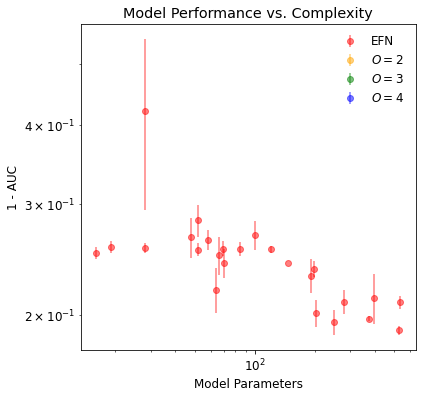

25 1 [1 1 1] 16
Epoch 1/50
150/150 - 1s - loss: 0.7084 - acc: 0.4981 - val_loss: 0.6910 - val_acc: 0.5375
Epoch 2/50
150/150 - 1s - loss: 0.6933 - acc: 0.5037 - val_loss: 0.6930 - val_acc: 0.5290
Epoch 3/50
150/150 - 1s - loss: 0.6929 - acc: 0.5108 - val_loss: 0.6929 - val_acc: 0.5535
Epoch 4/50
150/150 - 1s - loss: 0.6927 - acc: 0.5231 - val_loss: 0.6931 - val_acc: 0.4620
Epoch 5/50
150/150 - 1s - loss: 0.6925 - acc: 0.5306 - val_loss: 0.6930 - val_acc: 0.4620
Epoch 6/50
150/150 - 1s - loss: 0.6920 - acc: 0.5504 - val_loss: 0.6918 - val_acc: 0.5565
Epoch 7/50
150/150 - 1s - loss: 0.6911 - acc: 0.5548 - val_loss: 0.6918 - val_acc: 0.4880
Epoch 8/50
150/150 - 1s - loss: 0.6896 - acc: 0.5674 - val_loss: 0.6883 - val_acc: 0.6415
Epoch 9/50
150/150 - 1s - loss: 0.6872 - acc: 0.6088 - val_loss: 0.6854 - val_acc: 0.6080
Epoch 10/50
150/150 - 1s - loss: 0.6835 - acc: 0.6354 - val_loss: 0.6800 - val_acc: 0.6480
Epoch 11/50
150/150 - 1s - loss: 0.6785 - acc: 0.6467 - val_loss: 0.6733 - val_acc:

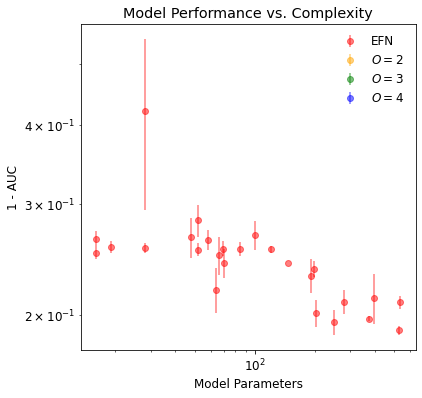

26 1 [12  4  2] 149
Epoch 1/50
150/150 - 3s - loss: 0.6922 - acc: 0.5611 - val_loss: 0.6880 - val_acc: 0.6640
Epoch 2/50
150/150 - 3s - loss: 0.6610 - acc: 0.6562 - val_loss: 0.6166 - val_acc: 0.6845
Epoch 3/50
150/150 - 3s - loss: 0.6081 - acc: 0.6738 - val_loss: 0.5894 - val_acc: 0.6950
Epoch 4/50
150/150 - 3s - loss: 0.5941 - acc: 0.6816 - val_loss: 0.5800 - val_acc: 0.7025
Epoch 5/50
150/150 - 3s - loss: 0.5857 - acc: 0.6865 - val_loss: 0.5687 - val_acc: 0.7075
Epoch 6/50
150/150 - 3s - loss: 0.5792 - acc: 0.6898 - val_loss: 0.5646 - val_acc: 0.7060
Epoch 7/50
150/150 - 3s - loss: 0.5761 - acc: 0.6908 - val_loss: 0.5615 - val_acc: 0.7145
Epoch 8/50
150/150 - 3s - loss: 0.5748 - acc: 0.6910 - val_loss: 0.5608 - val_acc: 0.7140
Epoch 9/50
150/150 - 3s - loss: 0.5726 - acc: 0.6929 - val_loss: 0.5586 - val_acc: 0.7130
Epoch 10/50
150/150 - 3s - loss: 0.5725 - acc: 0.6926 - val_loss: 0.5550 - val_acc: 0.7190
Epoch 11/50
150/150 - 3s - loss: 0.5713 - acc: 0.6937 - val_loss: 0.5575 - val_

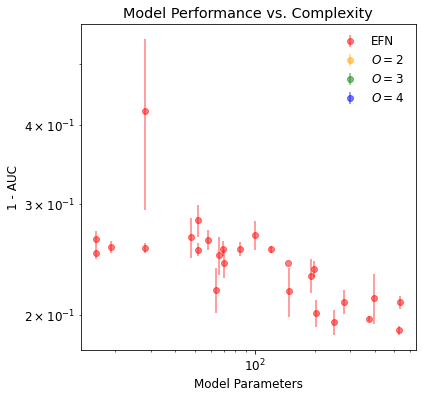

27 1 [1 3 8] 142
Epoch 1/50
150/150 - 1s - loss: 0.7029 - acc: 0.5284 - val_loss: 0.6913 - val_acc: 0.5875
Epoch 2/50
150/150 - 1s - loss: 0.6885 - acc: 0.5899 - val_loss: 0.6876 - val_acc: 0.5340
Epoch 3/50
150/150 - 1s - loss: 0.6767 - acc: 0.6008 - val_loss: 0.6586 - val_acc: 0.6230
Epoch 4/50
150/150 - 1s - loss: 0.6286 - acc: 0.6613 - val_loss: 0.5983 - val_acc: 0.6910
Epoch 5/50
150/150 - 1s - loss: 0.5997 - acc: 0.6793 - val_loss: 0.5855 - val_acc: 0.7035
Epoch 6/50
150/150 - 1s - loss: 0.5900 - acc: 0.6847 - val_loss: 0.5773 - val_acc: 0.7000
Epoch 7/50
150/150 - 2s - loss: 0.5841 - acc: 0.6887 - val_loss: 0.5723 - val_acc: 0.7020
Epoch 8/50
150/150 - 1s - loss: 0.5815 - acc: 0.6904 - val_loss: 0.5702 - val_acc: 0.7020
Epoch 9/50
150/150 - 1s - loss: 0.5796 - acc: 0.6915 - val_loss: 0.5674 - val_acc: 0.7020
Epoch 10/50
150/150 - 1s - loss: 0.5780 - acc: 0.6916 - val_loss: 0.5690 - val_acc: 0.7045
Epoch 11/50
150/150 - 1s - loss: 0.5770 - acc: 0.6918 - val_loss: 0.5657 - val_acc

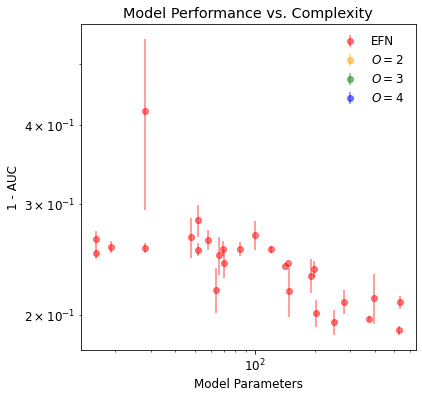

28 1 [18  5 12] 592
Epoch 1/50
150/150 - 5s - loss: 0.6687 - acc: 0.6259 - val_loss: 0.6219 - val_acc: 0.6600
Epoch 2/50
150/150 - 5s - loss: 0.6006 - acc: 0.6777 - val_loss: 0.5765 - val_acc: 0.6960
Epoch 3/50
150/150 - 5s - loss: 0.5781 - acc: 0.6903 - val_loss: 0.5705 - val_acc: 0.7040
Epoch 4/50
150/150 - 5s - loss: 0.5733 - acc: 0.6936 - val_loss: 0.5644 - val_acc: 0.7115
Epoch 5/50
150/150 - 5s - loss: 0.5712 - acc: 0.6943 - val_loss: 0.5612 - val_acc: 0.7115
Epoch 6/50
150/150 - 5s - loss: 0.5707 - acc: 0.6954 - val_loss: 0.5607 - val_acc: 0.7090
Epoch 7/50
150/150 - 5s - loss: 0.5699 - acc: 0.6960 - val_loss: 0.5615 - val_acc: 0.7130
Epoch 8/50
150/150 - 5s - loss: 0.5693 - acc: 0.6959 - val_loss: 0.5614 - val_acc: 0.7090
Epoch 9/50
150/150 - 5s - loss: 0.5692 - acc: 0.6956 - val_loss: 0.5629 - val_acc: 0.7130
Epoch 10/50
150/150 - 5s - loss: 0.5691 - acc: 0.6957 - val_loss: 0.5591 - val_acc: 0.7115
Epoch 11/50
150/150 - 5s - loss: 0.5689 - acc: 0.6965 - val_loss: 0.5617 - val_

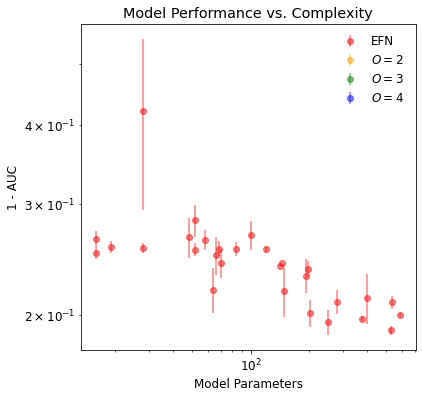

29 1 [11 15  2] 736
Epoch 1/50
150/150 - 3s - loss: 0.6556 - acc: 0.6451 - val_loss: 0.6015 - val_acc: 0.6885
Epoch 2/50
150/150 - 3s - loss: 0.5958 - acc: 0.6802 - val_loss: 0.5709 - val_acc: 0.7110
Epoch 3/50
150/150 - 3s - loss: 0.5795 - acc: 0.6894 - val_loss: 0.5678 - val_acc: 0.7075
Epoch 4/50
150/150 - 3s - loss: 0.5758 - acc: 0.6924 - val_loss: 0.5684 - val_acc: 0.7075
Epoch 5/50
150/150 - 3s - loss: 0.5737 - acc: 0.6942 - val_loss: 0.5599 - val_acc: 0.7160
Epoch 6/50
150/150 - 3s - loss: 0.5734 - acc: 0.6958 - val_loss: 0.5590 - val_acc: 0.7175
Epoch 7/50
150/150 - 3s - loss: 0.5725 - acc: 0.6953 - val_loss: 0.5607 - val_acc: 0.7175
Epoch 8/50
150/150 - 3s - loss: 0.5725 - acc: 0.6955 - val_loss: 0.5619 - val_acc: 0.7135
Epoch 9/50
150/150 - 3s - loss: 0.5722 - acc: 0.6957 - val_loss: 0.5618 - val_acc: 0.7170
Epoch 10/50
150/150 - 3s - loss: 0.5710 - acc: 0.6962 - val_loss: 0.5633 - val_acc: 0.7165
Epoch 11/50
150/150 - 3s - loss: 0.5717 - acc: 0.6961 - val_loss: 0.5626 - val_

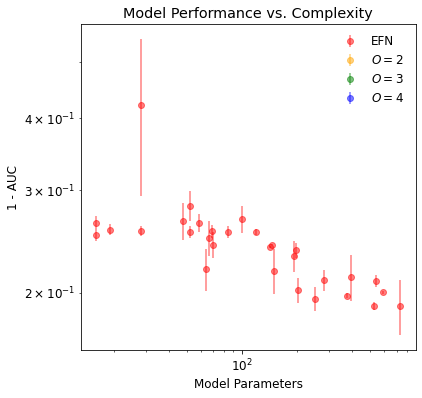

0 2 [1 1 2] 25
Epoch 1/50
150/150 - 1s - loss: 0.6922 - acc: 0.5273 - val_loss: 0.6863 - val_acc: 0.5375
Epoch 2/50
150/150 - 1s - loss: 0.6762 - acc: 0.6309 - val_loss: 0.6568 - val_acc: 0.6700
Epoch 3/50
150/150 - 1s - loss: 0.6630 - acc: 0.6541 - val_loss: 0.6562 - val_acc: 0.6275
Epoch 4/50
150/150 - 1s - loss: 0.6606 - acc: 0.6394 - val_loss: 0.6540 - val_acc: 0.6315
Epoch 5/50
150/150 - 1s - loss: 0.6594 - acc: 0.6335 - val_loss: 0.6536 - val_acc: 0.6245
Epoch 6/50
150/150 - 1s - loss: 0.6588 - acc: 0.6314 - val_loss: 0.6548 - val_acc: 0.6120
Epoch 7/50
150/150 - 1s - loss: 0.6582 - acc: 0.6287 - val_loss: 0.6556 - val_acc: 0.6060
Epoch 8/50
150/150 - 1s - loss: 0.6578 - acc: 0.6282 - val_loss: 0.6510 - val_acc: 0.6370
Epoch 9/50
150/150 - 1s - loss: 0.6574 - acc: 0.6290 - val_loss: 0.6517 - val_acc: 0.6265
Epoch 10/50
150/150 - 1s - loss: 0.6570 - acc: 0.6291 - val_loss: 0.6556 - val_acc: 0.6020
Epoch 11/50
150/150 - 1s - loss: 0.6567 - acc: 0.6290 - val_loss: 0.6548 - val_acc: 

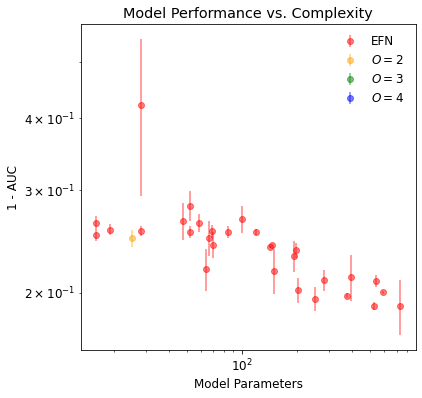

1 2 [2 3 5] 106
Epoch 1/50
150/150 - 2s - loss: 0.6900 - acc: 0.5329 - val_loss: 0.6782 - val_acc: 0.5905
Epoch 2/50
150/150 - 2s - loss: 0.6276 - acc: 0.6654 - val_loss: 0.5982 - val_acc: 0.6920
Epoch 3/50
150/150 - 2s - loss: 0.5892 - acc: 0.6906 - val_loss: 0.5832 - val_acc: 0.7005
Epoch 4/50
150/150 - 2s - loss: 0.5827 - acc: 0.6922 - val_loss: 0.5779 - val_acc: 0.7005
Epoch 5/50
150/150 - 2s - loss: 0.5800 - acc: 0.6914 - val_loss: 0.5764 - val_acc: 0.7025
Epoch 6/50
150/150 - 2s - loss: 0.5789 - acc: 0.6916 - val_loss: 0.5750 - val_acc: 0.7025
Epoch 7/50
150/150 - 2s - loss: 0.5771 - acc: 0.6920 - val_loss: 0.5742 - val_acc: 0.7030
Epoch 8/50
150/150 - 2s - loss: 0.5762 - acc: 0.6924 - val_loss: 0.5696 - val_acc: 0.7065
Epoch 9/50
150/150 - 2s - loss: 0.5764 - acc: 0.6916 - val_loss: 0.5739 - val_acc: 0.7040
Epoch 10/50
150/150 - 2s - loss: 0.5755 - acc: 0.6927 - val_loss: 0.5700 - val_acc: 0.7040
Epoch 11/50
150/150 - 2s - loss: 0.5755 - acc: 0.6920 - val_loss: 0.5697 - val_acc:

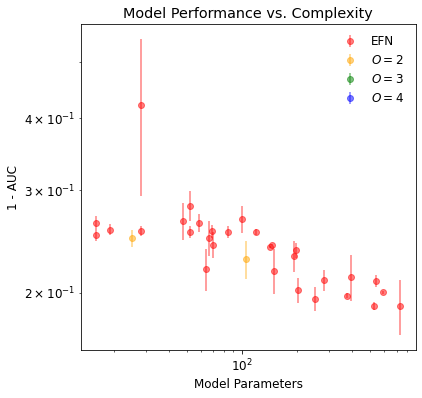

2 2 [ 2 15  9] 738
Epoch 1/50
150/150 - 2s - loss: 0.6948 - acc: 0.5204 - val_loss: 0.6861 - val_acc: 0.6325
Epoch 2/50
150/150 - 2s - loss: 0.6407 - acc: 0.6579 - val_loss: 0.5991 - val_acc: 0.6880
Epoch 3/50
150/150 - 2s - loss: 0.5883 - acc: 0.6889 - val_loss: 0.5793 - val_acc: 0.6960
Epoch 4/50
150/150 - 2s - loss: 0.5792 - acc: 0.6927 - val_loss: 0.5747 - val_acc: 0.7050
Epoch 5/50
150/150 - 2s - loss: 0.5763 - acc: 0.6938 - val_loss: 0.5711 - val_acc: 0.7025
Epoch 6/50
150/150 - 2s - loss: 0.5731 - acc: 0.6950 - val_loss: 0.5698 - val_acc: 0.7015
Epoch 7/50
150/150 - 2s - loss: 0.5702 - acc: 0.6967 - val_loss: 0.5635 - val_acc: 0.7065
Epoch 8/50
150/150 - 2s - loss: 0.5664 - acc: 0.7005 - val_loss: 0.5587 - val_acc: 0.7125
Epoch 9/50
150/150 - 2s - loss: 0.5625 - acc: 0.7064 - val_loss: 0.5512 - val_acc: 0.7240
Epoch 10/50
150/150 - 2s - loss: 0.5576 - acc: 0.7150 - val_loss: 0.5444 - val_acc: 0.7295
Epoch 11/50
150/150 - 2s - loss: 0.5541 - acc: 0.7179 - val_loss: 0.5431 - val_a

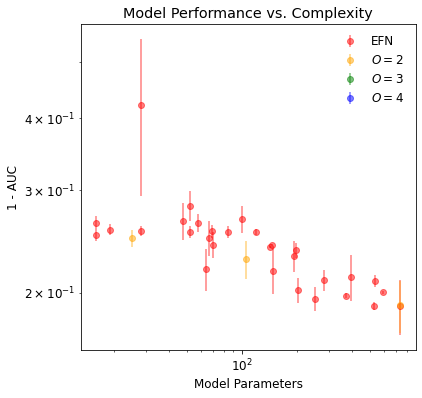

3 2 [1 3 6] 107
Epoch 1/50
150/150 - 2s - loss: 0.7128 - acc: 0.5387 - val_loss: 0.6861 - val_acc: 0.5610
Epoch 2/50
150/150 - 2s - loss: 0.6781 - acc: 0.5967 - val_loss: 0.6703 - val_acc: 0.6195
Epoch 3/50
150/150 - 2s - loss: 0.6495 - acc: 0.6499 - val_loss: 0.6252 - val_acc: 0.6735
Epoch 4/50
150/150 - 2s - loss: 0.6122 - acc: 0.6800 - val_loss: 0.6000 - val_acc: 0.7025
Epoch 5/50
150/150 - 2s - loss: 0.6009 - acc: 0.6859 - val_loss: 0.5922 - val_acc: 0.7020
Epoch 6/50
150/150 - 2s - loss: 0.5950 - acc: 0.6899 - val_loss: 0.5890 - val_acc: 0.7050
Epoch 7/50
150/150 - 2s - loss: 0.5918 - acc: 0.6918 - val_loss: 0.5864 - val_acc: 0.7050
Epoch 8/50
150/150 - 2s - loss: 0.5897 - acc: 0.6928 - val_loss: 0.5866 - val_acc: 0.7045
Epoch 9/50
150/150 - 2s - loss: 0.5875 - acc: 0.6937 - val_loss: 0.5827 - val_acc: 0.7055
Epoch 10/50
150/150 - 2s - loss: 0.5854 - acc: 0.6952 - val_loss: 0.5833 - val_acc: 0.7070
Epoch 11/50
150/150 - 2s - loss: 0.5837 - acc: 0.6957 - val_loss: 0.5812 - val_acc:

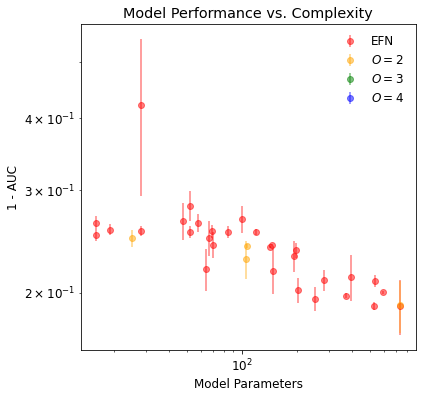

4 2 [ 8  2 10] 335
Epoch 1/50
150/150 - 10s - loss: 0.6791 - acc: 0.5835 - val_loss: 0.6389 - val_acc: 0.6680
Epoch 2/50
150/150 - 10s - loss: 0.5930 - acc: 0.6887 - val_loss: 0.5841 - val_acc: 0.7035
Epoch 3/50
150/150 - 10s - loss: 0.5813 - acc: 0.6925 - val_loss: 0.5763 - val_acc: 0.7040
Epoch 4/50
150/150 - 10s - loss: 0.5784 - acc: 0.6922 - val_loss: 0.5738 - val_acc: 0.7065
Epoch 5/50
150/150 - 10s - loss: 0.5790 - acc: 0.6922 - val_loss: 0.5802 - val_acc: 0.6975
Epoch 6/50
150/150 - 10s - loss: 0.5770 - acc: 0.6926 - val_loss: 0.5709 - val_acc: 0.7085
Epoch 7/50
150/150 - 10s - loss: 0.5761 - acc: 0.6939 - val_loss: 0.5690 - val_acc: 0.7105
Epoch 8/50
150/150 - 10s - loss: 0.5749 - acc: 0.6944 - val_loss: 0.5670 - val_acc: 0.7130
Epoch 9/50
150/150 - 10s - loss: 0.5739 - acc: 0.6963 - val_loss: 0.5647 - val_acc: 0.7180
Epoch 10/50
150/150 - 10s - loss: 0.5713 - acc: 0.6984 - val_loss: 0.5594 - val_acc: 0.7225
Epoch 11/50
150/150 - 10s - loss: 0.5701 - acc: 0.7003 - val_loss: 0.5

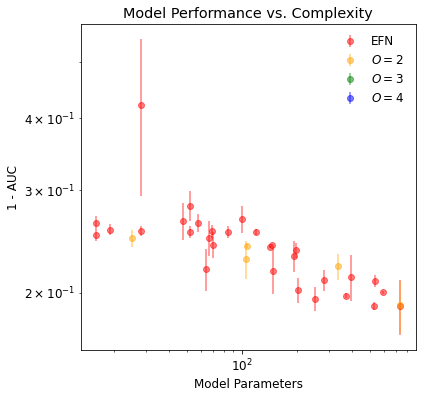

5 2 [1 1 1] 17
Epoch 1/50
150/150 - 1s - loss: 0.6945 - acc: 0.4981 - val_loss: 0.6930 - val_acc: 0.5375
Epoch 2/50
150/150 - 1s - loss: 0.6932 - acc: 0.5012 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 3/50
150/150 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6938 - val_acc: 0.4625
Epoch 4/50
150/150 - 1s - loss: 0.6932 - acc: 0.5009 - val_loss: 0.6933 - val_acc: 0.4625
Epoch 5/50
150/150 - 1s - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 6/50
150/150 - 1s - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6935 - val_acc: 0.4625
Epoch 7/50
150/150 - 1s - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6932 - val_acc: 0.4625
Epoch 8/50
150/150 - 1s - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.4625
Epoch 9/50
150/150 - 1s - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6933 - val_acc: 0.4625
Epoch 10/50
150/150 - 1s - loss: 0.6932 - acc: 0.5028 - val_loss: 0.6927 - val_acc: 0.5375
Epoch 11/50
150/150 - 1s - loss: 0.6932 - acc: 0.5006 - val_loss: 0.6927 - val_acc: 

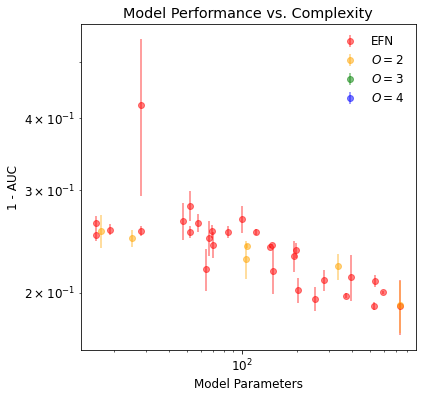

6 2 [ 4 10  2] 415
Epoch 1/50
150/150 - 3s - loss: 0.6927 - acc: 0.5335 - val_loss: 0.6861 - val_acc: 0.6470
Epoch 2/50
150/150 - 3s - loss: 0.6414 - acc: 0.6557 - val_loss: 0.6010 - val_acc: 0.6840
Epoch 3/50
150/150 - 3s - loss: 0.5941 - acc: 0.6828 - val_loss: 0.5795 - val_acc: 0.7070
Epoch 4/50
150/150 - 3s - loss: 0.5831 - acc: 0.6890 - val_loss: 0.5764 - val_acc: 0.7095
Epoch 5/50
150/150 - 3s - loss: 0.5810 - acc: 0.6903 - val_loss: 0.5719 - val_acc: 0.7125
Epoch 6/50
150/150 - 3s - loss: 0.5799 - acc: 0.6918 - val_loss: 0.5720 - val_acc: 0.7085
Epoch 7/50
150/150 - 3s - loss: 0.5795 - acc: 0.6918 - val_loss: 0.5709 - val_acc: 0.7120
Epoch 8/50
150/150 - 3s - loss: 0.5791 - acc: 0.6914 - val_loss: 0.5718 - val_acc: 0.7140
Epoch 9/50
150/150 - 3s - loss: 0.5782 - acc: 0.6924 - val_loss: 0.5697 - val_acc: 0.7140
Epoch 10/50
150/150 - 3s - loss: 0.5779 - acc: 0.6918 - val_loss: 0.5710 - val_acc: 0.7115
Epoch 11/50
150/150 - 3s - loss: 0.5780 - acc: 0.6928 - val_loss: 0.5714 - val_a

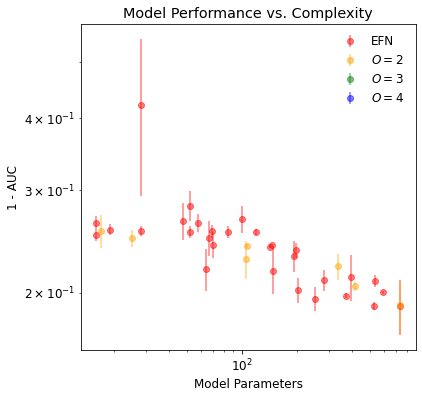

7 2 [1 1 4] 47
Epoch 1/50
150/150 - 1s - loss: 0.6928 - acc: 0.5031 - val_loss: 0.6935 - val_acc: 0.4625
Epoch 2/50
150/150 - 1s - loss: 0.6890 - acc: 0.5156 - val_loss: 0.6858 - val_acc: 0.5245
Epoch 3/50
150/150 - 1s - loss: 0.6695 - acc: 0.5949 - val_loss: 0.6565 - val_acc: 0.6030
Epoch 4/50
150/150 - 2s - loss: 0.6518 - acc: 0.6152 - val_loss: 0.6464 - val_acc: 0.6035
Epoch 5/50
150/150 - 1s - loss: 0.6427 - acc: 0.6250 - val_loss: 0.6351 - val_acc: 0.6265
Epoch 6/50
150/150 - 1s - loss: 0.6335 - acc: 0.6350 - val_loss: 0.6235 - val_acc: 0.6510
Epoch 7/50
150/150 - 2s - loss: 0.6253 - acc: 0.6441 - val_loss: 0.6150 - val_acc: 0.6620
Epoch 8/50
150/150 - 1s - loss: 0.6184 - acc: 0.6513 - val_loss: 0.6062 - val_acc: 0.6700
Epoch 9/50
150/150 - 1s - loss: 0.6139 - acc: 0.6557 - val_loss: 0.6012 - val_acc: 0.6700
Epoch 10/50
150/150 - 1s - loss: 0.6105 - acc: 0.6595 - val_loss: 0.5985 - val_acc: 0.6715
Epoch 11/50
150/150 - 1s - loss: 0.6078 - acc: 0.6614 - val_loss: 0.5957 - val_acc: 

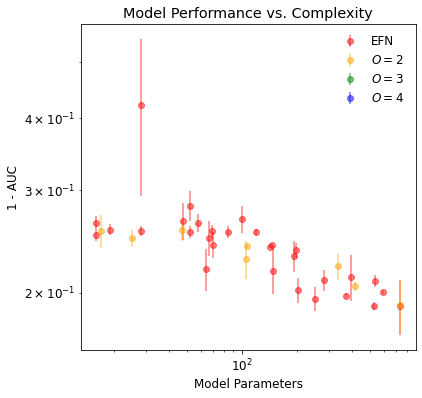

8 2 [1 2 2] 38
Epoch 1/50
150/150 - 1s - loss: 0.6892 - acc: 0.5288 - val_loss: 0.6805 - val_acc: 0.5700
Epoch 2/50
150/150 - 1s - loss: 0.6490 - acc: 0.6453 - val_loss: 0.6338 - val_acc: 0.6570
Epoch 3/50
150/150 - 1s - loss: 0.6197 - acc: 0.6697 - val_loss: 0.6166 - val_acc: 0.6810
Epoch 4/50
150/150 - 1s - loss: 0.6039 - acc: 0.6847 - val_loss: 0.5991 - val_acc: 0.6910
Epoch 5/50
150/150 - 1s - loss: 0.5926 - acc: 0.6881 - val_loss: 0.5889 - val_acc: 0.6950
Epoch 6/50
150/150 - 1s - loss: 0.5872 - acc: 0.6890 - val_loss: 0.5840 - val_acc: 0.6990
Epoch 7/50
150/150 - 1s - loss: 0.5858 - acc: 0.6891 - val_loss: 0.5814 - val_acc: 0.6990
Epoch 8/50
150/150 - 1s - loss: 0.5842 - acc: 0.6895 - val_loss: 0.5806 - val_acc: 0.7005
Epoch 9/50
150/150 - 1s - loss: 0.5836 - acc: 0.6900 - val_loss: 0.5793 - val_acc: 0.7015
Epoch 10/50
150/150 - 1s - loss: 0.5831 - acc: 0.6901 - val_loss: 0.5789 - val_acc: 0.7015
Epoch 11/50
150/150 - 1s - loss: 0.5826 - acc: 0.6902 - val_loss: 0.5783 - val_acc: 

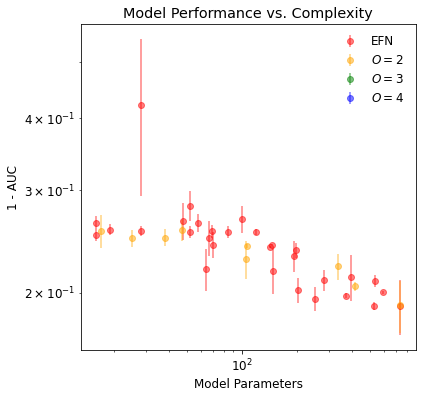

9 2 [7 1 2] 76
Epoch 1/50
150/150 - 8s - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6933 - val_acc: 0.4625
Epoch 2/50
150/150 - 8s - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6936 - val_acc: 0.4625
Epoch 3/50
150/150 - 8s - loss: 0.6787 - acc: 0.5532 - val_loss: 0.6468 - val_acc: 0.6395
Epoch 4/50
150/150 - 8s - loss: 0.5983 - acc: 0.6844 - val_loss: 0.5838 - val_acc: 0.7015
Epoch 5/50
150/150 - 8s - loss: 0.5831 - acc: 0.6923 - val_loss: 0.5779 - val_acc: 0.7050
Epoch 6/50
150/150 - 8s - loss: 0.5814 - acc: 0.6928 - val_loss: 0.5766 - val_acc: 0.7030
Epoch 7/50
150/150 - 8s - loss: 0.5808 - acc: 0.6919 - val_loss: 0.5764 - val_acc: 0.7020
Epoch 8/50
150/150 - 8s - loss: 0.5795 - acc: 0.6921 - val_loss: 0.5745 - val_acc: 0.7020
Epoch 9/50
150/150 - 8s - loss: 0.5789 - acc: 0.6925 - val_loss: 0.5715 - val_acc: 0.7000
Epoch 10/50
150/150 - 8s - loss: 0.5786 - acc: 0.6913 - val_loss: 0.5706 - val_acc: 0.7025
Epoch 11/50
150/150 - 8s - loss: 0.5780 - acc: 0.6922 - val_loss: 0.5723 - val_acc: 

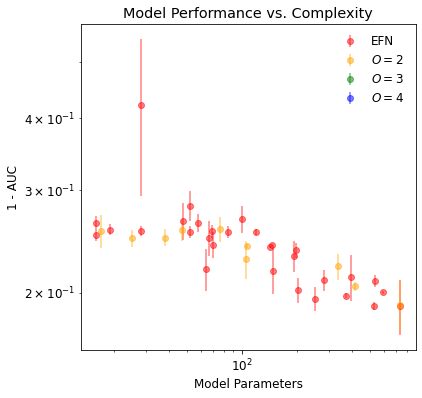

10 2 [10  3  1] 254
Epoch 1/50
150/150 - 14s - loss: 0.6647 - acc: 0.6544 - val_loss: 0.6317 - val_acc: 0.6720
Epoch 2/50
150/150 - 14s - loss: 0.6275 - acc: 0.6698 - val_loss: 0.6090 - val_acc: 0.6855
Epoch 3/50
150/150 - 14s - loss: 0.6055 - acc: 0.6819 - val_loss: 0.5943 - val_acc: 0.6990
Epoch 4/50
150/150 - 14s - loss: 0.5923 - acc: 0.6881 - val_loss: 0.5845 - val_acc: 0.7000
Epoch 5/50
150/150 - 14s - loss: 0.5893 - acc: 0.6893 - val_loss: 0.5835 - val_acc: 0.7075
Epoch 6/50
150/150 - 14s - loss: 0.5862 - acc: 0.6905 - val_loss: 0.5789 - val_acc: 0.7035
Epoch 7/50
150/150 - 14s - loss: 0.5847 - acc: 0.6912 - val_loss: 0.5797 - val_acc: 0.7075
Epoch 8/50
150/150 - 14s - loss: 0.5830 - acc: 0.6925 - val_loss: 0.5786 - val_acc: 0.7030
Epoch 9/50
150/150 - 14s - loss: 0.5820 - acc: 0.6928 - val_loss: 0.5791 - val_acc: 0.7050
Epoch 10/50
150/150 - 14s - loss: 0.5817 - acc: 0.6929 - val_loss: 0.5767 - val_acc: 0.7005
Epoch 11/50
150/150 - 14s - loss: 0.5807 - acc: 0.6923 - val_loss: 0.

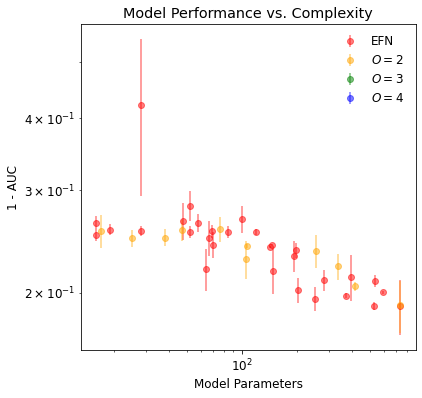

11 2 [2 9 8] 367
Epoch 1/50
150/150 - 2s - loss: 0.6894 - acc: 0.5290 - val_loss: 0.6649 - val_acc: 0.6040
Epoch 2/50
150/150 - 2s - loss: 0.6255 - acc: 0.6587 - val_loss: 0.5992 - val_acc: 0.6985
Epoch 3/50
150/150 - 2s - loss: 0.6038 - acc: 0.6733 - val_loss: 0.5935 - val_acc: 0.6885
Epoch 4/50
150/150 - 2s - loss: 0.5952 - acc: 0.6792 - val_loss: 0.5791 - val_acc: 0.7015
Epoch 5/50
150/150 - 2s - loss: 0.5888 - acc: 0.6815 - val_loss: 0.5743 - val_acc: 0.7000
Epoch 6/50
150/150 - 2s - loss: 0.5843 - acc: 0.6850 - val_loss: 0.5684 - val_acc: 0.7085
Epoch 7/50
150/150 - 2s - loss: 0.5807 - acc: 0.6886 - val_loss: 0.5653 - val_acc: 0.7130
Epoch 8/50
150/150 - 2s - loss: 0.5769 - acc: 0.6914 - val_loss: 0.5616 - val_acc: 0.7130
Epoch 9/50
150/150 - 2s - loss: 0.5732 - acc: 0.6927 - val_loss: 0.5586 - val_acc: 0.7185
Epoch 10/50
150/150 - 2s - loss: 0.5713 - acc: 0.6944 - val_loss: 0.5575 - val_acc: 0.7190
Epoch 11/50
150/150 - 2s - loss: 0.5713 - acc: 0.6944 - val_loss: 0.5604 - val_acc

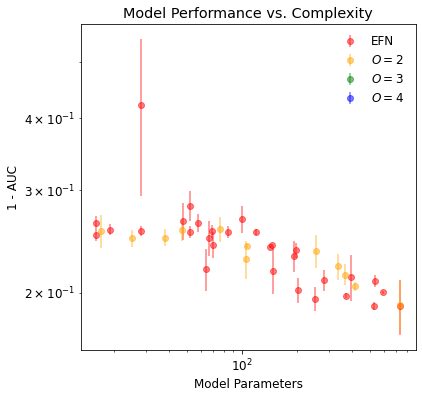

12 2 [1 1 1] 17
Epoch 1/50
150/150 - 1s - loss: 0.6932 - acc: 0.4989 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 2/50
150/150 - 1s - loss: 0.6931 - acc: 0.4999 - val_loss: 0.6931 - val_acc: 0.5910
Epoch 3/50
150/150 - 1s - loss: 0.6931 - acc: 0.5026 - val_loss: 0.6935 - val_acc: 0.4625
Epoch 4/50
150/150 - 1s - loss: 0.6931 - acc: 0.5145 - val_loss: 0.6932 - val_acc: 0.4625
Epoch 5/50
150/150 - 1s - loss: 0.6924 - acc: 0.5368 - val_loss: 0.6895 - val_acc: 0.5375
Epoch 6/50
150/150 - 1s - loss: 0.6761 - acc: 0.6222 - val_loss: 0.6543 - val_acc: 0.6755
Epoch 7/50
150/150 - 1s - loss: 0.6580 - acc: 0.6595 - val_loss: 0.6500 - val_acc: 0.6440
Epoch 8/50
150/150 - 1s - loss: 0.6541 - acc: 0.6469 - val_loss: 0.6495 - val_acc: 0.6245
Epoch 9/50
150/150 - 1s - loss: 0.6517 - acc: 0.6406 - val_loss: 0.6473 - val_acc: 0.6250
Epoch 10/50
150/150 - 1s - loss: 0.6497 - acc: 0.6411 - val_loss: 0.6470 - val_acc: 0.6215
Epoch 11/50
150/150 - 1s - loss: 0.6479 - acc: 0.6400 - val_loss: 0.6446 - val_acc:

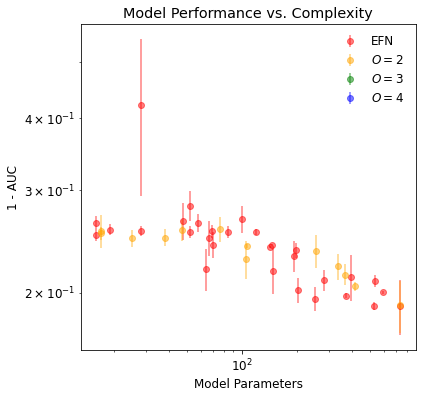

13 2 [4 3 2] 100
Epoch 1/50
150/150 - 3s - loss: 0.6882 - acc: 0.5537 - val_loss: 0.6797 - val_acc: 0.6005
Epoch 2/50
150/150 - 3s - loss: 0.6425 - acc: 0.6597 - val_loss: 0.6020 - val_acc: 0.6890
Epoch 3/50
150/150 - 3s - loss: 0.5958 - acc: 0.6851 - val_loss: 0.5832 - val_acc: 0.7020
Epoch 4/50
150/150 - 3s - loss: 0.5852 - acc: 0.6891 - val_loss: 0.5803 - val_acc: 0.7005
Epoch 5/50
150/150 - 3s - loss: 0.5801 - acc: 0.6904 - val_loss: 0.5725 - val_acc: 0.7000
Epoch 6/50
150/150 - 3s - loss: 0.5773 - acc: 0.6911 - val_loss: 0.5705 - val_acc: 0.7080
Epoch 7/50
150/150 - 3s - loss: 0.5759 - acc: 0.6917 - val_loss: 0.5688 - val_acc: 0.7035
Epoch 8/50
150/150 - 3s - loss: 0.5757 - acc: 0.6910 - val_loss: 0.5752 - val_acc: 0.6980
Epoch 9/50
150/150 - 3s - loss: 0.5751 - acc: 0.6914 - val_loss: 0.5651 - val_acc: 0.7090
Epoch 10/50
150/150 - 3s - loss: 0.5746 - acc: 0.6921 - val_loss: 0.5696 - val_acc: 0.7010
Epoch 11/50
150/150 - 3s - loss: 0.5745 - acc: 0.6924 - val_loss: 0.5681 - val_acc

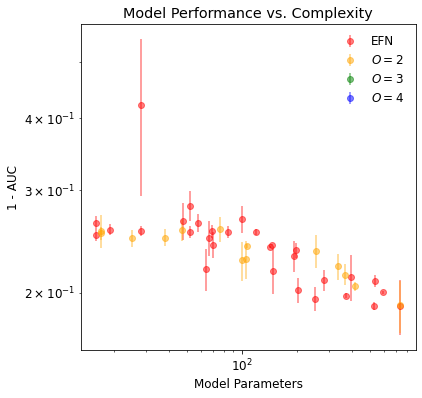

14 2 [1 2 2] 38
Epoch 1/50
150/150 - 1s - loss: 0.6911 - acc: 0.5384 - val_loss: 0.6837 - val_acc: 0.6145
Epoch 2/50
150/150 - 1s - loss: 0.6557 - acc: 0.6697 - val_loss: 0.6291 - val_acc: 0.6805
Epoch 3/50
150/150 - 1s - loss: 0.6194 - acc: 0.6781 - val_loss: 0.6101 - val_acc: 0.6800
Epoch 4/50
150/150 - 1s - loss: 0.6077 - acc: 0.6810 - val_loss: 0.6014 - val_acc: 0.6880
Epoch 5/50
150/150 - 1s - loss: 0.6031 - acc: 0.6839 - val_loss: 0.5959 - val_acc: 0.6970
Epoch 6/50
150/150 - 1s - loss: 0.6006 - acc: 0.6848 - val_loss: 0.5943 - val_acc: 0.6955
Epoch 7/50
150/150 - 1s - loss: 0.5988 - acc: 0.6863 - val_loss: 0.5950 - val_acc: 0.6940
Epoch 8/50
150/150 - 1s - loss: 0.5969 - acc: 0.6874 - val_loss: 0.5909 - val_acc: 0.6980
Epoch 9/50
150/150 - 1s - loss: 0.5960 - acc: 0.6882 - val_loss: 0.5909 - val_acc: 0.6965
Epoch 10/50
150/150 - 1s - loss: 0.5942 - acc: 0.6896 - val_loss: 0.5883 - val_acc: 0.7010
Epoch 11/50
150/150 - 1s - loss: 0.5934 - acc: 0.6902 - val_loss: 0.5883 - val_acc:

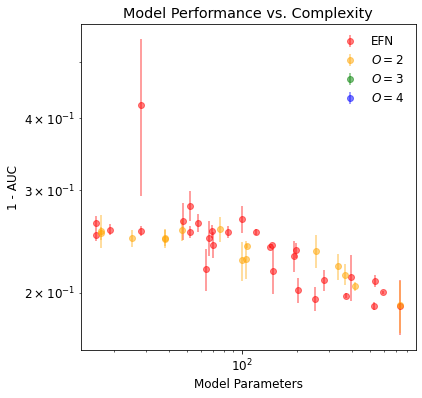

15 2 [3 4 1] 100
Epoch 1/50
150/150 - 3s - loss: 0.6918 - acc: 0.5504 - val_loss: 0.6860 - val_acc: 0.6560
Epoch 2/50
150/150 - 2s - loss: 0.6453 - acc: 0.6604 - val_loss: 0.5894 - val_acc: 0.6975
Epoch 3/50
150/150 - 2s - loss: 0.5967 - acc: 0.6873 - val_loss: 0.5813 - val_acc: 0.7050
Epoch 4/50
150/150 - 2s - loss: 0.5904 - acc: 0.6910 - val_loss: 0.5782 - val_acc: 0.7055
Epoch 5/50
150/150 - 2s - loss: 0.5862 - acc: 0.6928 - val_loss: 0.5737 - val_acc: 0.7150
Epoch 6/50
150/150 - 2s - loss: 0.5835 - acc: 0.6931 - val_loss: 0.5750 - val_acc: 0.7050
Epoch 7/50
150/150 - 2s - loss: 0.5803 - acc: 0.6935 - val_loss: 0.5700 - val_acc: 0.7070
Epoch 8/50
150/150 - 2s - loss: 0.5768 - acc: 0.6959 - val_loss: 0.5628 - val_acc: 0.7120
Epoch 9/50
150/150 - 2s - loss: 0.5740 - acc: 0.6969 - val_loss: 0.5637 - val_acc: 0.7175
Epoch 10/50
150/150 - 2s - loss: 0.5720 - acc: 0.6989 - val_loss: 0.5602 - val_acc: 0.7165
Epoch 11/50
150/150 - 2s - loss: 0.5707 - acc: 0.7003 - val_loss: 0.5578 - val_acc

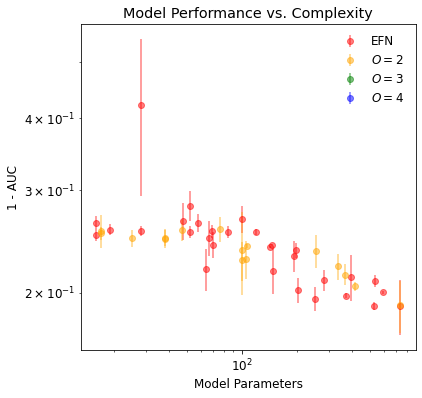

16 2 [1 6 2] 130
Epoch 1/50
150/150 - 2s - loss: 0.6932 - acc: 0.5101 - val_loss: 0.6924 - val_acc: 0.5055
Epoch 2/50
150/150 - 1s - loss: 0.6653 - acc: 0.6306 - val_loss: 0.6213 - val_acc: 0.6780
Epoch 3/50
150/150 - 1s - loss: 0.6145 - acc: 0.6715 - val_loss: 0.5941 - val_acc: 0.6950
Epoch 4/50
150/150 - 1s - loss: 0.5903 - acc: 0.6879 - val_loss: 0.5727 - val_acc: 0.7125
Epoch 5/50
150/150 - 1s - loss: 0.5792 - acc: 0.6929 - val_loss: 0.5699 - val_acc: 0.7160
Epoch 6/50
150/150 - 1s - loss: 0.5765 - acc: 0.6949 - val_loss: 0.5666 - val_acc: 0.7220
Epoch 7/50
150/150 - 1s - loss: 0.5751 - acc: 0.6948 - val_loss: 0.5650 - val_acc: 0.7170
Epoch 8/50
150/150 - 1s - loss: 0.5751 - acc: 0.6941 - val_loss: 0.5654 - val_acc: 0.7230
Epoch 9/50
150/150 - 1s - loss: 0.5739 - acc: 0.6948 - val_loss: 0.5648 - val_acc: 0.7195
Epoch 10/50
150/150 - 1s - loss: 0.5737 - acc: 0.6944 - val_loss: 0.5673 - val_acc: 0.7215
Epoch 11/50
150/150 - 1s - loss: 0.5737 - acc: 0.6946 - val_loss: 0.5630 - val_acc

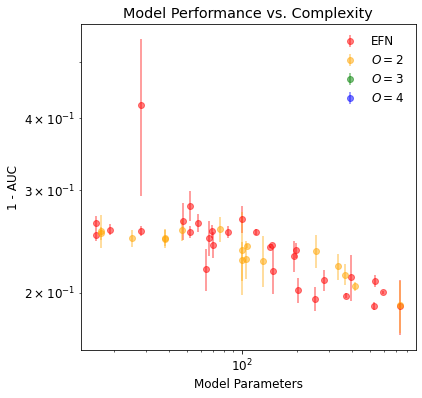

17 2 [2 1 4] 55
Epoch 1/50
150/150 - 2s - loss: 0.6865 - acc: 0.5883 - val_loss: 0.6621 - val_acc: 0.6465
Epoch 2/50
150/150 - 2s - loss: 0.6454 - acc: 0.6558 - val_loss: 0.6408 - val_acc: 0.6485
Epoch 3/50
150/150 - 2s - loss: 0.6333 - acc: 0.6583 - val_loss: 0.6319 - val_acc: 0.6620
Epoch 4/50
150/150 - 2s - loss: 0.6242 - acc: 0.6695 - val_loss: 0.6214 - val_acc: 0.6750
Epoch 5/50
150/150 - 2s - loss: 0.6168 - acc: 0.6762 - val_loss: 0.6131 - val_acc: 0.6785
Epoch 6/50
150/150 - 2s - loss: 0.6123 - acc: 0.6787 - val_loss: 0.6074 - val_acc: 0.6850
Epoch 7/50
150/150 - 2s - loss: 0.6092 - acc: 0.6789 - val_loss: 0.6062 - val_acc: 0.6770
Epoch 8/50
150/150 - 2s - loss: 0.6079 - acc: 0.6785 - val_loss: 0.6014 - val_acc: 0.6850
Epoch 9/50
150/150 - 2s - loss: 0.6078 - acc: 0.6784 - val_loss: 0.6042 - val_acc: 0.6810
Epoch 10/50
150/150 - 2s - loss: 0.6065 - acc: 0.6783 - val_loss: 0.6044 - val_acc: 0.6800
Epoch 11/50
150/150 - 2s - loss: 0.6067 - acc: 0.6789 - val_loss: 0.5988 - val_acc:

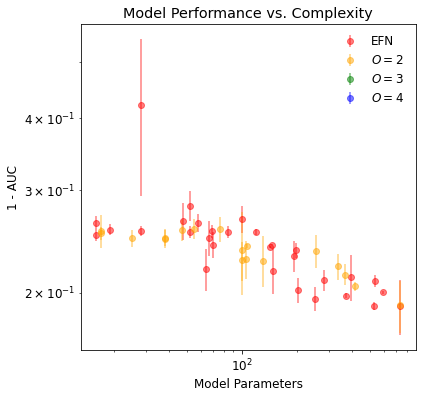

18 2 [1 6 4] 152
Epoch 1/50
150/150 - 1s - loss: 0.6923 - acc: 0.5145 - val_loss: 0.6924 - val_acc: 0.4730
Epoch 2/50
150/150 - 1s - loss: 0.6727 - acc: 0.6175 - val_loss: 0.6489 - val_acc: 0.6125
Epoch 3/50
150/150 - 1s - loss: 0.6286 - acc: 0.6574 - val_loss: 0.6092 - val_acc: 0.6795
Epoch 4/50
150/150 - 1s - loss: 0.6127 - acc: 0.6700 - val_loss: 0.6049 - val_acc: 0.6735
Epoch 5/50
150/150 - 1s - loss: 0.6050 - acc: 0.6773 - val_loss: 0.5923 - val_acc: 0.6960
Epoch 6/50
150/150 - 1s - loss: 0.5987 - acc: 0.6821 - val_loss: 0.5867 - val_acc: 0.7005
Epoch 7/50
150/150 - 1s - loss: 0.5935 - acc: 0.6857 - val_loss: 0.5836 - val_acc: 0.7020
Epoch 8/50
150/150 - 1s - loss: 0.5893 - acc: 0.6882 - val_loss: 0.5790 - val_acc: 0.6995
Epoch 9/50
150/150 - 1s - loss: 0.5856 - acc: 0.6907 - val_loss: 0.5776 - val_acc: 0.7010
Epoch 10/50
150/150 - 1s - loss: 0.5831 - acc: 0.6910 - val_loss: 0.5732 - val_acc: 0.6980
Epoch 11/50
150/150 - 1s - loss: 0.5801 - acc: 0.6927 - val_loss: 0.5718 - val_acc

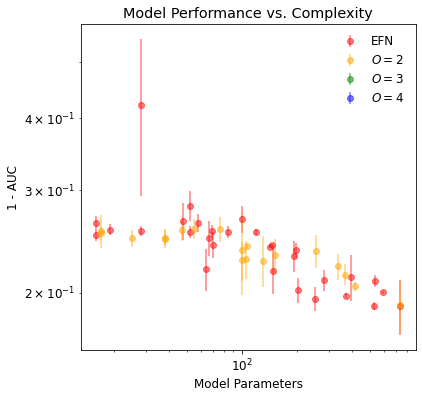

19 2 [6 1 9] 212
Epoch 1/50
150/150 - 6s - loss: 0.6852 - acc: 0.5757 - val_loss: 0.6692 - val_acc: 0.6310
Epoch 2/50
150/150 - 6s - loss: 0.6189 - acc: 0.6752 - val_loss: 0.5871 - val_acc: 0.7010
Epoch 3/50
150/150 - 6s - loss: 0.5817 - acc: 0.6892 - val_loss: 0.5749 - val_acc: 0.7055
Epoch 4/50
150/150 - 6s - loss: 0.5789 - acc: 0.6897 - val_loss: 0.5742 - val_acc: 0.7040
Epoch 5/50
150/150 - 6s - loss: 0.5773 - acc: 0.6914 - val_loss: 0.5696 - val_acc: 0.7055
Epoch 6/50
150/150 - 6s - loss: 0.5766 - acc: 0.6912 - val_loss: 0.5696 - val_acc: 0.7060
Epoch 7/50
150/150 - 6s - loss: 0.5761 - acc: 0.6915 - val_loss: 0.5698 - val_acc: 0.7055
Epoch 8/50
150/150 - 6s - loss: 0.5759 - acc: 0.6918 - val_loss: 0.5676 - val_acc: 0.7070
Epoch 9/50
150/150 - 6s - loss: 0.5760 - acc: 0.6919 - val_loss: 0.5717 - val_acc: 0.7075
Epoch 10/50
150/150 - 6s - loss: 0.5751 - acc: 0.6919 - val_loss: 0.5669 - val_acc: 0.7110
Epoch 11/50
150/150 - 6s - loss: 0.5755 - acc: 0.6921 - val_loss: 0.5668 - val_acc

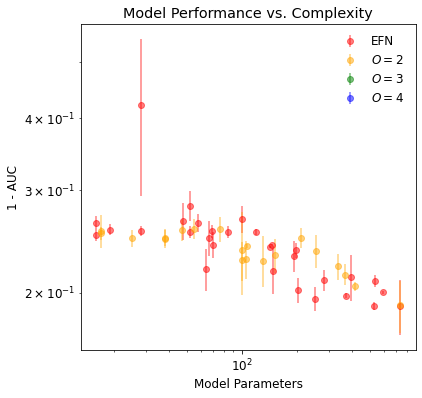

20 2 [5 7 3] 315
Epoch 1/50
150/150 - 5s - loss: 0.6821 - acc: 0.5805 - val_loss: 0.6502 - val_acc: 0.6470
Epoch 2/50
150/150 - 4s - loss: 0.6369 - acc: 0.6590 - val_loss: 0.6165 - val_acc: 0.6715
Epoch 3/50
150/150 - 4s - loss: 0.6007 - acc: 0.6819 - val_loss: 0.5915 - val_acc: 0.6895
Epoch 4/50
150/150 - 4s - loss: 0.5875 - acc: 0.6912 - val_loss: 0.5889 - val_acc: 0.6920
Epoch 5/50
150/150 - 4s - loss: 0.5847 - acc: 0.6928 - val_loss: 0.5874 - val_acc: 0.6965
Epoch 6/50
150/150 - 4s - loss: 0.5829 - acc: 0.6933 - val_loss: 0.5928 - val_acc: 0.6920
Epoch 7/50
150/150 - 4s - loss: 0.5833 - acc: 0.6923 - val_loss: 0.5810 - val_acc: 0.7105
Epoch 8/50
150/150 - 5s - loss: 0.5824 - acc: 0.6933 - val_loss: 0.5839 - val_acc: 0.7030
Epoch 9/50
150/150 - 4s - loss: 0.5815 - acc: 0.6932 - val_loss: 0.5817 - val_acc: 0.7050
Epoch 10/50
150/150 - 4s - loss: 0.5807 - acc: 0.6937 - val_loss: 0.5802 - val_acc: 0.7050
Epoch 11/50
150/150 - 5s - loss: 0.5809 - acc: 0.6926 - val_loss: 0.5812 - val_acc

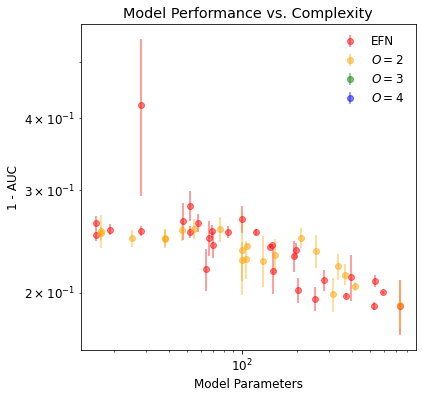

21 2 [4 4 3] 146
Epoch 1/50
150/150 - 4s - loss: 0.6899 - acc: 0.5585 - val_loss: 0.6797 - val_acc: 0.5890
Epoch 2/50
150/150 - 3s - loss: 0.6245 - acc: 0.6607 - val_loss: 0.5863 - val_acc: 0.6960
Epoch 3/50
150/150 - 3s - loss: 0.5858 - acc: 0.6895 - val_loss: 0.5824 - val_acc: 0.6950
Epoch 4/50
150/150 - 3s - loss: 0.5828 - acc: 0.6897 - val_loss: 0.5806 - val_acc: 0.6965
Epoch 5/50
150/150 - 3s - loss: 0.5817 - acc: 0.6912 - val_loss: 0.5827 - val_acc: 0.6920
Epoch 6/50
150/150 - 3s - loss: 0.5813 - acc: 0.6903 - val_loss: 0.5779 - val_acc: 0.6990
Epoch 7/50
150/150 - 3s - loss: 0.5797 - acc: 0.6907 - val_loss: 0.5779 - val_acc: 0.7010
Epoch 8/50
150/150 - 3s - loss: 0.5796 - acc: 0.6907 - val_loss: 0.5772 - val_acc: 0.7030
Epoch 9/50
150/150 - 3s - loss: 0.5792 - acc: 0.6914 - val_loss: 0.5759 - val_acc: 0.7040
Epoch 10/50
150/150 - 3s - loss: 0.5786 - acc: 0.6912 - val_loss: 0.5769 - val_acc: 0.7055
Epoch 11/50
150/150 - 3s - loss: 0.5786 - acc: 0.6914 - val_loss: 0.5738 - val_acc

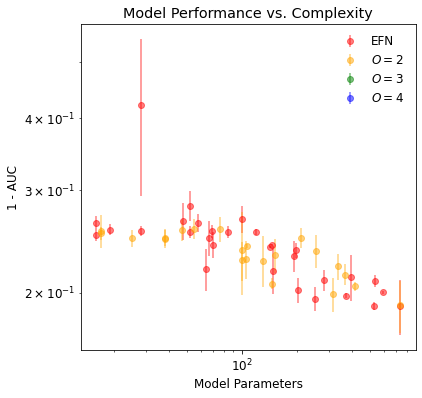

22 2 [ 3  6 13] 420
Epoch 1/50
150/150 - 3s - loss: 0.6885 - acc: 0.5625 - val_loss: 0.6652 - val_acc: 0.6455
Epoch 2/50
150/150 - 3s - loss: 0.6205 - acc: 0.6686 - val_loss: 0.5878 - val_acc: 0.7035
Epoch 3/50
150/150 - 3s - loss: 0.5864 - acc: 0.6906 - val_loss: 0.5737 - val_acc: 0.7070
Epoch 4/50
150/150 - 3s - loss: 0.5791 - acc: 0.6912 - val_loss: 0.5693 - val_acc: 0.7100
Epoch 5/50
150/150 - 3s - loss: 0.5771 - acc: 0.6908 - val_loss: 0.5718 - val_acc: 0.7055
Epoch 6/50
150/150 - 3s - loss: 0.5748 - acc: 0.6912 - val_loss: 0.5686 - val_acc: 0.7050
Epoch 7/50
150/150 - 3s - loss: 0.5736 - acc: 0.6931 - val_loss: 0.5654 - val_acc: 0.7075
Epoch 8/50
150/150 - 3s - loss: 0.5718 - acc: 0.6944 - val_loss: 0.5619 - val_acc: 0.7100
Epoch 9/50
150/150 - 3s - loss: 0.5696 - acc: 0.6957 - val_loss: 0.5595 - val_acc: 0.7140
Epoch 10/50
150/150 - 3s - loss: 0.5679 - acc: 0.6976 - val_loss: 0.5581 - val_acc: 0.7160
Epoch 11/50
150/150 - 3s - loss: 0.5661 - acc: 0.7005 - val_loss: 0.5565 - val_

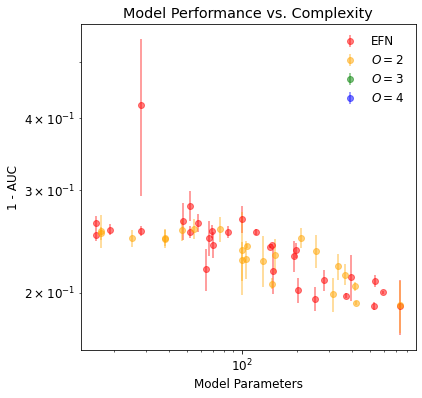

23 2 [1 6 4] 152
Epoch 1/50
150/150 - 1s - loss: 0.7184 - acc: 0.5670 - val_loss: 0.6783 - val_acc: 0.5885
Epoch 2/50
150/150 - 1s - loss: 0.6632 - acc: 0.6236 - val_loss: 0.6526 - val_acc: 0.6215
Epoch 3/50
150/150 - 1s - loss: 0.6482 - acc: 0.6364 - val_loss: 0.6385 - val_acc: 0.6475
Epoch 4/50
150/150 - 1s - loss: 0.6383 - acc: 0.6473 - val_loss: 0.6260 - val_acc: 0.6625
Epoch 5/50
150/150 - 1s - loss: 0.6283 - acc: 0.6563 - val_loss: 0.6170 - val_acc: 0.6640
Epoch 6/50
150/150 - 1s - loss: 0.6203 - acc: 0.6645 - val_loss: 0.6048 - val_acc: 0.6930
Epoch 7/50
150/150 - 1s - loss: 0.6140 - acc: 0.6704 - val_loss: 0.6005 - val_acc: 0.6915
Epoch 8/50
150/150 - 1s - loss: 0.6091 - acc: 0.6758 - val_loss: 0.5946 - val_acc: 0.6970
Epoch 9/50
150/150 - 1s - loss: 0.6049 - acc: 0.6801 - val_loss: 0.5906 - val_acc: 0.6985
Epoch 10/50
150/150 - 1s - loss: 0.5995 - acc: 0.6847 - val_loss: 0.5862 - val_acc: 0.7085
Epoch 11/50
150/150 - 1s - loss: 0.5945 - acc: 0.6879 - val_loss: 0.5816 - val_acc

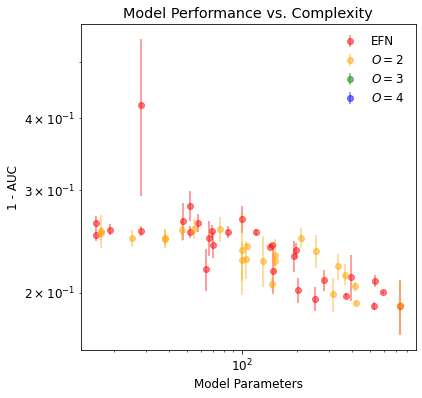

24 2 [1 1 1] 17
Epoch 1/50
150/150 - 1s - loss: 0.7167 - acc: 0.4981 - val_loss: 0.6903 - val_acc: 0.5375
Epoch 2/50
150/150 - 1s - loss: 0.6938 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5375
Epoch 3/50
150/150 - 1s - loss: 0.6932 - acc: 0.4959 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 4/50
150/150 - 1s - loss: 0.6931 - acc: 0.5010 - val_loss: 0.6935 - val_acc: 0.4625
Epoch 5/50
150/150 - 1s - loss: 0.6896 - acc: 0.5626 - val_loss: 0.6797 - val_acc: 0.7200
Epoch 6/50
150/150 - 1s - loss: 0.6716 - acc: 0.6767 - val_loss: 0.6540 - val_acc: 0.6615
Epoch 7/50
150/150 - 1s - loss: 0.6531 - acc: 0.6693 - val_loss: 0.6402 - val_acc: 0.6695
Epoch 8/50
150/150 - 1s - loss: 0.6475 - acc: 0.6611 - val_loss: 0.6372 - val_acc: 0.6555
Epoch 9/50
150/150 - 1s - loss: 0.6451 - acc: 0.6542 - val_loss: 0.6382 - val_acc: 0.6485
Epoch 10/50
150/150 - 1s - loss: 0.6436 - acc: 0.6500 - val_loss: 0.6364 - val_acc: 0.6500
Epoch 11/50
150/150 - 1s - loss: 0.6427 - acc: 0.6469 - val_loss: 0.6340 - val_acc:

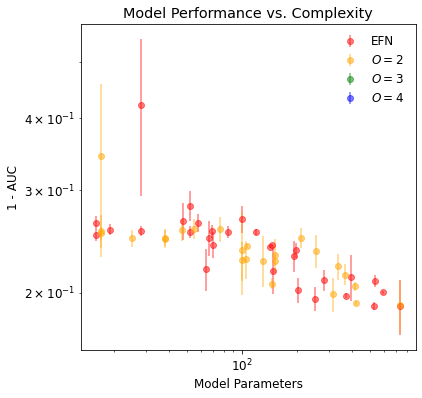

25 2 [2 4 2] 91
Epoch 1/50
150/150 - 2s - loss: 0.6942 - acc: 0.5056 - val_loss: 0.6928 - val_acc: 0.4990
Epoch 2/50
150/150 - 2s - loss: 0.6877 - acc: 0.5626 - val_loss: 0.6754 - val_acc: 0.6205
Epoch 3/50
150/150 - 2s - loss: 0.6484 - acc: 0.6372 - val_loss: 0.6133 - val_acc: 0.6705
Epoch 4/50
150/150 - 2s - loss: 0.6034 - acc: 0.6743 - val_loss: 0.5849 - val_acc: 0.7025
Epoch 5/50
150/150 - 2s - loss: 0.5899 - acc: 0.6849 - val_loss: 0.5809 - val_acc: 0.7015
Epoch 6/50
150/150 - 2s - loss: 0.5867 - acc: 0.6891 - val_loss: 0.5795 - val_acc: 0.7015
Epoch 7/50
150/150 - 2s - loss: 0.5857 - acc: 0.6903 - val_loss: 0.5785 - val_acc: 0.7090
Epoch 8/50
150/150 - 2s - loss: 0.5838 - acc: 0.6918 - val_loss: 0.5779 - val_acc: 0.7085
Epoch 9/50
150/150 - 2s - loss: 0.5828 - acc: 0.6934 - val_loss: 0.5783 - val_acc: 0.7065
Epoch 10/50
150/150 - 2s - loss: 0.5821 - acc: 0.6934 - val_loss: 0.5774 - val_acc: 0.7075
Epoch 11/50
150/150 - 2s - loss: 0.5809 - acc: 0.6949 - val_loss: 0.5805 - val_acc:

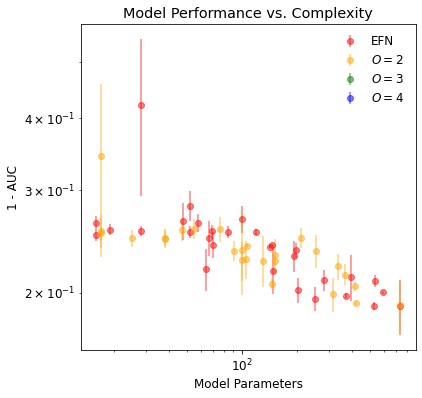

26 2 [2 7 3] 198
Epoch 1/50
150/150 - 2s - loss: 0.6934 - acc: 0.5130 - val_loss: 0.6916 - val_acc: 0.6970
Epoch 2/50
150/150 - 2s - loss: 0.6629 - acc: 0.6389 - val_loss: 0.6381 - val_acc: 0.6310
Epoch 3/50
150/150 - 3s - loss: 0.6288 - acc: 0.6617 - val_loss: 0.6142 - val_acc: 0.6730
Epoch 4/50
150/150 - 2s - loss: 0.6089 - acc: 0.6759 - val_loss: 0.5942 - val_acc: 0.6875
Epoch 5/50
150/150 - 2s - loss: 0.5928 - acc: 0.6867 - val_loss: 0.5820 - val_acc: 0.6970
Epoch 6/50
150/150 - 2s - loss: 0.5850 - acc: 0.6908 - val_loss: 0.5823 - val_acc: 0.6975
Epoch 7/50
150/150 - 2s - loss: 0.5827 - acc: 0.6924 - val_loss: 0.5753 - val_acc: 0.7035
Epoch 8/50
150/150 - 2s - loss: 0.5811 - acc: 0.6924 - val_loss: 0.5748 - val_acc: 0.6995
Epoch 9/50
150/150 - 2s - loss: 0.5800 - acc: 0.6921 - val_loss: 0.5718 - val_acc: 0.7020
Epoch 10/50
150/150 - 2s - loss: 0.5792 - acc: 0.6925 - val_loss: 0.5758 - val_acc: 0.7005
Epoch 11/50
150/150 - 2s - loss: 0.5781 - acc: 0.6918 - val_loss: 0.5753 - val_acc

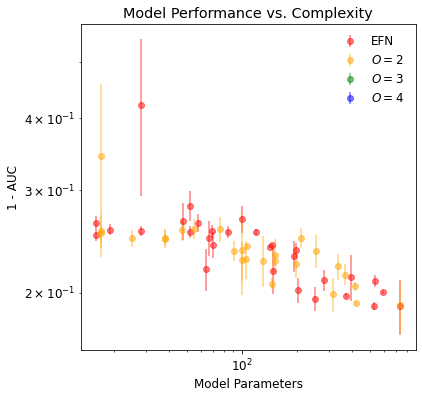

27 2 [4 1 3] 59
Epoch 1/50
150/150 - 3s - loss: 0.6902 - acc: 0.5241 - val_loss: 0.6709 - val_acc: 0.6835
Epoch 2/50
150/150 - 3s - loss: 0.6586 - acc: 0.6864 - val_loss: 0.6400 - val_acc: 0.6950
Epoch 3/50
150/150 - 4s - loss: 0.6428 - acc: 0.6881 - val_loss: 0.6296 - val_acc: 0.6920
Epoch 4/50
150/150 - 3s - loss: 0.6337 - acc: 0.6861 - val_loss: 0.6210 - val_acc: 0.6925
Epoch 5/50
150/150 - 3s - loss: 0.6277 - acc: 0.6836 - val_loss: 0.6155 - val_acc: 0.6985
Epoch 6/50
150/150 - 3s - loss: 0.6232 - acc: 0.6816 - val_loss: 0.6143 - val_acc: 0.6820
Epoch 7/50
150/150 - 3s - loss: 0.6204 - acc: 0.6791 - val_loss: 0.6092 - val_acc: 0.6885
Epoch 8/50
150/150 - 3s - loss: 0.6179 - acc: 0.6790 - val_loss: 0.6081 - val_acc: 0.6845
Epoch 9/50
150/150 - 3s - loss: 0.6162 - acc: 0.6779 - val_loss: 0.6078 - val_acc: 0.6800
Epoch 10/50
150/150 - 3s - loss: 0.6149 - acc: 0.6780 - val_loss: 0.6059 - val_acc: 0.6825
Epoch 11/50
150/150 - 3s - loss: 0.6136 - acc: 0.6769 - val_loss: 0.6056 - val_acc:

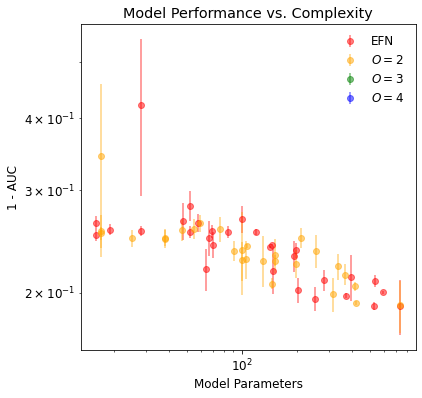

28 2 [1 1 2] 25
Epoch 1/50
150/150 - 2s - loss: 1.0157 - acc: 0.4981 - val_loss: 0.7434 - val_acc: 0.5375
Epoch 2/50
150/150 - 1s - loss: 0.7104 - acc: 0.4912 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 3/50
150/150 - 1s - loss: 0.6932 - acc: 0.4957 - val_loss: 0.6943 - val_acc: 0.4625
Epoch 4/50
150/150 - 1s - loss: 0.6932 - acc: 0.5023 - val_loss: 0.6938 - val_acc: 0.4625
Epoch 5/50
150/150 - 1s - loss: 0.6931 - acc: 0.4994 - val_loss: 0.6934 - val_acc: 0.4665
Epoch 6/50
150/150 - 1s - loss: 0.6930 - acc: 0.5104 - val_loss: 0.6928 - val_acc: 0.5520
Epoch 7/50
150/150 - 1s - loss: 0.6920 - acc: 0.5370 - val_loss: 0.6912 - val_acc: 0.5285
Epoch 8/50
150/150 - 1s - loss: 0.6894 - acc: 0.5992 - val_loss: 0.6901 - val_acc: 0.5100
Epoch 9/50
150/150 - 1s - loss: 0.6867 - acc: 0.5896 - val_loss: 0.6856 - val_acc: 0.5760
Epoch 10/50
150/150 - 1s - loss: 0.6826 - acc: 0.6142 - val_loss: 0.6823 - val_acc: 0.5595
Epoch 11/50
150/150 - 1s - loss: 0.6785 - acc: 0.6151 - val_loss: 0.6769 - val_acc:

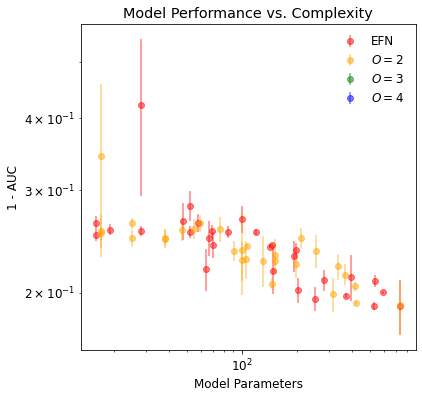

29 2 [2 6 5] 190
Epoch 1/50
150/150 - 2s - loss: 0.6907 - acc: 0.5799 - val_loss: 0.6753 - val_acc: 0.6015
Epoch 2/50
150/150 - 2s - loss: 0.6486 - acc: 0.6457 - val_loss: 0.6265 - val_acc: 0.6775
Epoch 3/50
150/150 - 2s - loss: 0.6259 - acc: 0.6587 - val_loss: 0.6168 - val_acc: 0.6645
Epoch 4/50
150/150 - 2s - loss: 0.6173 - acc: 0.6656 - val_loss: 0.6053 - val_acc: 0.6750
Epoch 5/50
150/150 - 2s - loss: 0.6101 - acc: 0.6727 - val_loss: 0.5984 - val_acc: 0.6850
Epoch 6/50
150/150 - 2s - loss: 0.6044 - acc: 0.6776 - val_loss: 0.5924 - val_acc: 0.6920
Epoch 7/50
150/150 - 2s - loss: 0.5975 - acc: 0.6820 - val_loss: 0.5862 - val_acc: 0.6945
Epoch 8/50
150/150 - 2s - loss: 0.5909 - acc: 0.6862 - val_loss: 0.5816 - val_acc: 0.6985
Epoch 9/50
150/150 - 2s - loss: 0.5858 - acc: 0.6890 - val_loss: 0.5736 - val_acc: 0.6995
Epoch 10/50
150/150 - 2s - loss: 0.5814 - acc: 0.6906 - val_loss: 0.5682 - val_acc: 0.7060
Epoch 11/50
150/150 - 2s - loss: 0.5788 - acc: 0.6922 - val_loss: 0.5657 - val_acc

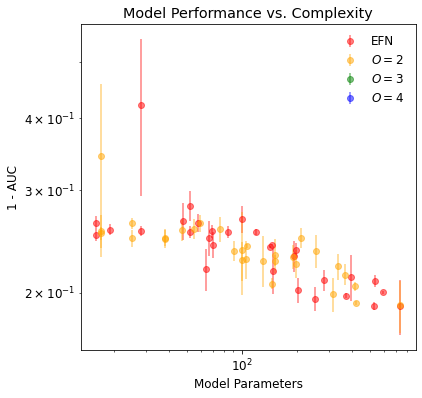

0 3 [1 1 6] 78
Epoch 1/50
150/150 - 2s - loss: 0.6819 - acc: 0.5713 - val_loss: 0.6614 - val_acc: 0.6890
Epoch 2/50
150/150 - 2s - loss: 0.6643 - acc: 0.6662 - val_loss: 0.6586 - val_acc: 0.6490
Epoch 3/50
150/150 - 2s - loss: 0.6594 - acc: 0.6495 - val_loss: 0.6572 - val_acc: 0.6360
Epoch 4/50
150/150 - 2s - loss: 0.6548 - acc: 0.6481 - val_loss: 0.6514 - val_acc: 0.6350
Epoch 5/50
150/150 - 2s - loss: 0.6510 - acc: 0.6463 - val_loss: 0.6491 - val_acc: 0.6350
Epoch 6/50
150/150 - 2s - loss: 0.6494 - acc: 0.6453 - val_loss: 0.6463 - val_acc: 0.6545
Epoch 7/50
150/150 - 2s - loss: 0.6485 - acc: 0.6432 - val_loss: 0.6468 - val_acc: 0.6335
Epoch 8/50
150/150 - 2s - loss: 0.6471 - acc: 0.6416 - val_loss: 0.6464 - val_acc: 0.6295
Epoch 9/50
150/150 - 2s - loss: 0.6466 - acc: 0.6421 - val_loss: 0.6486 - val_acc: 0.6140
Epoch 10/50
150/150 - 2s - loss: 0.6450 - acc: 0.6419 - val_loss: 0.6420 - val_acc: 0.6450
Epoch 11/50
150/150 - 2s - loss: 0.6442 - acc: 0.6428 - val_loss: 0.6453 - val_acc: 

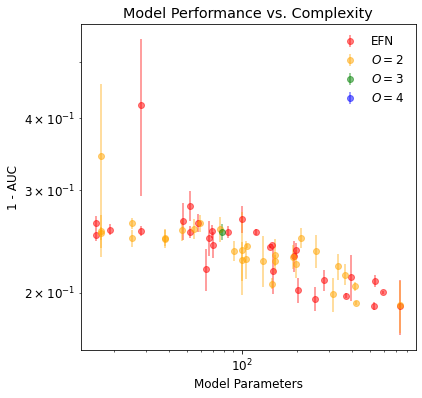

1 3 [1 3 7] 128
Epoch 1/50
150/150 - 2s - loss: 0.7158 - acc: 0.5493 - val_loss: 0.6514 - val_acc: 0.7110
Epoch 2/50
150/150 - 2s - loss: 0.6493 - acc: 0.6847 - val_loss: 0.6327 - val_acc: 0.6720
Epoch 3/50
150/150 - 2s - loss: 0.6320 - acc: 0.6759 - val_loss: 0.6164 - val_acc: 0.6865
Epoch 4/50
150/150 - 2s - loss: 0.6180 - acc: 0.6765 - val_loss: 0.6071 - val_acc: 0.6815
Epoch 5/50
150/150 - 2s - loss: 0.6042 - acc: 0.6849 - val_loss: 0.5995 - val_acc: 0.6835
Epoch 6/50
150/150 - 2s - loss: 0.5960 - acc: 0.6928 - val_loss: 0.5884 - val_acc: 0.7085
Epoch 7/50
150/150 - 2s - loss: 0.5914 - acc: 0.6950 - val_loss: 0.5855 - val_acc: 0.7145
Epoch 8/50
150/150 - 2s - loss: 0.5884 - acc: 0.6976 - val_loss: 0.5808 - val_acc: 0.7130
Epoch 9/50
150/150 - 2s - loss: 0.5860 - acc: 0.6989 - val_loss: 0.5781 - val_acc: 0.7175
Epoch 10/50
150/150 - 2s - loss: 0.5837 - acc: 0.7009 - val_loss: 0.5763 - val_acc: 0.7145
Epoch 11/50
150/150 - 2s - loss: 0.5824 - acc: 0.7027 - val_loss: 0.5756 - val_acc:

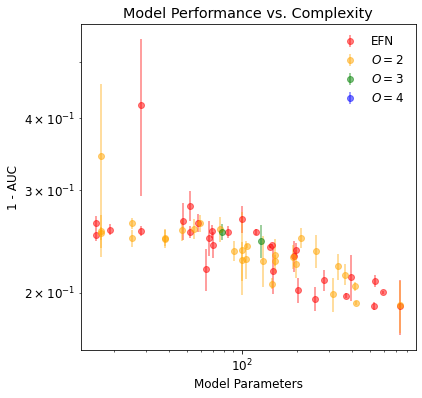

2 3 [ 2 14  1] 598
Epoch 1/50
150/150 - 3s - loss: 0.7011 - acc: 0.5055 - val_loss: 0.6911 - val_acc: 0.5375
Epoch 2/50
150/150 - 2s - loss: 0.6847 - acc: 0.5998 - val_loss: 0.6602 - val_acc: 0.6385
Epoch 3/50
150/150 - 2s - loss: 0.6224 - acc: 0.6663 - val_loss: 0.5951 - val_acc: 0.6905
Epoch 4/50
150/150 - 2s - loss: 0.5857 - acc: 0.6907 - val_loss: 0.5742 - val_acc: 0.7070
Epoch 5/50
150/150 - 2s - loss: 0.5778 - acc: 0.6935 - val_loss: 0.5700 - val_acc: 0.7120
Epoch 6/50
150/150 - 2s - loss: 0.5760 - acc: 0.6954 - val_loss: 0.5657 - val_acc: 0.7165
Epoch 7/50
150/150 - 2s - loss: 0.5743 - acc: 0.6954 - val_loss: 0.5701 - val_acc: 0.7140
Epoch 8/50
150/150 - 3s - loss: 0.5722 - acc: 0.6979 - val_loss: 0.5628 - val_acc: 0.7180
Epoch 9/50
150/150 - 2s - loss: 0.5698 - acc: 0.6994 - val_loss: 0.5576 - val_acc: 0.7240
Epoch 10/50
150/150 - 2s - loss: 0.5661 - acc: 0.7023 - val_loss: 0.5539 - val_acc: 0.7300
Epoch 11/50
150/150 - 2s - loss: 0.5610 - acc: 0.7055 - val_loss: 0.5510 - val_a

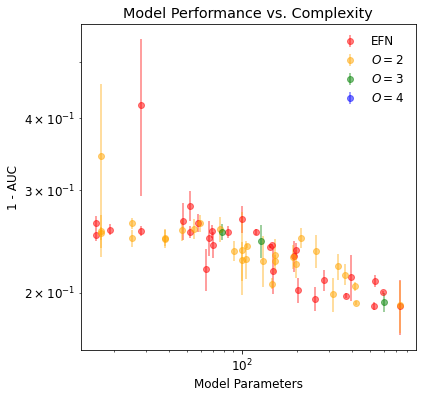

3 3 [2 2 1] 46
Epoch 1/50
150/150 - 3s - loss: 0.6931 - acc: 0.5048 - val_loss: 0.6931 - val_acc: 0.4660
Epoch 2/50
150/150 - 2s - loss: 0.6897 - acc: 0.5500 - val_loss: 0.6777 - val_acc: 0.6465
Epoch 3/50
150/150 - 2s - loss: 0.6400 - acc: 0.6668 - val_loss: 0.6060 - val_acc: 0.6900
Epoch 4/50
150/150 - 2s - loss: 0.6050 - acc: 0.6839 - val_loss: 0.5990 - val_acc: 0.6900
Epoch 5/50
150/150 - 2s - loss: 0.5997 - acc: 0.6875 - val_loss: 0.5951 - val_acc: 0.6980
Epoch 6/50
150/150 - 2s - loss: 0.5969 - acc: 0.6889 - val_loss: 0.5920 - val_acc: 0.7010
Epoch 7/50
150/150 - 2s - loss: 0.5945 - acc: 0.6892 - val_loss: 0.5879 - val_acc: 0.6995
Epoch 8/50
150/150 - 2s - loss: 0.5923 - acc: 0.6905 - val_loss: 0.5855 - val_acc: 0.7045
Epoch 9/50
150/150 - 2s - loss: 0.5899 - acc: 0.6911 - val_loss: 0.5867 - val_acc: 0.7000
Epoch 10/50
150/150 - 2s - loss: 0.5877 - acc: 0.6920 - val_loss: 0.5839 - val_acc: 0.6990
Epoch 11/50
150/150 - 2s - loss: 0.5872 - acc: 0.6923 - val_loss: 0.5850 - val_acc: 

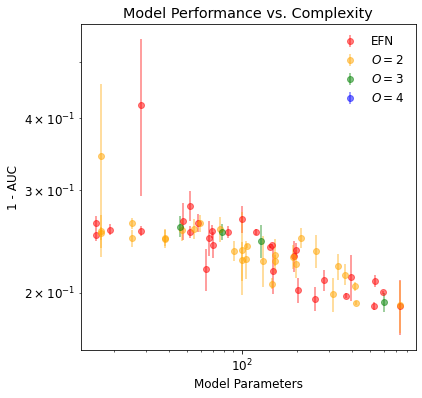

4 3 [5 2 3] 170
Epoch 1/50
150/150 - 11s - loss: 0.6875 - acc: 0.5499 - val_loss: 0.6573 - val_acc: 0.6985
Epoch 2/50
150/150 - 11s - loss: 0.6617 - acc: 0.6678 - val_loss: 0.6487 - val_acc: 0.6545
Epoch 3/50
150/150 - 11s - loss: 0.6530 - acc: 0.6525 - val_loss: 0.6435 - val_acc: 0.6465
Epoch 4/50
150/150 - 11s - loss: 0.6468 - acc: 0.6509 - val_loss: 0.6402 - val_acc: 0.6375
Epoch 5/50
150/150 - 11s - loss: 0.6415 - acc: 0.6505 - val_loss: 0.6352 - val_acc: 0.6760
Epoch 6/50
150/150 - 11s - loss: 0.6383 - acc: 0.6513 - val_loss: 0.6352 - val_acc: 0.6430
Epoch 7/50
150/150 - 11s - loss: 0.6354 - acc: 0.6500 - val_loss: 0.6325 - val_acc: 0.6470
Epoch 8/50
150/150 - 11s - loss: 0.6341 - acc: 0.6499 - val_loss: 0.6347 - val_acc: 0.6330
Epoch 9/50
150/150 - 11s - loss: 0.6326 - acc: 0.6504 - val_loss: 0.6306 - val_acc: 0.6420
Epoch 10/50
150/150 - 11s - loss: 0.6313 - acc: 0.6507 - val_loss: 0.6261 - val_acc: 0.6545
Epoch 11/50
150/150 - 11s - loss: 0.6296 - acc: 0.6518 - val_loss: 0.6238

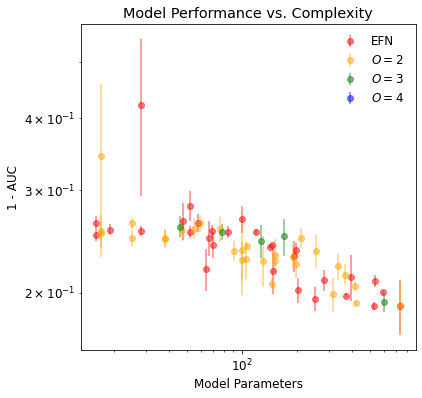

5 3 [2 1 1] 26
Epoch 1/50
150/150 - 3s - loss: 0.6933 - acc: 0.5004 - val_loss: 0.6933 - val_acc: 0.4625
Epoch 2/50
150/150 - 2s - loss: 0.6918 - acc: 0.5737 - val_loss: 0.6879 - val_acc: 0.6815
Epoch 3/50
150/150 - 2s - loss: 0.6753 - acc: 0.6592 - val_loss: 0.6575 - val_acc: 0.6585
Epoch 4/50
150/150 - 2s - loss: 0.6614 - acc: 0.6566 - val_loss: 0.6523 - val_acc: 0.6520
Epoch 5/50
150/150 - 2s - loss: 0.6571 - acc: 0.6463 - val_loss: 0.6516 - val_acc: 0.6290
Epoch 6/50
150/150 - 2s - loss: 0.6542 - acc: 0.6417 - val_loss: 0.6494 - val_acc: 0.6320
Epoch 7/50
150/150 - 2s - loss: 0.6521 - acc: 0.6399 - val_loss: 0.6469 - val_acc: 0.6350
Epoch 8/50
150/150 - 2s - loss: 0.6505 - acc: 0.6400 - val_loss: 0.6463 - val_acc: 0.6310
Epoch 9/50
150/150 - 2s - loss: 0.6491 - acc: 0.6399 - val_loss: 0.6463 - val_acc: 0.6300
Epoch 10/50
150/150 - 2s - loss: 0.6477 - acc: 0.6399 - val_loss: 0.6450 - val_acc: 0.6280
Epoch 11/50
150/150 - 2s - loss: 0.6467 - acc: 0.6396 - val_loss: 0.6426 - val_acc: 

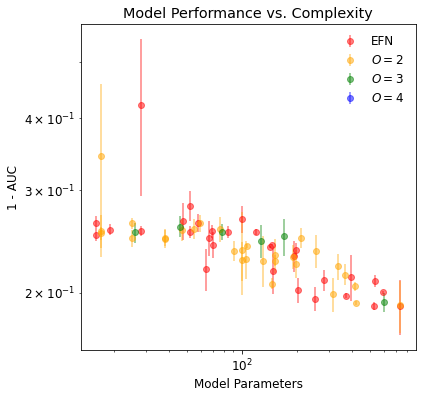

6 3 [3 5 2] 192
Epoch 1/50
150/150 - 4s - loss: 0.6917 - acc: 0.5513 - val_loss: 0.6830 - val_acc: 0.7010
Epoch 2/50
150/150 - 4s - loss: 0.6527 - acc: 0.6662 - val_loss: 0.6289 - val_acc: 0.6525
Epoch 3/50
150/150 - 4s - loss: 0.6197 - acc: 0.6683 - val_loss: 0.6053 - val_acc: 0.6870
Epoch 4/50
150/150 - 4s - loss: 0.5975 - acc: 0.6857 - val_loss: 0.5849 - val_acc: 0.6985
Epoch 5/50
150/150 - 4s - loss: 0.5833 - acc: 0.6915 - val_loss: 0.5774 - val_acc: 0.6985
Epoch 6/50
150/150 - 4s - loss: 0.5794 - acc: 0.6929 - val_loss: 0.5779 - val_acc: 0.7060
Epoch 7/50
150/150 - 4s - loss: 0.5785 - acc: 0.6935 - val_loss: 0.5783 - val_acc: 0.7005
Epoch 8/50
150/150 - 4s - loss: 0.5772 - acc: 0.6933 - val_loss: 0.5792 - val_acc: 0.7040
Epoch 9/50
150/150 - 4s - loss: 0.5779 - acc: 0.6938 - val_loss: 0.5742 - val_acc: 0.7025
Epoch 10/50
150/150 - 4s - loss: 0.5766 - acc: 0.6947 - val_loss: 0.5735 - val_acc: 0.7025
Epoch 11/50
150/150 - 4s - loss: 0.5768 - acc: 0.6936 - val_loss: 0.5755 - val_acc:

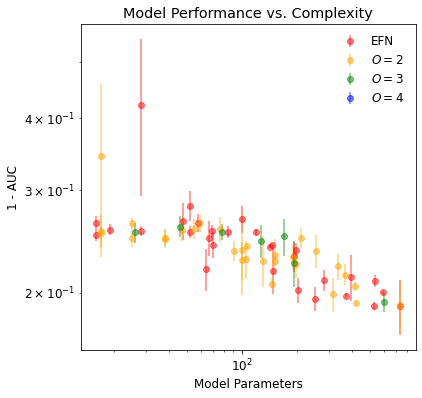

7 3 [1 4 1] 72
Epoch 1/50
150/150 - 1s - loss: 0.6934 - acc: 0.4983 - val_loss: 0.6929 - val_acc: 0.5375
Epoch 2/50
150/150 - 1s - loss: 0.6932 - acc: 0.4998 - val_loss: 0.6946 - val_acc: 0.4625
Epoch 3/50
150/150 - 1s - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6936 - val_acc: 0.4625
Epoch 4/50
150/150 - 1s - loss: 0.6932 - acc: 0.5008 - val_loss: 0.6938 - val_acc: 0.4625
Epoch 5/50
150/150 - 1s - loss: 0.6932 - acc: 0.5013 - val_loss: 0.6940 - val_acc: 0.4625
Epoch 6/50
150/150 - 1s - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 7/50
150/150 - 1s - loss: 0.6932 - acc: 0.4975 - val_loss: 0.6928 - val_acc: 0.5375
Epoch 8/50
150/150 - 1s - loss: 0.6933 - acc: 0.4974 - val_loss: 0.6944 - val_acc: 0.4625
Epoch 9/50
150/150 - 1s - loss: 0.6932 - acc: 0.5014 - val_loss: 0.6920 - val_acc: 0.5375
Epoch 10/50
150/150 - 1s - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6938 - val_acc: 0.4625
Epoch 11/50
150/150 - 1s - loss: 0.6932 - acc: 0.5015 - val_loss: 0.6936 - val_acc: 

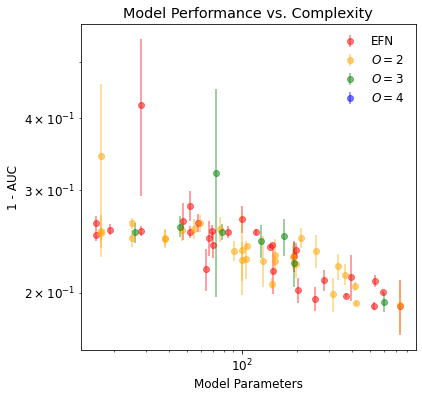

8 3 [3 1 2] 48
Epoch 1/50
150/150 - 4s - loss: 0.6931 - acc: 0.4997 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 2/50
150/150 - 4s - loss: 0.6921 - acc: 0.5216 - val_loss: 0.6862 - val_acc: 0.6430
Epoch 3/50
150/150 - 4s - loss: 0.6468 - acc: 0.6706 - val_loss: 0.6209 - val_acc: 0.6920
Epoch 4/50
150/150 - 4s - loss: 0.6189 - acc: 0.6808 - val_loss: 0.6125 - val_acc: 0.6860
Epoch 5/50
150/150 - 4s - loss: 0.6091 - acc: 0.6829 - val_loss: 0.6048 - val_acc: 0.6895
Epoch 6/50
150/150 - 4s - loss: 0.6030 - acc: 0.6831 - val_loss: 0.5993 - val_acc: 0.6915
Epoch 7/50
150/150 - 4s - loss: 0.5987 - acc: 0.6850 - val_loss: 0.5963 - val_acc: 0.6895
Epoch 8/50
150/150 - 4s - loss: 0.5969 - acc: 0.6867 - val_loss: 0.5934 - val_acc: 0.6945
Epoch 9/50
150/150 - 4s - loss: 0.5958 - acc: 0.6888 - val_loss: 0.5915 - val_acc: 0.7030
Epoch 10/50
150/150 - 4s - loss: 0.5938 - acc: 0.6909 - val_loss: 0.5904 - val_acc: 0.7015
Epoch 11/50
150/150 - 4s - loss: 0.5935 - acc: 0.6912 - val_loss: 0.5941 - val_acc: 

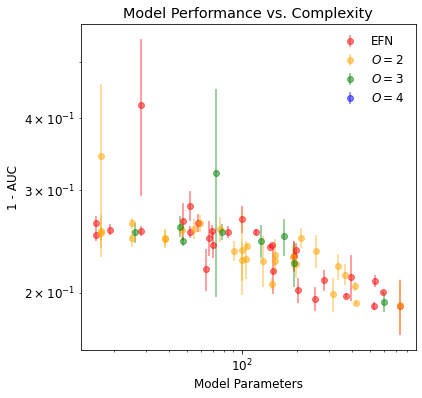

9 3 [1 3 3] 68
Epoch 1/50
150/150 - 2s - loss: 0.6931 - acc: 0.5030 - val_loss: 0.6935 - val_acc: 0.4625
Epoch 2/50
150/150 - 2s - loss: 0.6921 - acc: 0.5603 - val_loss: 0.6916 - val_acc: 0.4855
Epoch 3/50
150/150 - 1s - loss: 0.6683 - acc: 0.6032 - val_loss: 0.6380 - val_acc: 0.6605
Epoch 4/50
150/150 - 1s - loss: 0.6220 - acc: 0.6617 - val_loss: 0.6049 - val_acc: 0.6715
Epoch 5/50
150/150 - 1s - loss: 0.6055 - acc: 0.6738 - val_loss: 0.5962 - val_acc: 0.6775
Epoch 6/50
150/150 - 1s - loss: 0.5989 - acc: 0.6788 - val_loss: 0.5979 - val_acc: 0.6795
Epoch 7/50
150/150 - 1s - loss: 0.5954 - acc: 0.6806 - val_loss: 0.5855 - val_acc: 0.6985
Epoch 8/50
150/150 - 1s - loss: 0.5933 - acc: 0.6827 - val_loss: 0.5834 - val_acc: 0.7045
Epoch 9/50
150/150 - 1s - loss: 0.5919 - acc: 0.6843 - val_loss: 0.5812 - val_acc: 0.7035
Epoch 10/50
150/150 - 1s - loss: 0.5905 - acc: 0.6862 - val_loss: 0.5805 - val_acc: 0.7025
Epoch 11/50
150/150 - 1s - loss: 0.5897 - acc: 0.6872 - val_loss: 0.5790 - val_acc: 

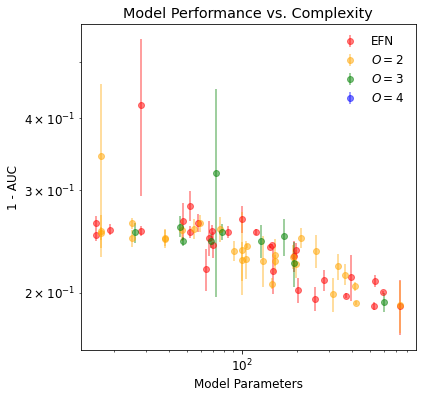

10 3 [2 2 1] 46
Epoch 1/50
150/150 - 3s - loss: 0.6932 - acc: 0.4917 - val_loss: 0.6936 - val_acc: 0.4625
Epoch 2/50
150/150 - 2s - loss: 0.6931 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 3/50
150/150 - 2s - loss: 0.6916 - acc: 0.5051 - val_loss: 0.6716 - val_acc: 0.5375
Epoch 4/50
150/150 - 2s - loss: 0.6471 - acc: 0.6665 - val_loss: 0.6197 - val_acc: 0.6740
Epoch 5/50
150/150 - 2s - loss: 0.6176 - acc: 0.6708 - val_loss: 0.6063 - val_acc: 0.6910
Epoch 6/50
150/150 - 2s - loss: 0.6085 - acc: 0.6778 - val_loss: 0.6001 - val_acc: 0.6995
Epoch 7/50
150/150 - 2s - loss: 0.6025 - acc: 0.6827 - val_loss: 0.5961 - val_acc: 0.6975
Epoch 8/50
150/150 - 2s - loss: 0.5981 - acc: 0.6865 - val_loss: 0.5929 - val_acc: 0.6975
Epoch 9/50
150/150 - 2s - loss: 0.5946 - acc: 0.6897 - val_loss: 0.5883 - val_acc: 0.6980
Epoch 10/50
150/150 - 2s - loss: 0.5913 - acc: 0.6917 - val_loss: 0.5874 - val_acc: 0.7010
Epoch 11/50
150/150 - 2s - loss: 0.5900 - acc: 0.6923 - val_loss: 0.5853 - val_acc:

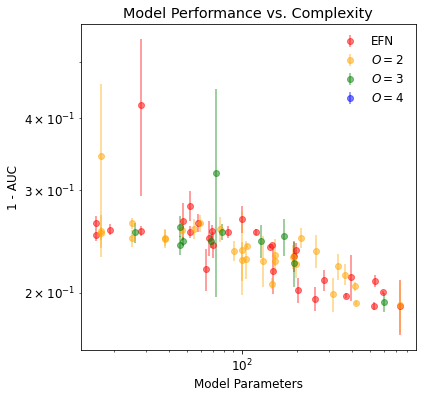

11 3 [ 3  8 12] 552
Epoch 1/50
150/150 - 5s - loss: 0.6563 - acc: 0.6423 - val_loss: 0.5989 - val_acc: 0.6720
Epoch 2/50
150/150 - 5s - loss: 0.5886 - acc: 0.6944 - val_loss: 0.5735 - val_acc: 0.7030
Epoch 3/50
150/150 - 5s - loss: 0.5802 - acc: 0.7006 - val_loss: 0.5687 - val_acc: 0.7145
Epoch 4/50
150/150 - 5s - loss: 0.5763 - acc: 0.7026 - val_loss: 0.5743 - val_acc: 0.7075
Epoch 5/50
150/150 - 5s - loss: 0.5731 - acc: 0.7032 - val_loss: 0.5620 - val_acc: 0.7145
Epoch 6/50
150/150 - 5s - loss: 0.5690 - acc: 0.7040 - val_loss: 0.5575 - val_acc: 0.7155
Epoch 7/50
150/150 - 5s - loss: 0.5655 - acc: 0.7068 - val_loss: 0.5559 - val_acc: 0.7185
Epoch 8/50
150/150 - 5s - loss: 0.5628 - acc: 0.7092 - val_loss: 0.5538 - val_acc: 0.7220
Epoch 9/50
150/150 - 5s - loss: 0.5610 - acc: 0.7101 - val_loss: 0.5558 - val_acc: 0.7155
Epoch 10/50
150/150 - 5s - loss: 0.5582 - acc: 0.7104 - val_loss: 0.5480 - val_acc: 0.7245
Epoch 11/50
150/150 - 5s - loss: 0.5570 - acc: 0.7123 - val_loss: 0.5459 - val_

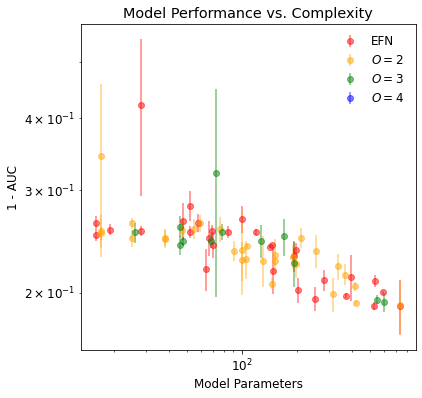

12 3 [1 1 8] 116
Epoch 1/50
150/150 - 2s - loss: 0.6874 - acc: 0.5432 - val_loss: 0.6607 - val_acc: 0.7010
Epoch 2/50
150/150 - 2s - loss: 0.6567 - acc: 0.6852 - val_loss: 0.6466 - val_acc: 0.6735
Epoch 3/50
150/150 - 2s - loss: 0.6486 - acc: 0.6706 - val_loss: 0.6437 - val_acc: 0.6420
Epoch 4/50
150/150 - 2s - loss: 0.6447 - acc: 0.6609 - val_loss: 0.6407 - val_acc: 0.6425
Epoch 5/50
150/150 - 2s - loss: 0.6423 - acc: 0.6549 - val_loss: 0.6368 - val_acc: 0.6490
Epoch 6/50
150/150 - 2s - loss: 0.6405 - acc: 0.6525 - val_loss: 0.6372 - val_acc: 0.6380
Epoch 7/50
150/150 - 2s - loss: 0.6393 - acc: 0.6508 - val_loss: 0.6342 - val_acc: 0.6500
Epoch 8/50
150/150 - 2s - loss: 0.6383 - acc: 0.6515 - val_loss: 0.6331 - val_acc: 0.6470
Epoch 9/50
150/150 - 2s - loss: 0.6369 - acc: 0.6500 - val_loss: 0.6337 - val_acc: 0.6400
Epoch 10/50
150/150 - 2s - loss: 0.6358 - acc: 0.6498 - val_loss: 0.6285 - val_acc: 0.6675
Epoch 11/50
150/150 - 2s - loss: 0.6353 - acc: 0.6517 - val_loss: 0.6269 - val_acc

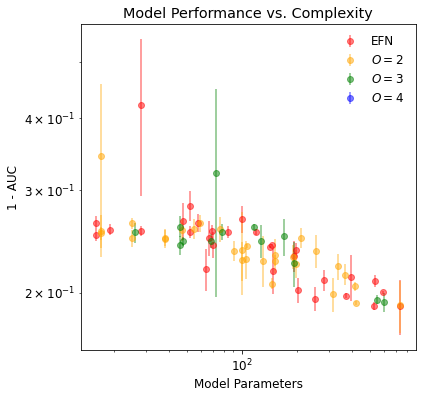

13 3 [ 1  4 13] 300
Epoch 1/50
150/150 - 2s - loss: 0.6910 - acc: 0.5597 - val_loss: 0.6836 - val_acc: 0.6105
Epoch 2/50
150/150 - 2s - loss: 0.6458 - acc: 0.6561 - val_loss: 0.6121 - val_acc: 0.6745
Epoch 3/50
150/150 - 2s - loss: 0.6071 - acc: 0.6763 - val_loss: 0.5974 - val_acc: 0.6840
Epoch 4/50
150/150 - 2s - loss: 0.5986 - acc: 0.6813 - val_loss: 0.5943 - val_acc: 0.6820
Epoch 5/50
150/150 - 2s - loss: 0.5926 - acc: 0.6857 - val_loss: 0.5882 - val_acc: 0.6890
Epoch 6/50
150/150 - 2s - loss: 0.5851 - acc: 0.6901 - val_loss: 0.5776 - val_acc: 0.7005
Epoch 7/50
150/150 - 2s - loss: 0.5812 - acc: 0.6922 - val_loss: 0.5793 - val_acc: 0.6980
Epoch 8/50
150/150 - 2s - loss: 0.5794 - acc: 0.6926 - val_loss: 0.5732 - val_acc: 0.7050
Epoch 9/50
150/150 - 2s - loss: 0.5786 - acc: 0.6933 - val_loss: 0.5715 - val_acc: 0.7055
Epoch 10/50
150/150 - 2s - loss: 0.5773 - acc: 0.6931 - val_loss: 0.5710 - val_acc: 0.7030
Epoch 11/50
150/150 - 2s - loss: 0.5765 - acc: 0.6936 - val_loss: 0.5718 - val_

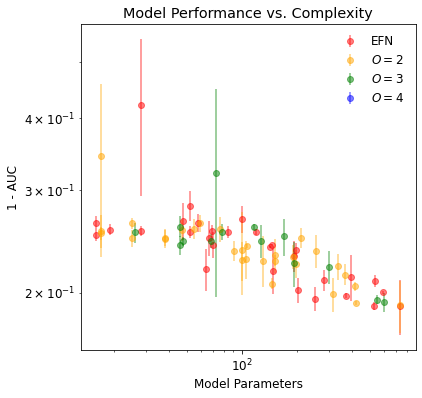

14 3 [ 1 16 12] 846
Epoch 1/50
150/150 - 2s - loss: 0.7033 - acc: 0.5691 - val_loss: 0.6566 - val_acc: 0.6320
Epoch 2/50
150/150 - 2s - loss: 0.6102 - acc: 0.6829 - val_loss: 0.5783 - val_acc: 0.7060
Epoch 3/50
150/150 - 2s - loss: 0.5862 - acc: 0.7003 - val_loss: 0.5730 - val_acc: 0.7170
Epoch 4/50
150/150 - 2s - loss: 0.5806 - acc: 0.7033 - val_loss: 0.5694 - val_acc: 0.7075
Epoch 5/50
150/150 - 2s - loss: 0.5766 - acc: 0.7029 - val_loss: 0.5637 - val_acc: 0.7150
Epoch 6/50
150/150 - 2s - loss: 0.5746 - acc: 0.7043 - val_loss: 0.5589 - val_acc: 0.7260
Epoch 7/50
150/150 - 2s - loss: 0.5711 - acc: 0.7060 - val_loss: 0.5581 - val_acc: 0.7260
Epoch 8/50
150/150 - 2s - loss: 0.5695 - acc: 0.7061 - val_loss: 0.5582 - val_acc: 0.7150
Epoch 9/50
150/150 - 2s - loss: 0.5655 - acc: 0.7084 - val_loss: 0.5536 - val_acc: 0.7175
Epoch 10/50
150/150 - 2s - loss: 0.5641 - acc: 0.7091 - val_loss: 0.5488 - val_acc: 0.7285
Epoch 11/50
150/150 - 2s - loss: 0.5609 - acc: 0.7112 - val_loss: 0.5463 - val_

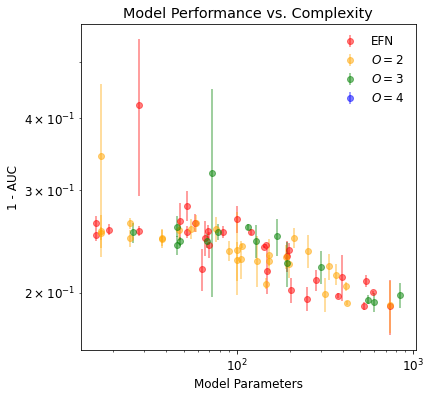

15 3 [2 2 2] 55
Epoch 1/50
150/150 - 3s - loss: 0.6933 - acc: 0.5019 - val_loss: 0.6935 - val_acc: 0.4625
Epoch 2/50
150/150 - 3s - loss: 0.6930 - acc: 0.5083 - val_loss: 0.6912 - val_acc: 0.6215
Epoch 3/50
150/150 - 3s - loss: 0.6665 - acc: 0.6405 - val_loss: 0.6439 - val_acc: 0.6865
Epoch 4/50
150/150 - 3s - loss: 0.6510 - acc: 0.6728 - val_loss: 0.6377 - val_acc: 0.6710
Epoch 5/50
150/150 - 3s - loss: 0.6441 - acc: 0.6674 - val_loss: 0.6338 - val_acc: 0.6615
Epoch 6/50
150/150 - 3s - loss: 0.6398 - acc: 0.6654 - val_loss: 0.6324 - val_acc: 0.6525
Epoch 7/50
150/150 - 3s - loss: 0.6348 - acc: 0.6666 - val_loss: 0.6249 - val_acc: 0.6710
Epoch 8/50
150/150 - 3s - loss: 0.6283 - acc: 0.6695 - val_loss: 0.6219 - val_acc: 0.6680
Epoch 9/50
150/150 - 3s - loss: 0.6187 - acc: 0.6765 - val_loss: 0.6131 - val_acc: 0.6840
Epoch 10/50
150/150 - 3s - loss: 0.6141 - acc: 0.6784 - val_loss: 0.6106 - val_acc: 0.6875
Epoch 11/50
150/150 - 3s - loss: 0.6104 - acc: 0.6807 - val_loss: 0.6082 - val_acc:

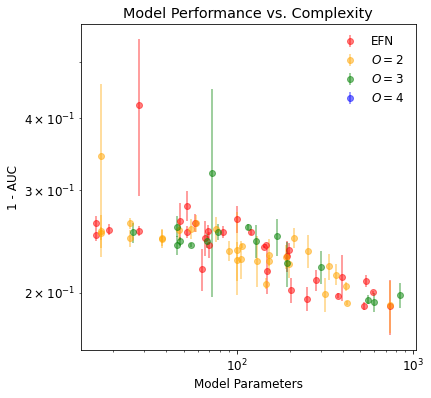

16 3 [2 1 1] 26
Epoch 1/50
150/150 - 3s - loss: 0.6931 - acc: 0.5008 - val_loss: 0.6933 - val_acc: 0.4625
Epoch 2/50
150/150 - 2s - loss: 0.6931 - acc: 0.5005 - val_loss: 0.6937 - val_acc: 0.4625
Epoch 3/50
150/150 - 2s - loss: 0.6931 - acc: 0.5019 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 4/50
150/150 - 2s - loss: 0.6931 - acc: 0.5020 - val_loss: 0.6935 - val_acc: 0.4625
Epoch 5/50
150/150 - 2s - loss: 0.6931 - acc: 0.5238 - val_loss: 0.6931 - val_acc: 0.4940
Epoch 6/50
150/150 - 2s - loss: 0.6899 - acc: 0.5084 - val_loss: 0.6750 - val_acc: 0.5395
Epoch 7/50
150/150 - 2s - loss: 0.6640 - acc: 0.6291 - val_loss: 0.6468 - val_acc: 0.5995
Epoch 8/50
150/150 - 2s - loss: 0.6320 - acc: 0.6469 - val_loss: 0.6224 - val_acc: 0.6550
Epoch 9/50
150/150 - 2s - loss: 0.6194 - acc: 0.6721 - val_loss: 0.6145 - val_acc: 0.6765
Epoch 10/50
150/150 - 2s - loss: 0.6146 - acc: 0.6775 - val_loss: 0.6166 - val_acc: 0.6640
Epoch 11/50
150/150 - 2s - loss: 0.6119 - acc: 0.6776 - val_loss: 0.6083 - val_acc:

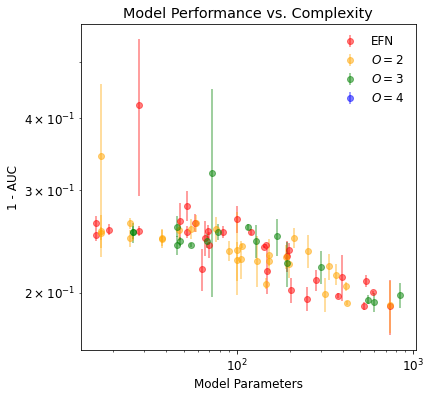

17 3 [ 2 14  3] 618
Epoch 1/50
150/150 - 3s - loss: 0.6933 - acc: 0.5659 - val_loss: 0.6687 - val_acc: 0.6340
Epoch 2/50
150/150 - 3s - loss: 0.6367 - acc: 0.6518 - val_loss: 0.6160 - val_acc: 0.6580
Epoch 3/50
150/150 - 3s - loss: 0.6022 - acc: 0.6742 - val_loss: 0.5823 - val_acc: 0.6960
Epoch 4/50
150/150 - 3s - loss: 0.5854 - acc: 0.6881 - val_loss: 0.5730 - val_acc: 0.7030
Epoch 5/50
150/150 - 3s - loss: 0.5807 - acc: 0.6919 - val_loss: 0.5707 - val_acc: 0.7035
Epoch 6/50
150/150 - 3s - loss: 0.5787 - acc: 0.6924 - val_loss: 0.5685 - val_acc: 0.7030
Epoch 7/50
150/150 - 3s - loss: 0.5765 - acc: 0.6940 - val_loss: 0.5676 - val_acc: 0.7040
Epoch 8/50
150/150 - 3s - loss: 0.5750 - acc: 0.6943 - val_loss: 0.5650 - val_acc: 0.7085
Epoch 9/50
150/150 - 3s - loss: 0.5721 - acc: 0.6974 - val_loss: 0.5650 - val_acc: 0.7090
Epoch 10/50
150/150 - 3s - loss: 0.5691 - acc: 0.7007 - val_loss: 0.5600 - val_acc: 0.7115
Epoch 11/50
150/150 - 3s - loss: 0.5659 - acc: 0.7058 - val_loss: 0.5655 - val_

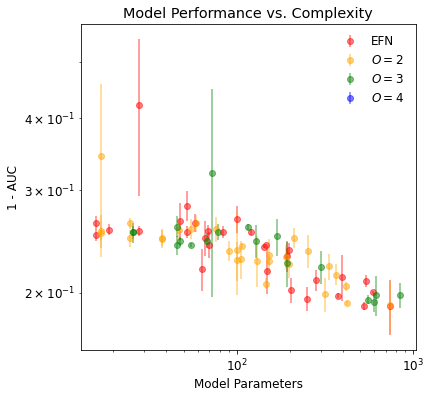

18 3 [2 2 6] 111
Epoch 1/50
150/150 - 3s - loss: 0.6853 - acc: 0.5623 - val_loss: 0.6706 - val_acc: 0.6255
Epoch 2/50
150/150 - 3s - loss: 0.6330 - acc: 0.6651 - val_loss: 0.6097 - val_acc: 0.6945
Epoch 3/50
150/150 - 3s - loss: 0.5987 - acc: 0.6903 - val_loss: 0.5862 - val_acc: 0.7045
Epoch 4/50
150/150 - 3s - loss: 0.5848 - acc: 0.6932 - val_loss: 0.5751 - val_acc: 0.7065
Epoch 5/50
150/150 - 3s - loss: 0.5792 - acc: 0.6937 - val_loss: 0.5708 - val_acc: 0.7060
Epoch 6/50
150/150 - 3s - loss: 0.5769 - acc: 0.6938 - val_loss: 0.5720 - val_acc: 0.7030
Epoch 7/50
150/150 - 3s - loss: 0.5767 - acc: 0.6935 - val_loss: 0.5680 - val_acc: 0.7050
Epoch 8/50
150/150 - 3s - loss: 0.5760 - acc: 0.6930 - val_loss: 0.5684 - val_acc: 0.7060
Epoch 9/50
150/150 - 3s - loss: 0.5754 - acc: 0.6933 - val_loss: 0.5687 - val_acc: 0.7045
Epoch 10/50
150/150 - 3s - loss: 0.5747 - acc: 0.6930 - val_loss: 0.5666 - val_acc: 0.7095
Epoch 11/50
150/150 - 3s - loss: 0.5746 - acc: 0.6934 - val_loss: 0.5678 - val_acc

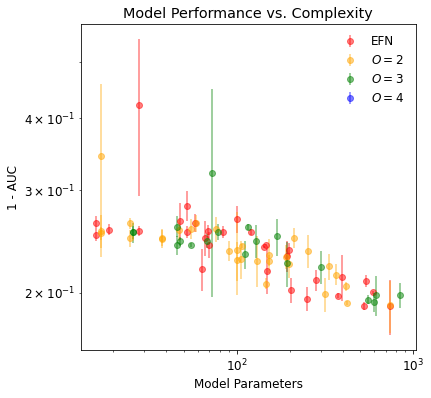

19 3 [1 1 2] 26
Epoch 1/50
150/150 - 2s - loss: 0.6916 - acc: 0.5312 - val_loss: 0.6884 - val_acc: 0.5835
Epoch 2/50
150/150 - 1s - loss: 0.6707 - acc: 0.6221 - val_loss: 0.6472 - val_acc: 0.6780
Epoch 3/50
150/150 - 1s - loss: 0.6167 - acc: 0.6803 - val_loss: 0.6023 - val_acc: 0.6940
Epoch 4/50
150/150 - 1s - loss: 0.5912 - acc: 0.6888 - val_loss: 0.5914 - val_acc: 0.6975
Epoch 5/50
150/150 - 1s - loss: 0.5854 - acc: 0.6909 - val_loss: 0.5866 - val_acc: 0.7015
Epoch 6/50
150/150 - 1s - loss: 0.5827 - acc: 0.6923 - val_loss: 0.5841 - val_acc: 0.7015
Epoch 7/50
150/150 - 1s - loss: 0.5814 - acc: 0.6934 - val_loss: 0.5816 - val_acc: 0.6990
Epoch 8/50
150/150 - 1s - loss: 0.5801 - acc: 0.6933 - val_loss: 0.5822 - val_acc: 0.7040
Epoch 9/50
150/150 - 1s - loss: 0.5802 - acc: 0.6935 - val_loss: 0.5815 - val_acc: 0.7035
Epoch 10/50
150/150 - 1s - loss: 0.5791 - acc: 0.6939 - val_loss: 0.5786 - val_acc: 0.7045
Epoch 11/50
150/150 - 1s - loss: 0.5793 - acc: 0.6946 - val_loss: 0.5785 - val_acc:

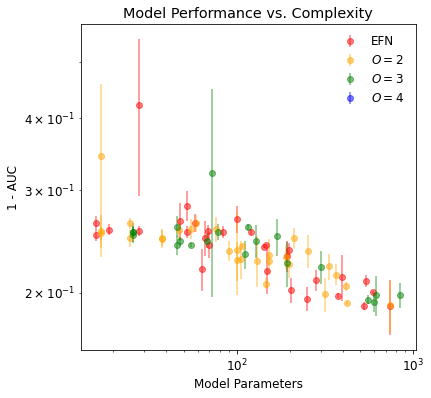

20 3 [1 3 1] 50
Epoch 1/50
150/150 - 1s - loss: 0.6906 - acc: 0.5375 - val_loss: 0.6738 - val_acc: 0.6260
Epoch 2/50
150/150 - 1s - loss: 0.6556 - acc: 0.6375 - val_loss: 0.6426 - val_acc: 0.6420
Epoch 3/50
150/150 - 1s - loss: 0.6426 - acc: 0.6454 - val_loss: 0.6378 - val_acc: 0.6560
Epoch 4/50
150/150 - 1s - loss: 0.6394 - acc: 0.6504 - val_loss: 0.6393 - val_acc: 0.6365
Epoch 5/50
150/150 - 1s - loss: 0.6365 - acc: 0.6548 - val_loss: 0.6330 - val_acc: 0.6535
Epoch 6/50
150/150 - 1s - loss: 0.6326 - acc: 0.6589 - val_loss: 0.6292 - val_acc: 0.6580
Epoch 7/50
150/150 - 1s - loss: 0.6286 - acc: 0.6621 - val_loss: 0.6238 - val_acc: 0.6750
Epoch 8/50
150/150 - 1s - loss: 0.6245 - acc: 0.6664 - val_loss: 0.6200 - val_acc: 0.6740
Epoch 9/50
150/150 - 1s - loss: 0.6192 - acc: 0.6701 - val_loss: 0.6144 - val_acc: 0.6705
Epoch 10/50
150/150 - 1s - loss: 0.6128 - acc: 0.6739 - val_loss: 0.6070 - val_acc: 0.6825
Epoch 11/50
150/150 - 1s - loss: 0.6069 - acc: 0.6783 - val_loss: 0.6039 - val_acc:

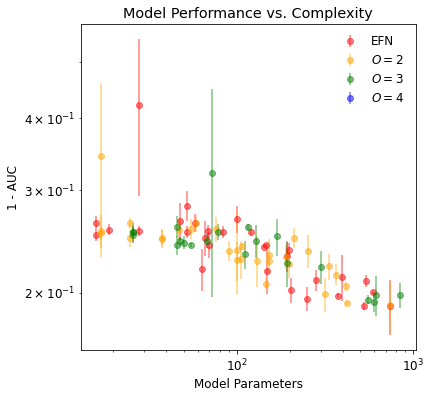

21 3 [1 1 2] 26
Epoch 1/50
150/150 - 1s - loss: 0.6931 - acc: 0.5022 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 2/50
150/150 - 1s - loss: 0.6929 - acc: 0.5200 - val_loss: 0.6925 - val_acc: 0.5270
Epoch 3/50
150/150 - 1s - loss: 0.6783 - acc: 0.6072 - val_loss: 0.6575 - val_acc: 0.6370
Epoch 4/50
150/150 - 1s - loss: 0.6419 - acc: 0.6631 - val_loss: 0.6416 - val_acc: 0.6620
Epoch 5/50
150/150 - 1s - loss: 0.6318 - acc: 0.6742 - val_loss: 0.6302 - val_acc: 0.6735
Epoch 6/50
150/150 - 1s - loss: 0.6225 - acc: 0.6788 - val_loss: 0.6258 - val_acc: 0.6760
Epoch 7/50
150/150 - 1s - loss: 0.6146 - acc: 0.6844 - val_loss: 0.6134 - val_acc: 0.6925
Epoch 8/50
150/150 - 1s - loss: 0.6084 - acc: 0.6880 - val_loss: 0.6079 - val_acc: 0.6940
Epoch 9/50
150/150 - 1s - loss: 0.6043 - acc: 0.6884 - val_loss: 0.6046 - val_acc: 0.6925
Epoch 10/50
150/150 - 1s - loss: 0.6021 - acc: 0.6878 - val_loss: 0.6017 - val_acc: 0.6950
Epoch 11/50
150/150 - 1s - loss: 0.6004 - acc: 0.6885 - val_loss: 0.5992 - val_acc:

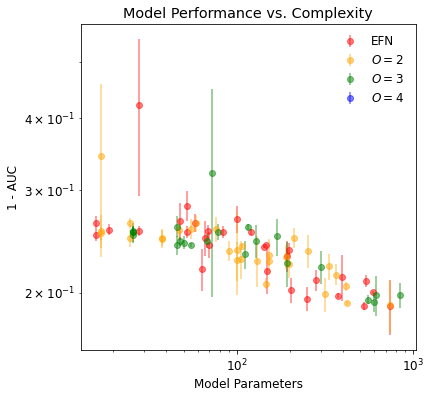

22 3 [ 1 17  2] 730
Epoch 1/50
150/150 - 2s - loss: 0.6908 - acc: 0.5415 - val_loss: 0.6841 - val_acc: 0.5555
Epoch 2/50
150/150 - 1s - loss: 0.6449 - acc: 0.6460 - val_loss: 0.6215 - val_acc: 0.6405
Epoch 3/50
150/150 - 1s - loss: 0.6105 - acc: 0.6679 - val_loss: 0.5965 - val_acc: 0.6900
Epoch 4/50
150/150 - 2s - loss: 0.5960 - acc: 0.6799 - val_loss: 0.5841 - val_acc: 0.6935
Epoch 5/50
150/150 - 1s - loss: 0.5860 - acc: 0.6859 - val_loss: 0.5778 - val_acc: 0.7015
Epoch 6/50
150/150 - 1s - loss: 0.5810 - acc: 0.6887 - val_loss: 0.5678 - val_acc: 0.7060
Epoch 7/50
150/150 - 1s - loss: 0.5759 - acc: 0.6935 - val_loss: 0.5644 - val_acc: 0.7085
Epoch 8/50
150/150 - 1s - loss: 0.5728 - acc: 0.6994 - val_loss: 0.5610 - val_acc: 0.7215
Epoch 9/50
150/150 - 2s - loss: 0.5691 - acc: 0.7024 - val_loss: 0.5534 - val_acc: 0.7205
Epoch 10/50
150/150 - 2s - loss: 0.5658 - acc: 0.7066 - val_loss: 0.5520 - val_acc: 0.7235
Epoch 11/50
150/150 - 1s - loss: 0.5626 - acc: 0.7102 - val_loss: 0.5465 - val_

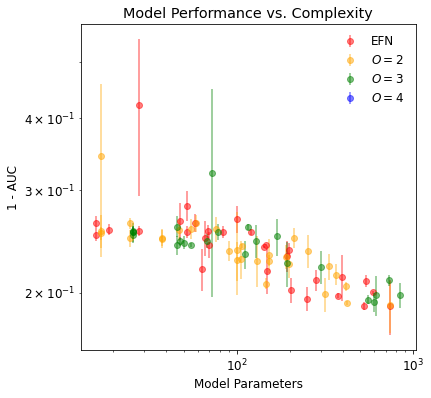

23 3 [ 1  1 15] 312
Epoch 1/50
150/150 - 2s - loss: 0.6849 - acc: 0.5679 - val_loss: 0.6537 - val_acc: 0.7035
Epoch 2/50
150/150 - 2s - loss: 0.6559 - acc: 0.6833 - val_loss: 0.6431 - val_acc: 0.6815
Epoch 3/50
150/150 - 2s - loss: 0.6481 - acc: 0.6718 - val_loss: 0.6395 - val_acc: 0.6835
Epoch 4/50
150/150 - 2s - loss: 0.6438 - acc: 0.6637 - val_loss: 0.6390 - val_acc: 0.6490
Epoch 5/50
150/150 - 2s - loss: 0.6407 - acc: 0.6583 - val_loss: 0.6354 - val_acc: 0.6525
Epoch 6/50
150/150 - 2s - loss: 0.6384 - acc: 0.6557 - val_loss: 0.6330 - val_acc: 0.6520
Epoch 7/50
150/150 - 2s - loss: 0.6367 - acc: 0.6536 - val_loss: 0.6307 - val_acc: 0.6540
Epoch 8/50
150/150 - 2s - loss: 0.6354 - acc: 0.6537 - val_loss: 0.6291 - val_acc: 0.6535
Epoch 9/50
150/150 - 2s - loss: 0.6340 - acc: 0.6533 - val_loss: 0.6351 - val_acc: 0.6295
Epoch 10/50
150/150 - 2s - loss: 0.6331 - acc: 0.6529 - val_loss: 0.6304 - val_acc: 0.6405
Epoch 11/50
150/150 - 2s - loss: 0.6318 - acc: 0.6531 - val_loss: 0.6244 - val_

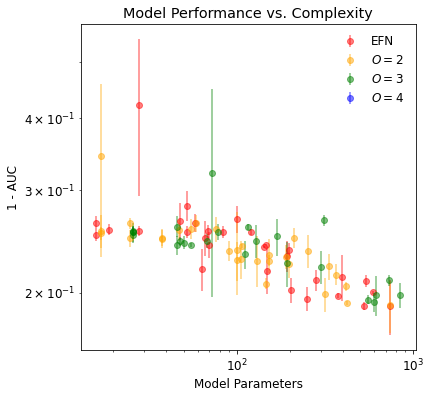

24 3 [2 6 3] 186
Epoch 1/50
150/150 - 3s - loss: 0.6987 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.4625
Epoch 2/50
150/150 - 3s - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.5375
Epoch 3/50
150/150 - 3s - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6941 - val_acc: 0.4625
Epoch 4/50
150/150 - 3s - loss: 0.6930 - acc: 0.5041 - val_loss: 0.6927 - val_acc: 0.5765
Epoch 5/50
150/150 - 3s - loss: 0.6910 - acc: 0.5484 - val_loss: 0.6848 - val_acc: 0.6435
Epoch 6/50
150/150 - 3s - loss: 0.6388 - acc: 0.6701 - val_loss: 0.6137 - val_acc: 0.6690
Epoch 7/50
150/150 - 3s - loss: 0.6043 - acc: 0.6792 - val_loss: 0.5979 - val_acc: 0.6835
Epoch 8/50
150/150 - 3s - loss: 0.5918 - acc: 0.6873 - val_loss: 0.5869 - val_acc: 0.6935
Epoch 9/50
150/150 - 3s - loss: 0.5853 - acc: 0.6917 - val_loss: 0.5815 - val_acc: 0.6950
Epoch 10/50
150/150 - 3s - loss: 0.5825 - acc: 0.6920 - val_loss: 0.5802 - val_acc: 0.6975
Epoch 11/50
150/150 - 3s - loss: 0.5807 - acc: 0.6920 - val_loss: 0.5776 - val_acc

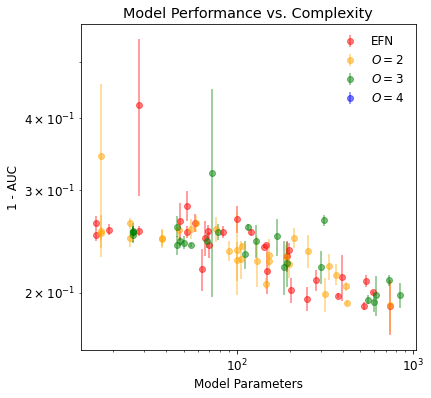

25 3 [1 1 1] 18
Epoch 1/50
150/150 - 2s - loss: 0.6931 - acc: 0.5020 - val_loss: 0.6936 - val_acc: 0.4625
Epoch 2/50
150/150 - 1s - loss: 0.6931 - acc: 0.5038 - val_loss: 0.6935 - val_acc: 0.4625
Epoch 3/50
150/150 - 1s - loss: 0.6929 - acc: 0.5124 - val_loss: 0.6934 - val_acc: 0.4625
Epoch 4/50
150/150 - 1s - loss: 0.6920 - acc: 0.5525 - val_loss: 0.6917 - val_acc: 0.5055
Epoch 5/50
150/150 - 1s - loss: 0.6850 - acc: 0.5684 - val_loss: 0.6787 - val_acc: 0.5705
Epoch 6/50
150/150 - 1s - loss: 0.6517 - acc: 0.6358 - val_loss: 0.6331 - val_acc: 0.6425
Epoch 7/50
150/150 - 1s - loss: 0.6082 - acc: 0.6765 - val_loss: 0.5983 - val_acc: 0.6830
Epoch 8/50
150/150 - 1s - loss: 0.5943 - acc: 0.6839 - val_loss: 0.5927 - val_acc: 0.6855
Epoch 9/50
150/150 - 1s - loss: 0.5915 - acc: 0.6859 - val_loss: 0.5889 - val_acc: 0.6930
Epoch 10/50
150/150 - 1s - loss: 0.5902 - acc: 0.6869 - val_loss: 0.5872 - val_acc: 0.6915
Epoch 11/50
150/150 - 1s - loss: 0.5887 - acc: 0.6889 - val_loss: 0.5869 - val_acc:

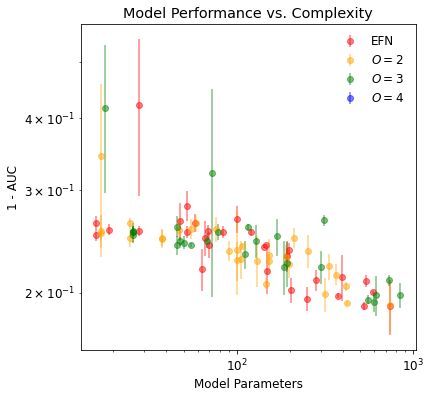

26 3 [ 1 13  3] 468
Epoch 1/50
150/150 - 2s - loss: 0.6920 - acc: 0.5203 - val_loss: 0.6870 - val_acc: 0.5375
Epoch 2/50
150/150 - 1s - loss: 0.6779 - acc: 0.6082 - val_loss: 0.6551 - val_acc: 0.6270
Epoch 3/50
150/150 - 1s - loss: 0.6364 - acc: 0.6514 - val_loss: 0.6227 - val_acc: 0.6515
Epoch 4/50
150/150 - 1s - loss: 0.6218 - acc: 0.6629 - val_loss: 0.6127 - val_acc: 0.6725
Epoch 5/50
150/150 - 1s - loss: 0.6139 - acc: 0.6704 - val_loss: 0.6049 - val_acc: 0.6900
Epoch 6/50
150/150 - 1s - loss: 0.6075 - acc: 0.6754 - val_loss: 0.5977 - val_acc: 0.6830
Epoch 7/50
150/150 - 1s - loss: 0.5999 - acc: 0.6796 - val_loss: 0.5956 - val_acc: 0.6800
Epoch 8/50
150/150 - 1s - loss: 0.5929 - acc: 0.6836 - val_loss: 0.5905 - val_acc: 0.6825
Epoch 9/50
150/150 - 1s - loss: 0.5854 - acc: 0.6882 - val_loss: 0.5781 - val_acc: 0.6955
Epoch 10/50
150/150 - 1s - loss: 0.5813 - acc: 0.6910 - val_loss: 0.5811 - val_acc: 0.6955
Epoch 11/50
150/150 - 1s - loss: 0.5792 - acc: 0.6914 - val_loss: 0.5791 - val_

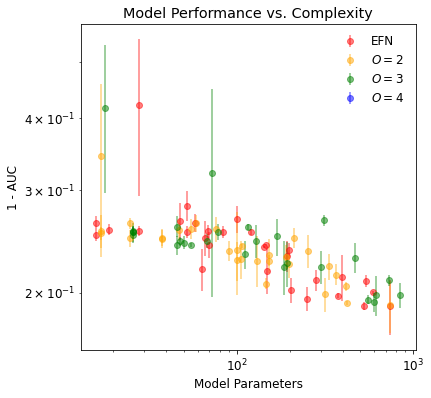

27 3 [1 3 2] 58
Epoch 1/50
150/150 - 2s - loss: 0.6926 - acc: 0.5133 - val_loss: 0.6900 - val_acc: 0.5375
Epoch 2/50
150/150 - 1s - loss: 0.6675 - acc: 0.6555 - val_loss: 0.6434 - val_acc: 0.6545
Epoch 3/50
150/150 - 1s - loss: 0.6358 - acc: 0.6617 - val_loss: 0.6294 - val_acc: 0.6480
Epoch 4/50
150/150 - 1s - loss: 0.6263 - acc: 0.6601 - val_loss: 0.6213 - val_acc: 0.6585
Epoch 5/50
150/150 - 1s - loss: 0.6209 - acc: 0.6633 - val_loss: 0.6164 - val_acc: 0.6630
Epoch 6/50
150/150 - 1s - loss: 0.6169 - acc: 0.6673 - val_loss: 0.6110 - val_acc: 0.6695
Epoch 7/50
150/150 - 1s - loss: 0.6141 - acc: 0.6699 - val_loss: 0.6077 - val_acc: 0.6740
Epoch 8/50
150/150 - 1s - loss: 0.6116 - acc: 0.6728 - val_loss: 0.6054 - val_acc: 0.6785
Epoch 9/50
150/150 - 1s - loss: 0.6098 - acc: 0.6742 - val_loss: 0.6035 - val_acc: 0.6820
Epoch 10/50
150/150 - 1s - loss: 0.6079 - acc: 0.6756 - val_loss: 0.6033 - val_acc: 0.6815
Epoch 11/50
150/150 - 1s - loss: 0.6065 - acc: 0.6766 - val_loss: 0.6063 - val_acc:

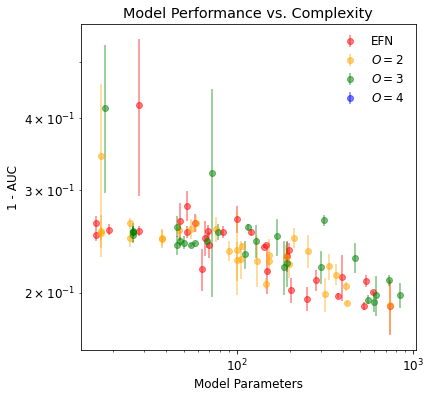

28 3 [1 4 6] 132
Epoch 1/50
150/150 - 2s - loss: 0.7545 - acc: 0.5019 - val_loss: 0.7010 - val_acc: 0.4625
Epoch 2/50
150/150 - 2s - loss: 0.6935 - acc: 0.5019 - val_loss: 0.6931 - val_acc: 0.5375
Epoch 3/50
150/150 - 2s - loss: 0.6931 - acc: 0.5012 - val_loss: 0.6929 - val_acc: 0.5375
Epoch 4/50
150/150 - 2s - loss: 0.6931 - acc: 0.5065 - val_loss: 0.6937 - val_acc: 0.4625
Epoch 5/50
150/150 - 2s - loss: 0.6930 - acc: 0.5063 - val_loss: 0.6947 - val_acc: 0.4625
Epoch 6/50
150/150 - 2s - loss: 0.6927 - acc: 0.5370 - val_loss: 0.6921 - val_acc: 0.6870
Epoch 7/50
150/150 - 2s - loss: 0.6901 - acc: 0.6067 - val_loss: 0.6842 - val_acc: 0.7040
Epoch 8/50
150/150 - 2s - loss: 0.6688 - acc: 0.6763 - val_loss: 0.6461 - val_acc: 0.6610
Epoch 9/50
150/150 - 2s - loss: 0.6244 - acc: 0.6764 - val_loss: 0.6048 - val_acc: 0.6790
Epoch 10/50
150/150 - 2s - loss: 0.6000 - acc: 0.6843 - val_loss: 0.5918 - val_acc: 0.6870
Epoch 11/50
150/150 - 2s - loss: 0.5903 - acc: 0.6875 - val_loss: 0.5853 - val_acc

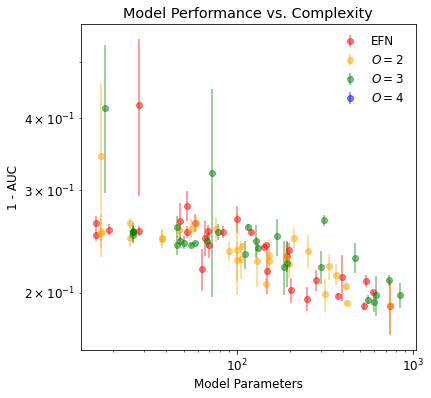

29 3 [ 2 17  8] 931
Epoch 1/50
150/150 - 3s - loss: 0.7128 - acc: 0.5548 - val_loss: 0.6892 - val_acc: 0.5485
Epoch 2/50
150/150 - 3s - loss: 0.6600 - acc: 0.6362 - val_loss: 0.6222 - val_acc: 0.6625
Epoch 3/50
150/150 - 3s - loss: 0.6122 - acc: 0.6762 - val_loss: 0.5988 - val_acc: 0.6915
Epoch 4/50
150/150 - 3s - loss: 0.5939 - acc: 0.6946 - val_loss: 0.5853 - val_acc: 0.7030
Epoch 5/50
150/150 - 3s - loss: 0.5878 - acc: 0.6947 - val_loss: 0.5812 - val_acc: 0.7015
Epoch 6/50
150/150 - 3s - loss: 0.5836 - acc: 0.6964 - val_loss: 0.5819 - val_acc: 0.7020
Epoch 7/50
150/150 - 3s - loss: 0.5813 - acc: 0.6961 - val_loss: 0.5773 - val_acc: 0.7030
Epoch 8/50
150/150 - 3s - loss: 0.5784 - acc: 0.6976 - val_loss: 0.5694 - val_acc: 0.7030
Epoch 9/50
150/150 - 3s - loss: 0.5745 - acc: 0.6975 - val_loss: 0.5696 - val_acc: 0.7040
Epoch 10/50
150/150 - 3s - loss: 0.5711 - acc: 0.7000 - val_loss: 0.5616 - val_acc: 0.7070
Epoch 11/50
150/150 - 3s - loss: 0.5673 - acc: 0.7029 - val_loss: 0.5611 - val_

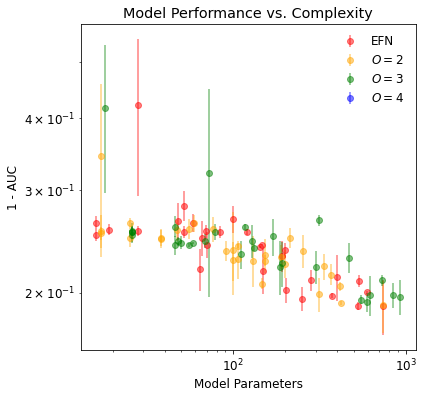

0 4 [1 3 6] 113
Epoch 1/50
150/150 - 2s - loss: 0.6831 - acc: 0.6094 - val_loss: 0.6621 - val_acc: 0.6765
Epoch 2/50
150/150 - 2s - loss: 0.6353 - acc: 0.6763 - val_loss: 0.6146 - val_acc: 0.6775
Epoch 3/50
150/150 - 2s - loss: 0.6100 - acc: 0.6795 - val_loss: 0.6021 - val_acc: 0.6815
Epoch 4/50
150/150 - 2s - loss: 0.5947 - acc: 0.6866 - val_loss: 0.5865 - val_acc: 0.6960
Epoch 5/50
150/150 - 2s - loss: 0.5856 - acc: 0.6901 - val_loss: 0.5845 - val_acc: 0.6945
Epoch 6/50
150/150 - 2s - loss: 0.5823 - acc: 0.6913 - val_loss: 0.5806 - val_acc: 0.7000
Epoch 7/50
150/150 - 2s - loss: 0.5808 - acc: 0.6914 - val_loss: 0.5813 - val_acc: 0.6930
Epoch 8/50
150/150 - 2s - loss: 0.5796 - acc: 0.6924 - val_loss: 0.5806 - val_acc: 0.7035
Epoch 9/50
150/150 - 2s - loss: 0.5791 - acc: 0.6918 - val_loss: 0.5755 - val_acc: 0.7030
Epoch 10/50
150/150 - 2s - loss: 0.5777 - acc: 0.6926 - val_loss: 0.5737 - val_acc: 0.7035
Epoch 11/50
150/150 - 2s - loss: 0.5773 - acc: 0.6933 - val_loss: 0.5733 - val_acc:

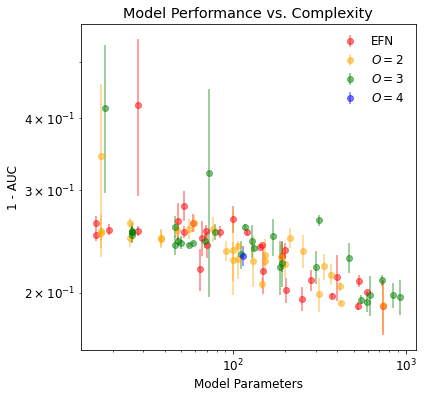

1 4 [1 2 4] 64
Epoch 1/50
150/150 - 2s - loss: 0.7214 - acc: 0.5011 - val_loss: 0.6917 - val_acc: 0.5370
Epoch 2/50
150/150 - 1s - loss: 0.6909 - acc: 0.5707 - val_loss: 0.6914 - val_acc: 0.4885
Epoch 3/50
150/150 - 2s - loss: 0.6846 - acc: 0.5537 - val_loss: 0.6821 - val_acc: 0.5085
Epoch 4/50
150/150 - 2s - loss: 0.6725 - acc: 0.5911 - val_loss: 0.6694 - val_acc: 0.6130
Epoch 5/50
150/150 - 2s - loss: 0.6597 - acc: 0.6329 - val_loss: 0.6580 - val_acc: 0.6145
Epoch 6/50
150/150 - 1s - loss: 0.6437 - acc: 0.6489 - val_loss: 0.6337 - val_acc: 0.6555
Epoch 7/50
150/150 - 1s - loss: 0.6277 - acc: 0.6599 - val_loss: 0.6201 - val_acc: 0.6565
Epoch 8/50
150/150 - 1s - loss: 0.6173 - acc: 0.6666 - val_loss: 0.6098 - val_acc: 0.7015
Epoch 9/50
150/150 - 1s - loss: 0.6130 - acc: 0.6691 - val_loss: 0.6047 - val_acc: 0.6845
Epoch 10/50
150/150 - 1s - loss: 0.6104 - acc: 0.6702 - val_loss: 0.6030 - val_acc: 0.6845
Epoch 11/50
150/150 - 1s - loss: 0.6087 - acc: 0.6716 - val_loss: 0.6074 - val_acc: 

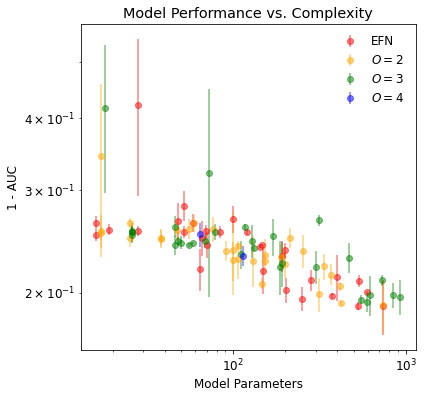

2 4 [2 1 2] 40
Epoch 1/50
150/150 - 3s - loss: 0.6933 - acc: 0.5639 - val_loss: 0.6905 - val_acc: 0.6900
Epoch 2/50
150/150 - 3s - loss: 0.6758 - acc: 0.6738 - val_loss: 0.6504 - val_acc: 0.6975
Epoch 3/50
150/150 - 3s - loss: 0.6557 - acc: 0.6745 - val_loss: 0.6446 - val_acc: 0.6540
Epoch 4/50
150/150 - 3s - loss: 0.6468 - acc: 0.6643 - val_loss: 0.6357 - val_acc: 0.6765
Epoch 5/50
150/150 - 3s - loss: 0.6413 - acc: 0.6610 - val_loss: 0.6334 - val_acc: 0.6500
Epoch 6/50
150/150 - 3s - loss: 0.6378 - acc: 0.6587 - val_loss: 0.6300 - val_acc: 0.6645
Epoch 7/50
150/150 - 3s - loss: 0.6358 - acc: 0.6558 - val_loss: 0.6295 - val_acc: 0.6545
Epoch 8/50
150/150 - 3s - loss: 0.6349 - acc: 0.6541 - val_loss: 0.6309 - val_acc: 0.6490
Epoch 9/50
150/150 - 3s - loss: 0.6336 - acc: 0.6530 - val_loss: 0.6300 - val_acc: 0.6485
Epoch 10/50
150/150 - 3s - loss: 0.6332 - acc: 0.6524 - val_loss: 0.6294 - val_acc: 0.6500
Epoch 11/50
150/150 - 3s - loss: 0.6328 - acc: 0.6520 - val_loss: 0.6308 - val_acc: 

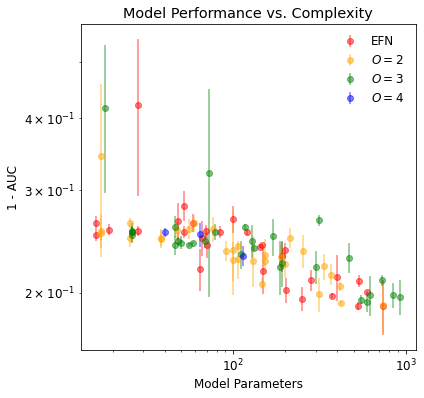

3 4 [2 2 4] 89
Epoch 1/50
150/150 - 3s - loss: 0.6932 - acc: 0.5402 - val_loss: 0.6894 - val_acc: 0.5380
Epoch 2/50
150/150 - 3s - loss: 0.6701 - acc: 0.6099 - val_loss: 0.6467 - val_acc: 0.6795
Epoch 3/50
150/150 - 3s - loss: 0.6447 - acc: 0.6794 - val_loss: 0.6288 - val_acc: 0.6760
Epoch 4/50
150/150 - 3s - loss: 0.6315 - acc: 0.6786 - val_loss: 0.6210 - val_acc: 0.6800
Epoch 5/50
150/150 - 3s - loss: 0.6230 - acc: 0.6825 - val_loss: 0.6117 - val_acc: 0.6910
Epoch 6/50
150/150 - 3s - loss: 0.6162 - acc: 0.6851 - val_loss: 0.6057 - val_acc: 0.6905
Epoch 7/50
150/150 - 3s - loss: 0.6099 - acc: 0.6867 - val_loss: 0.6034 - val_acc: 0.6880
Epoch 8/50
150/150 - 3s - loss: 0.6060 - acc: 0.6877 - val_loss: 0.5973 - val_acc: 0.6935
Epoch 9/50
150/150 - 3s - loss: 0.6022 - acc: 0.6883 - val_loss: 0.5979 - val_acc: 0.6905
Epoch 10/50
150/150 - 3s - loss: 0.5995 - acc: 0.6900 - val_loss: 0.5991 - val_acc: 0.6870
Epoch 11/50
150/150 - 3s - loss: 0.5960 - acc: 0.6909 - val_loss: 0.5944 - val_acc: 

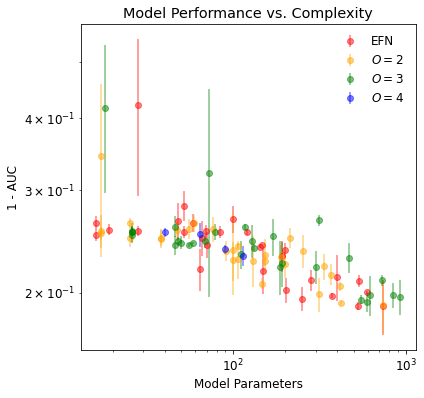

4 4 [2 1 2] 40
Epoch 1/50
150/150 - 3s - loss: 0.6912 - acc: 0.5184 - val_loss: 0.6781 - val_acc: 0.5375
Epoch 2/50
150/150 - 3s - loss: 0.6721 - acc: 0.6538 - val_loss: 0.6682 - val_acc: 0.6275
Epoch 3/50
150/150 - 3s - loss: 0.6656 - acc: 0.6430 - val_loss: 0.6635 - val_acc: 0.6320
Epoch 4/50
150/150 - 3s - loss: 0.6622 - acc: 0.6364 - val_loss: 0.6612 - val_acc: 0.6295
Epoch 5/50
150/150 - 3s - loss: 0.6595 - acc: 0.6351 - val_loss: 0.6589 - val_acc: 0.6260
Epoch 6/50
150/150 - 3s - loss: 0.6572 - acc: 0.6347 - val_loss: 0.6569 - val_acc: 0.6215
Epoch 7/50
150/150 - 3s - loss: 0.6548 - acc: 0.6361 - val_loss: 0.6547 - val_acc: 0.6230
Epoch 8/50
150/150 - 3s - loss: 0.6524 - acc: 0.6357 - val_loss: 0.6507 - val_acc: 0.6360
Epoch 9/50
150/150 - 3s - loss: 0.6504 - acc: 0.6391 - val_loss: 0.6502 - val_acc: 0.6225
Epoch 10/50
150/150 - 3s - loss: 0.6484 - acc: 0.6374 - val_loss: 0.6441 - val_acc: 0.6585
Epoch 11/50
150/150 - 3s - loss: 0.6462 - acc: 0.6389 - val_loss: 0.6409 - val_acc: 

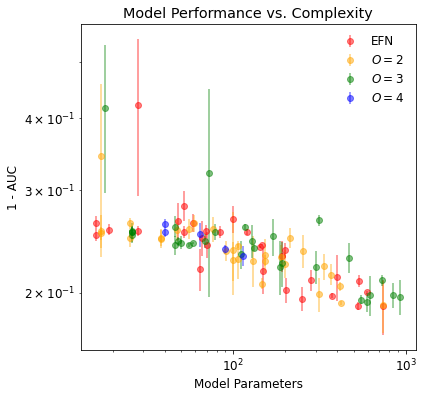

5 4 [1 3 6] 113
Epoch 1/50
150/150 - 2s - loss: 0.7307 - acc: 0.5019 - val_loss: 0.7000 - val_acc: 0.4625
Epoch 2/50
150/150 - 2s - loss: 0.6932 - acc: 0.5278 - val_loss: 0.6929 - val_acc: 0.4935
Epoch 3/50
150/150 - 2s - loss: 0.6918 - acc: 0.5793 - val_loss: 0.6880 - val_acc: 0.6945
Epoch 4/50
150/150 - 2s - loss: 0.6717 - acc: 0.6579 - val_loss: 0.6457 - val_acc: 0.6635
Epoch 5/50
150/150 - 2s - loss: 0.6271 - acc: 0.6686 - val_loss: 0.6201 - val_acc: 0.6695
Epoch 6/50
150/150 - 2s - loss: 0.6115 - acc: 0.6735 - val_loss: 0.6110 - val_acc: 0.6755
Epoch 7/50
150/150 - 2s - loss: 0.6039 - acc: 0.6771 - val_loss: 0.6064 - val_acc: 0.6800
Epoch 8/50
150/150 - 2s - loss: 0.5988 - acc: 0.6814 - val_loss: 0.6009 - val_acc: 0.6855
Epoch 9/50
150/150 - 2s - loss: 0.5948 - acc: 0.6841 - val_loss: 0.5980 - val_acc: 0.6865
Epoch 10/50
150/150 - 2s - loss: 0.5916 - acc: 0.6868 - val_loss: 0.5940 - val_acc: 0.6840
Epoch 11/50
150/150 - 2s - loss: 0.5889 - acc: 0.6886 - val_loss: 0.5917 - val_acc:

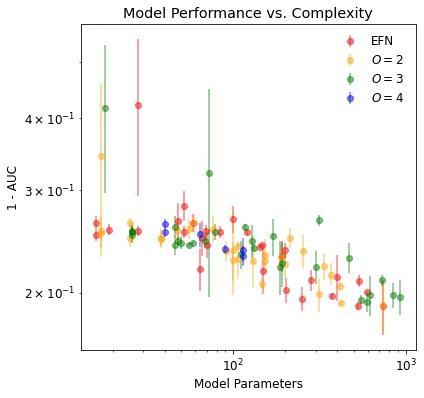

6 4 [ 3  6 10] 480
Epoch 1/50
150/150 - 8s - loss: 0.6684 - acc: 0.6119 - val_loss: 0.6135 - val_acc: 0.6695
Epoch 2/50
150/150 - 8s - loss: 0.5968 - acc: 0.6884 - val_loss: 0.5894 - val_acc: 0.6905
Epoch 3/50
150/150 - 8s - loss: 0.5835 - acc: 0.6960 - val_loss: 0.5761 - val_acc: 0.7030
Epoch 4/50
150/150 - 8s - loss: 0.5798 - acc: 0.6967 - val_loss: 0.5702 - val_acc: 0.7020
Epoch 5/50
150/150 - 8s - loss: 0.5759 - acc: 0.6975 - val_loss: 0.5729 - val_acc: 0.6985
Epoch 6/50
150/150 - 7s - loss: 0.5747 - acc: 0.6976 - val_loss: 0.5659 - val_acc: 0.7150
Epoch 7/50
150/150 - 8s - loss: 0.5744 - acc: 0.6990 - val_loss: 0.5643 - val_acc: 0.7120
Epoch 8/50
150/150 - 8s - loss: 0.5725 - acc: 0.7003 - val_loss: 0.5653 - val_acc: 0.7105
Epoch 9/50
150/150 - 8s - loss: 0.5716 - acc: 0.6993 - val_loss: 0.5621 - val_acc: 0.7170
Epoch 10/50
150/150 - 8s - loss: 0.5711 - acc: 0.7003 - val_loss: 0.5593 - val_acc: 0.7175
Epoch 11/50
150/150 - 8s - loss: 0.5702 - acc: 0.7008 - val_loss: 0.5597 - val_a

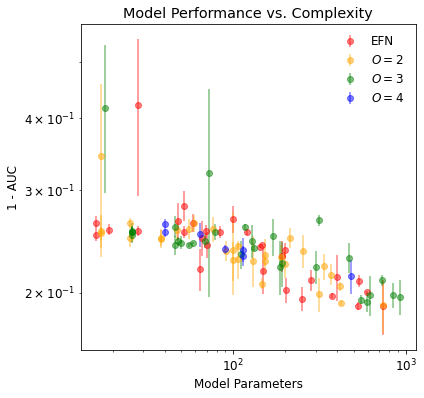

7 4 [1 2 1] 34
Epoch 1/50
150/150 - 2s - loss: 0.6966 - acc: 0.5152 - val_loss: 0.6920 - val_acc: 0.5340
Epoch 2/50
150/150 - 1s - loss: 0.6906 - acc: 0.5565 - val_loss: 0.6872 - val_acc: 0.6950
Epoch 3/50
150/150 - 1s - loss: 0.6747 - acc: 0.6355 - val_loss: 0.6558 - val_acc: 0.6710
Epoch 4/50
150/150 - 1s - loss: 0.6455 - acc: 0.6682 - val_loss: 0.6318 - val_acc: 0.6700
Epoch 5/50
150/150 - 1s - loss: 0.6297 - acc: 0.6667 - val_loss: 0.6262 - val_acc: 0.6635
Epoch 6/50
150/150 - 1s - loss: 0.6226 - acc: 0.6690 - val_loss: 0.6185 - val_acc: 0.6760
Epoch 7/50
150/150 - 1s - loss: 0.6177 - acc: 0.6723 - val_loss: 0.6152 - val_acc: 0.6720
Epoch 8/50
150/150 - 1s - loss: 0.6137 - acc: 0.6749 - val_loss: 0.6147 - val_acc: 0.6695
Epoch 9/50
150/150 - 1s - loss: 0.6100 - acc: 0.6774 - val_loss: 0.6090 - val_acc: 0.6765
Epoch 10/50
150/150 - 1s - loss: 0.6072 - acc: 0.6792 - val_loss: 0.6050 - val_acc: 0.6825
Epoch 11/50
150/150 - 1s - loss: 0.6041 - acc: 0.6809 - val_loss: 0.6026 - val_acc: 

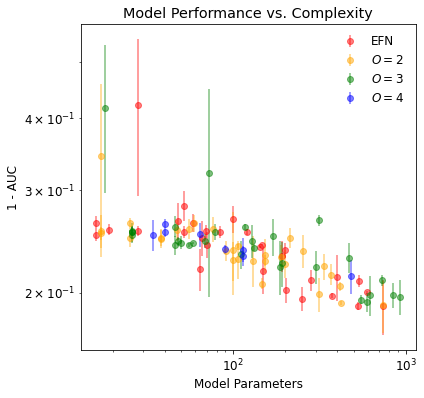

8 4 [1 1 3] 37
Epoch 1/50
150/150 - 2s - loss: 0.6914 - acc: 0.5323 - val_loss: 0.6893 - val_acc: 0.5295
Epoch 2/50
150/150 - 2s - loss: 0.6792 - acc: 0.5770 - val_loss: 0.6666 - val_acc: 0.6045
Epoch 3/50
150/150 - 2s - loss: 0.6430 - acc: 0.6296 - val_loss: 0.6194 - val_acc: 0.6695
Epoch 4/50
150/150 - 2s - loss: 0.6128 - acc: 0.6603 - val_loss: 0.5979 - val_acc: 0.6905
Epoch 5/50
150/150 - 2s - loss: 0.6011 - acc: 0.6711 - val_loss: 0.5886 - val_acc: 0.6915
Epoch 6/50
150/150 - 1s - loss: 0.5966 - acc: 0.6746 - val_loss: 0.5867 - val_acc: 0.6990
Epoch 7/50
150/150 - 2s - loss: 0.5944 - acc: 0.6781 - val_loss: 0.5835 - val_acc: 0.6995
Epoch 8/50
150/150 - 2s - loss: 0.5921 - acc: 0.6800 - val_loss: 0.5821 - val_acc: 0.6940
Epoch 9/50
150/150 - 2s - loss: 0.5903 - acc: 0.6819 - val_loss: 0.5786 - val_acc: 0.7015
Epoch 10/50
150/150 - 2s - loss: 0.5895 - acc: 0.6836 - val_loss: 0.5778 - val_acc: 0.7040
Epoch 11/50
150/150 - 2s - loss: 0.5869 - acc: 0.6857 - val_loss: 0.5766 - val_acc: 

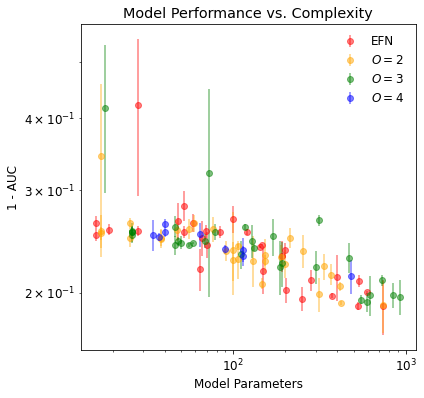

9 4 [2 9 9] 471
Epoch 1/50
150/150 - 4s - loss: 0.6617 - acc: 0.6100 - val_loss: 0.5978 - val_acc: 0.6950
Epoch 2/50
150/150 - 4s - loss: 0.5899 - acc: 0.6863 - val_loss: 0.5782 - val_acc: 0.7035
Epoch 3/50
150/150 - 4s - loss: 0.5802 - acc: 0.6923 - val_loss: 0.5714 - val_acc: 0.7060
Epoch 4/50
150/150 - 4s - loss: 0.5751 - acc: 0.6957 - val_loss: 0.5650 - val_acc: 0.7115
Epoch 5/50
150/150 - 4s - loss: 0.5709 - acc: 0.7001 - val_loss: 0.5610 - val_acc: 0.7190
Epoch 6/50
150/150 - 4s - loss: 0.5658 - acc: 0.7052 - val_loss: 0.5524 - val_acc: 0.7315
Epoch 7/50
150/150 - 4s - loss: 0.5599 - acc: 0.7131 - val_loss: 0.5441 - val_acc: 0.7320
Epoch 8/50
150/150 - 4s - loss: 0.5549 - acc: 0.7192 - val_loss: 0.5354 - val_acc: 0.7420
Epoch 9/50
150/150 - 4s - loss: 0.5530 - acc: 0.7224 - val_loss: 0.5405 - val_acc: 0.7355
Epoch 10/50
150/150 - 4s - loss: 0.5509 - acc: 0.7222 - val_loss: 0.5272 - val_acc: 0.7435
Epoch 11/50
150/150 - 4s - loss: 0.5492 - acc: 0.7244 - val_loss: 0.5313 - val_acc:

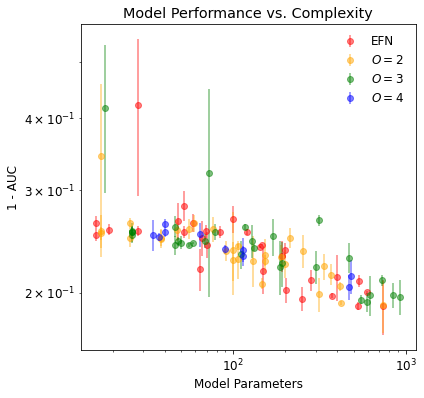

10 4 [1 4 6] 136
Epoch 1/50
150/150 - 2s - loss: 0.6932 - acc: 0.5004 - val_loss: 0.6940 - val_acc: 0.4625
Epoch 2/50
150/150 - 2s - loss: 0.6931 - acc: 0.5077 - val_loss: 0.6924 - val_acc: 0.5375
Epoch 3/50
150/150 - 2s - loss: 0.6902 - acc: 0.5761 - val_loss: 0.6813 - val_acc: 0.6135
Epoch 4/50
150/150 - 2s - loss: 0.6299 - acc: 0.6660 - val_loss: 0.6094 - val_acc: 0.6800
Epoch 5/50
150/150 - 2s - loss: 0.5993 - acc: 0.6839 - val_loss: 0.5947 - val_acc: 0.6945
Epoch 6/50
150/150 - 2s - loss: 0.5891 - acc: 0.6902 - val_loss: 0.5874 - val_acc: 0.6945
Epoch 7/50
150/150 - 2s - loss: 0.5845 - acc: 0.6924 - val_loss: 0.5856 - val_acc: 0.6915
Epoch 8/50
150/150 - 2s - loss: 0.5811 - acc: 0.6941 - val_loss: 0.5766 - val_acc: 0.7025
Epoch 9/50
150/150 - 2s - loss: 0.5776 - acc: 0.6966 - val_loss: 0.5708 - val_acc: 0.7110
Epoch 10/50
150/150 - 2s - loss: 0.5754 - acc: 0.6986 - val_loss: 0.5700 - val_acc: 0.7125
Epoch 11/50
150/150 - 2s - loss: 0.5747 - acc: 0.6995 - val_loss: 0.5697 - val_acc

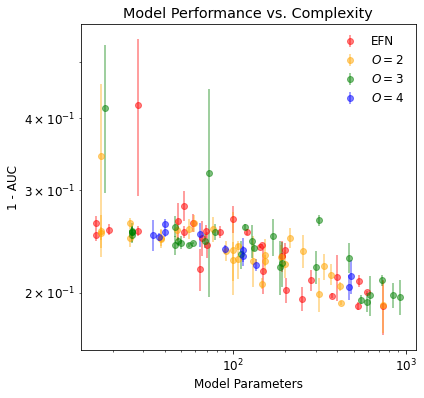

11 4 [3 1 3] 75
Epoch 1/50
150/150 - 7s - loss: 0.6919 - acc: 0.5265 - val_loss: 0.6872 - val_acc: 0.5770
Epoch 2/50
150/150 - 7s - loss: 0.6442 - acc: 0.6586 - val_loss: 0.6193 - val_acc: 0.6805
Epoch 3/50
150/150 - 8s - loss: 0.6192 - acc: 0.6773 - val_loss: 0.6107 - val_acc: 0.7030
Epoch 4/50
150/150 - 8s - loss: 0.6157 - acc: 0.6807 - val_loss: 0.6076 - val_acc: 0.6935
Epoch 5/50


In [11]:

## training
epochs = 50
batch_size=500
callbacks =None
verbose = 2
###########

order_performance = dict()
for order in order_list:
    order_performance['Order '+str(order)] = []
    


for order in order_list:
    for i in range(num_samples):
        info = order_configs['Order '+str(order)][i]
        L, F, Phi = info

        container = ModelsContainer(**{'Phi_mapping_dim' : [input_dim,L],
                                      'output_dim' : 1, 'output_act' : 'sigmoid',
                                      'Phi_sizes' : [Phi, Phi], 'Phi_acts' : 'LeakyReLU',
                                      'F_sizes' : [F,F,F], 'F_acts': 'LeakyReLU',
                                      'order' : order , 'architecture_type':'moment',
                                      'loss': 'binary_crossentropy','metrics': 'acc'})
        print(i, order, info, container.num_params)
        container.train_models(num_models = num_models_to_train,
                                    X_train = X_train, Y_train = Y_train,
                                    epochs = epochs, batch_size = batch_size,
                                    validation_data = (X_val, Y_val),
                                    callbacks=None, verbose=verbose)
        mean, std = container.test_meanstd(X_test = X_test, Y_test = Y_test, metric_function = roc_auc_score)
        num_params = container.num_params
        
        order_performance['Order '+str(order)].append([num_params,mean,std])

        # Just for fun, update the plot
        plot(order_performance)
   
    order_performance['Order '+str(order)] = np.array(order_performance['Order '+str(order)])

In [ ]:
# plt.style.use('seaborn-white')


file_to_save = {'configs' : order_configs, 'performance' : order_performance}
np.save('datapoints', file_to_save)
np.save('configs', order_configs)
np.save('performance' : order_performance)

plot(order_performance)
plt.savefig("test.png")

{'configs': {'Order 1': array([[ 3, 17,  4],
       [22, 48, 46],
       [ 1,  1, 10],
       [ 8,  1,  8],
       [ 5,  1,  1],
       [13, 21, 40],
       [14,  5,  5],
       [12,  9, 49],
       [14,  9,  1],
       [ 2,  2,  1],
       [20,  1,  3],
       [ 4,  8, 25],
       [ 2,  1, 17],
       [ 6,  2, 19],
       [ 8,  1,  1],
       [25, 14,  9],
       [25, 50, 12],
       [ 3,  6,  2],
       [22, 19, 48],
       [14,  3,  1]]), 'Order 2': array([[ 3, 39, 44],
       [ 3,  3,  1],
       [ 4, 19,  7],
       [ 7,  6, 23],
       [ 5, 39, 47],
       [ 8,  8,  6],
       [ 7, 30, 29],
       [ 4, 47, 33],
       [ 3,  1,  4],
       [ 4, 12,  2],
       [ 1,  1,  5],
       [ 2, 13, 16],
       [ 2,  3,  3],
       [ 1,  4,  1],
       [ 2,  2,  1],
       [ 1,  3, 14],
       [ 1,  4,  3],
       [ 6, 41, 18],
       [ 2,  4, 10],
       [ 3,  4,  4]]), 'Order 3': array([[ 4,  7, 18],
       [ 1,  4,  2],
       [ 2,  3,  1],
       [ 2,  2,  1],
       [ 3,  1,  2],
     

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices